# Introduction

複数の時系列データの時系列予測を行います。


# 各種ライブラリの取得



In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
import time
from contextlib import contextmanager
import tensorflow as tf
from keras.callbacks import TensorBoard, EarlyStopping
from pathlib import Path
import gc

plt.style.use('ggplot')


/Users/masayaohgushi/sensor_cpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# 時間計測のための関数

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [3]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

In [4]:
max(wave_data["Temp"].values)

26.3

In [5]:
production_of_gas_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/monthly-production-of-gas-in-aus-train.csv', header=None, names=["Date", "production-of-gas"])
production_of_gas_data = production_of_gas_data.sort_values(by=['Date'])

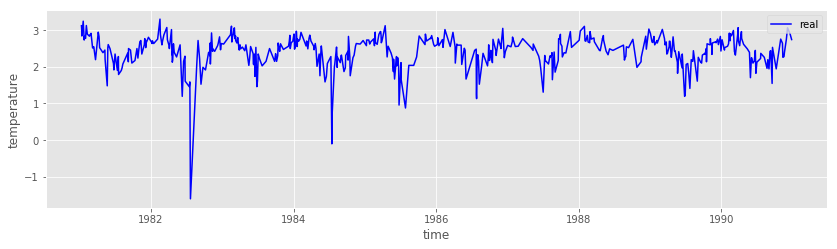

In [6]:
X_orig = np.nan_to_num(np.log(wave_data["Temp"].values + 1))
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b", ylabel='temperature'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

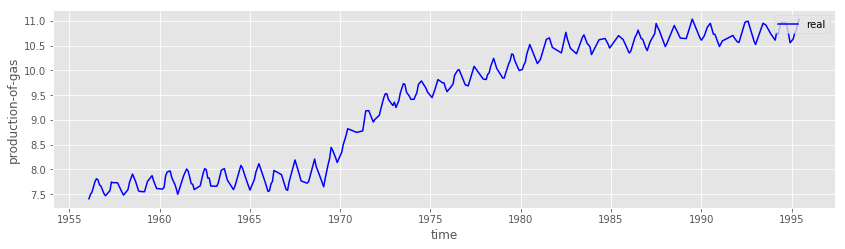

In [7]:
X_orig_second = np.nan_to_num(np.log(production_of_gas_data["production-of-gas"].values + 1))
X_day_second = production_of_gas_data["Date"].values

show_graph(X_day_second, X_orig_second, 'real', ylabel='production-of-gas')

In [8]:
print(X_orig_second.shape)
print(X_orig.shape)

(238,)
(500,)


# データの分割

- 学習データ
- テストデータ

In [9]:
X_train = X_orig[:150]
X_test = X_orig[151:238]
X_train_day = X_day[:150]
X_test_day = X_day[151:238]

X_train_second = X_orig_second[:150]
X_test_second = X_orig_second[151:238]
X_train_day_second = X_day_second[:150]
X_test_day_second = X_day_second[151:238]


# 学習データ

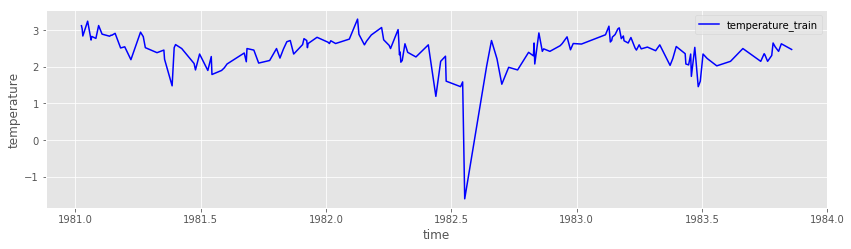

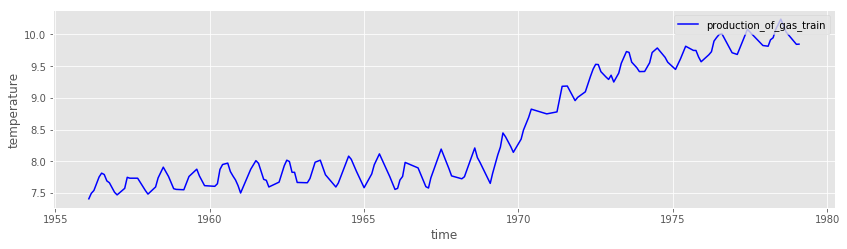

In [10]:
show_graph(X_train_day, X_train, 'temperature_train')
show_graph(X_train_day_second, X_train_second, 'production_of_gas_train')

# テストデータ

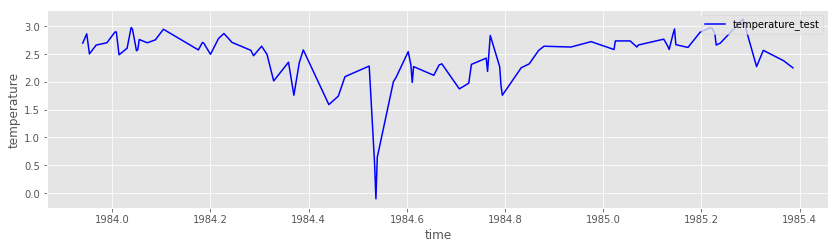

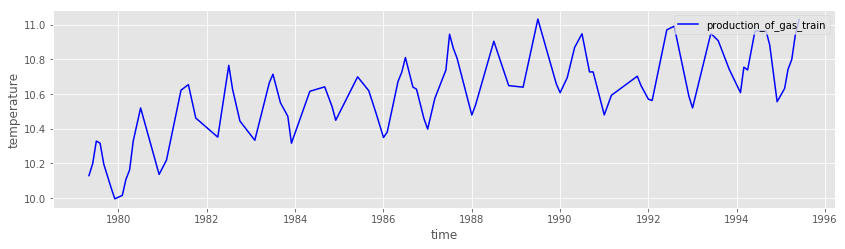

In [11]:
show_graph(X_test_day, X_test, 'temperature_test')
show_graph(X_test_day_second, X_test_second, 'production_of_gas_train')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [12]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 150)

In [13]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)


input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)
print('input_dim: ', input_dim)
print('timesteps: ', timesteps)

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
(150, 3, 2)
input_dim:  2
timesteps:  3


# 重み付きヘテロジニアスラーニングのCallBackクラスを設定

In [14]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
from keras.callbacks import Callback
import numpy as np
from collections import OrderedDict


class HeteroGeniousCallbacks(Callback):

    def __init__(self,
                 variable_number: int = 2,
                 ):
        super(HeteroGeniousCallbacks, self).__init__()

        self.current_val_loss = {}
        self.class_weight = {}
        self.first_data_label = False
        self.variable_number = variable_number

    def on_train_begin(self, logs=None):
        self.first_data_label = True

    def on_epoch_end(self, epoch, logs=None):
        
        sort_logs = OrderedDict(
            sorted(logs.items(), key=lambda x: x[0]))
        
        for each_label, each_values in sort_logs.items():
            if 'val' in each_label and 'loss' in each_label:
                if each_label not in self.class_weight:
                    self.class_weight[each_label] = each_values
                else:
                    each_values_tmp = self.class_weight[each_label] 
                    each_value_list = np.vstack((each_values,
                                                 each_values_tmp))
                    self.class_weight[each_label] = each_value_list

    def on_train_end(self, logs=None):
        self.class_weight = OrderedDict(
            sorted(self.class_weight.items(), key=lambda x: x[0]))

        val_stable_dict = {}
        for each_label, each_value_lsit in self.class_weight.items():
            val_stable_dict[each_label] = \
                np.average(each_value_lsit) + 3.0 * np.std(each_value_lsit)

        val_stable_dict = OrderedDict(
            sorted(val_stable_dict.items(), key=lambda x: x[1]))

        most_stable_value = [value for value in val_stable_dict.values()][0]

        index = 0
        tmp_class_weight = {}
        
        for each_label in self.class_weight.keys():
            tmp_class_weight[index] = \
                val_stable_dict[each_label] / most_stable_value
            if index >= self.variable_number - 1:
                break
            index += 1

        self.class_weight = tmp_class_weight
        print('hetero genious class weight {}'.format(self.class_weight))
hetero_genious_callbacks = HeteroGeniousCallbacks()

# 個別入力型モデル

- `create_model_individual`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [15]:
def create_model_individual(
     input_dim,
     time_steps,
     latent_dim_list,
     # データが一つしかないので1しか選べない
     batch_size=1,
     model_option='lstm',
     optimizer='adam',
):
    input_list = []
    output_list = []
    
    with tf.name_scope('Model'):
        for i in range(input_dim):
            with tf.name_scope('Input' + str(i)):    
                x = Input(shape=(time_steps, 1,))

            if model_option == 'lstm':
                with tf.name_scope('LSTM' + str(i)):
                    h = LSTM(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            elif model_option == 'gru':
                with tf.name_scope('GRU' + str(i)):
                    h = GRU(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            
            with tf.name_scope('Dense' + str(i)):
                out = Dense(1)(h)
            input_list.append(x)
            output_list.append(out)

        model = Model(inputs=input_list, outputs=output_list)
        model.summary()
        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 個別入力型のためのデータ準備

In [16]:
def prepare_data_individual(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x_reshape = []
    for i in range(x.shape[0]):
        x_reshape.append([x[i]])
    x_reshape = np.array(x_reshape)
    x_reshape = np.swapaxes(x_reshape, 1, 2)
    x_reshape = np.swapaxes(x_reshape, 2, 3)
    return list(x_reshape), scaler
   

x, scaler = prepare_data_individual(X_train_joint, time_steps, variable_number)
print(len(x))

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
2


# 個別入力型モデルの予測関数

In [17]:
def predict_model_show_graph_individual(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    prepare_value = np.array(prepare_value)
    preds = np.array(preds)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[0]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[i, :, 0, 0], color='r', label='data')
        plt.plot(preds[i, :, 0, 0], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(list(preds), list(prepare_value)))
    return preds, prepare_value
    # return predict_scale, x_scale

# 個別入力モデルの定義

In [18]:
predict_list = []
var_list = []

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3, 120)       58560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 3, 150)       91200       input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

# 個別入力モデルの学習

In [19]:
early_stop = EarlyStopping(patience=10)

In [20]:
log_dir = 'model_normal'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model individual'):
    model.fit(x, x, validation_split=0.1, epochs=1000, callbacks=[tensorboard, early_stop])


Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 7ms/step - loss: 0.7269 - dense_1_loss: 0.0635 - dense_2_loss: 0.6635 - dense_1_mean_squared_error: 0.0635 - dense_2_mean_squared_error: 0.6635 - val_loss: 0.6124 - val_dense_1_loss: 0.0345 - val_dense_2_loss: 0.5779 - val_dense_1_mean_squared_error: 0.0345 - val_dense_2_mean_squared_error: 0.5779
Epoch 2/1000
135/135 [==============================] - 0s 215us/step - loss: 0.5393 - dense_1_loss: 0.0445 - dense_2_loss: 0.4949 - dense_1_mean_squared_error: 0.0445 - dense_2_mean_squared_error: 0.4949 - val_loss: 0.4506 - val_dense_1_loss: 0.0248 - val_dense_2_loss: 0.4258 - val_dense_1_mean_squared_error: 0.0248 - val_dense_2_mean_squared_error: 0.4258
Epoch 3/1000
135/135 [==============================] - 0s 220us/step - loss: 0.3823 - dense_1_loss: 0.0304 - dense_2_loss: 0.3519 - dense_1_mean_squared_error: 0.0304 - dense_2_mean_squared_error: 0.3519 - val_loss: 0.3211 - val_dense_1

Epoch 24/1000
135/135 [==============================] - 0s 228us/step - loss: 0.0237 - dense_1_loss: 0.0069 - dense_2_loss: 0.0168 - dense_1_mean_squared_error: 0.0069 - dense_2_mean_squared_error: 0.0168 - val_loss: 0.0620 - val_dense_1_loss: 0.0107 - val_dense_2_loss: 0.0514 - val_dense_1_mean_squared_error: 0.0107 - val_dense_2_mean_squared_error: 0.0514
Epoch 25/1000
135/135 [==============================] - 0s 248us/step - loss: 0.0211 - dense_1_loss: 0.0063 - dense_2_loss: 0.0148 - dense_1_mean_squared_error: 0.0063 - dense_2_mean_squared_error: 0.0148 - val_loss: 0.0598 - val_dense_1_loss: 0.0101 - val_dense_2_loss: 0.0496 - val_dense_1_mean_squared_error: 0.0101 - val_dense_2_mean_squared_error: 0.0496
Epoch 26/1000
135/135 [==============================] - 0s 247us/step - loss: 0.0187 - dense_1_loss: 0.0058 - dense_2_loss: 0.0129 - dense_1_mean_squared_error: 0.0058 - dense_2_mean_squared_error: 0.0129 - val_loss: 0.0577 - val_dense_1_loss: 0.0098 - val_dense_2_loss: 0.0479

Epoch 47/1000
135/135 [==============================] - 0s 232us/step - loss: 0.0028 - dense_1_loss: 0.0011 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 0.0011 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0409 - val_dense_1_loss: 0.0040 - val_dense_2_loss: 0.0369 - val_dense_1_mean_squared_error: 0.0040 - val_dense_2_mean_squared_error: 0.0369
Epoch 48/1000
135/135 [==============================] - 0s 233us/step - loss: 0.0027 - dense_1_loss: 0.0011 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 0.0011 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0405 - val_dense_1_loss: 0.0037 - val_dense_2_loss: 0.0368 - val_dense_1_mean_squared_error: 0.0037 - val_dense_2_mean_squared_error: 0.0368
Epoch 49/1000
135/135 [==============================] - 0s 236us/step - loss: 0.0026 - dense_1_loss: 9.8450e-04 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 9.8450e-04 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0402 - val_dense_1_loss: 0.0036 - val_dense_2_loss

135/135 [==============================] - 0s 237us/step - loss: 0.0017 - dense_1_loss: 2.3342e-04 - dense_2_loss: 0.0015 - dense_1_mean_squared_error: 2.3342e-04 - dense_2_mean_squared_error: 0.0015 - val_loss: 0.0339 - val_dense_1_loss: 7.7709e-04 - val_dense_2_loss: 0.0331 - val_dense_1_mean_squared_error: 7.7709e-04 - val_dense_2_mean_squared_error: 0.0331
Epoch 70/1000
135/135 [==============================] - 0s 235us/step - loss: 0.0017 - dense_1_loss: 2.1276e-04 - dense_2_loss: 0.0014 - dense_1_mean_squared_error: 2.1276e-04 - dense_2_mean_squared_error: 0.0014 - val_loss: 0.0335 - val_dense_1_loss: 6.7863e-04 - val_dense_2_loss: 0.0328 - val_dense_1_mean_squared_error: 6.7863e-04 - val_dense_2_mean_squared_error: 0.0328
Epoch 71/1000
135/135 [==============================] - 0s 265us/step - loss: 0.0017 - dense_1_loss: 1.9492e-04 - dense_2_loss: 0.0015 - dense_1_mean_squared_error: 1.9492e-04 - dense_2_mean_squared_error: 0.0015 - val_loss: 0.0333 - val_dense_1_loss: 6.3791e

Epoch 91/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0013 - dense_1_loss: 3.4957e-05 - dense_2_loss: 0.0013 - dense_1_mean_squared_error: 3.4957e-05 - dense_2_mean_squared_error: 0.0013 - val_loss: 0.0292 - val_dense_1_loss: 7.5494e-05 - val_dense_2_loss: 0.0291 - val_dense_1_mean_squared_error: 7.5494e-05 - val_dense_2_mean_squared_error: 0.0291
Epoch 92/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0013 - dense_1_loss: 3.2440e-05 - dense_2_loss: 0.0013 - dense_1_mean_squared_error: 3.2440e-05 - dense_2_mean_squared_error: 0.0013 - val_loss: 0.0290 - val_dense_1_loss: 6.9911e-05 - val_dense_2_loss: 0.0289 - val_dense_1_mean_squared_error: 6.9911e-05 - val_dense_2_mean_squared_error: 0.0289
Epoch 93/1000
135/135 [==============================] - 0s 284us/step - loss: 0.0013 - dense_1_loss: 3.0342e-05 - dense_2_loss: 0.0013 - dense_1_mean_squared_error: 3.0342e-05 - dense_2_mean_squared_error: 0.0013 - val_loss: 0.0288 - val_dense_1

Epoch 113/1000
135/135 [==============================] - 0s 242us/step - loss: 0.0011 - dense_1_loss: 9.8918e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 9.8918e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0252 - val_dense_1_loss: 1.6331e-05 - val_dense_2_loss: 0.0252 - val_dense_1_mean_squared_error: 1.6331e-05 - val_dense_2_mean_squared_error: 0.0252
Epoch 114/1000
135/135 [==============================] - 0s 228us/step - loss: 0.0011 - dense_1_loss: 9.5342e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 9.5342e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0250 - val_dense_1_loss: 1.5279e-05 - val_dense_2_loss: 0.0250 - val_dense_1_mean_squared_error: 1.5279e-05 - val_dense_2_mean_squared_error: 0.0250
Epoch 115/1000
135/135 [==============================] - 0s 254us/step - loss: 0.0011 - dense_1_loss: 9.1228e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 9.1228e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0248 - val_dens

135/135 [==============================] - 0s 244us/step - loss: 9.6766e-04 - dense_1_loss: 5.4836e-06 - dense_2_loss: 9.6217e-04 - dense_1_mean_squared_error: 5.4836e-06 - dense_2_mean_squared_error: 9.6217e-04 - val_loss: 0.0218 - val_dense_1_loss: 7.7143e-06 - val_dense_2_loss: 0.0218 - val_dense_1_mean_squared_error: 7.7143e-06 - val_dense_2_mean_squared_error: 0.0218
Epoch 135/1000
135/135 [==============================] - 0s 238us/step - loss: 9.6212e-04 - dense_1_loss: 5.4121e-06 - dense_2_loss: 9.5670e-04 - dense_1_mean_squared_error: 5.4121e-06 - dense_2_mean_squared_error: 9.5670e-04 - val_loss: 0.0217 - val_dense_1_loss: 7.6768e-06 - val_dense_2_loss: 0.0217 - val_dense_1_mean_squared_error: 7.6768e-06 - val_dense_2_mean_squared_error: 0.0217
Epoch 136/1000
135/135 [==============================] - 0s 246us/step - loss: 9.4396e-04 - dense_1_loss: 5.3635e-06 - dense_2_loss: 9.3860e-04 - dense_1_mean_squared_error: 5.3635e-06 - dense_2_mean_squared_error: 9.3860e-04 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 8.4673e-04 - dense_1_loss: 4.5796e-06 - dense_2_loss: 8.4215e-04 - dense_1_mean_squared_error: 4.5796e-06 - dense_2_mean_squared_error: 8.4215e-04 - val_loss: 0.0191 - val_dense_1_loss: 6.1219e-06 - val_dense_2_loss: 0.0190 - val_dense_1_mean_squared_error: 6.1219e-06 - val_dense_2_mean_squared_error: 0.0190
Epoch 156/1000
135/135 [==============================] - 0s 243us/step - loss: 8.3734e-04 - dense_1_loss: 4.5923e-06 - dense_2_loss: 8.3274e-04 - dense_1_mean_squared_error: 4.5923e-06 - dense_2_mean_squared_error: 8.3274e-04 - val_loss: 0.0189 - val_dense_1_loss: 6.2667e-06 - val_dense_2_loss: 0.0189 - val_dense_1_mean_squared_error: 6.2667e-06 - val_dense_2_mean_squared_error: 0.0189
Epoch 157/1000
135/135 [==============================] - 0s 240us/step - loss: 8.2211e-04 - dense_1_loss: 4.5369e-06 - dense_2_loss: 8.1758e-04 - dense_1_mean_squared_error: 4.5369e-06 - dense_2_mean_squared_error: 8.1758e-04 - val_lo

135/135 [==============================] - 0s 211us/step - loss: 7.2627e-04 - dense_1_loss: 4.2307e-06 - dense_2_loss: 7.2203e-04 - dense_1_mean_squared_error: 4.2307e-06 - dense_2_mean_squared_error: 7.2203e-04 - val_loss: 0.0169 - val_dense_1_loss: 5.8316e-06 - val_dense_2_loss: 0.0169 - val_dense_1_mean_squared_error: 5.8316e-06 - val_dense_2_mean_squared_error: 0.0169
Epoch 177/1000
135/135 [==============================] - 0s 210us/step - loss: 7.2158e-04 - dense_1_loss: 4.2347e-06 - dense_2_loss: 7.1734e-04 - dense_1_mean_squared_error: 4.2347e-06 - dense_2_mean_squared_error: 7.1734e-04 - val_loss: 0.0168 - val_dense_1_loss: 5.7221e-06 - val_dense_2_loss: 0.0168 - val_dense_1_mean_squared_error: 5.7221e-06 - val_dense_2_mean_squared_error: 0.0168
Epoch 178/1000
135/135 [==============================] - 0s 213us/step - loss: 7.1732e-04 - dense_1_loss: 4.2370e-06 - dense_2_loss: 7.1309e-04 - dense_1_mean_squared_error: 4.2370e-06 - dense_2_mean_squared_error: 7.1309e-04 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 6.3424e-04 - dense_1_loss: 3.9736e-06 - dense_2_loss: 6.3027e-04 - dense_1_mean_squared_error: 3.9736e-06 - dense_2_mean_squared_error: 6.3027e-04 - val_loss: 0.0152 - val_dense_1_loss: 5.0938e-06 - val_dense_2_loss: 0.0152 - val_dense_1_mean_squared_error: 5.0938e-06 - val_dense_2_mean_squared_error: 0.0152
Epoch 198/1000
135/135 [==============================] - 0s 233us/step - loss: 6.4129e-04 - dense_1_loss: 3.9349e-06 - dense_2_loss: 6.3736e-04 - dense_1_mean_squared_error: 3.9349e-06 - dense_2_mean_squared_error: 6.3736e-04 - val_loss: 0.0151 - val_dense_1_loss: 5.1667e-06 - val_dense_2_loss: 0.0151 - val_dense_1_mean_squared_error: 5.1667e-06 - val_dense_2_mean_squared_error: 0.0151
Epoch 199/1000
135/135 [==============================] - 0s 228us/step - loss: 6.2980e-04 - dense_1_loss: 3.9172e-06 - dense_2_loss: 6.2588e-04 - dense_1_mean_squared_error: 3.9172e-06 - dense_2_mean_squared_error: 6.2588e-04 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 5.5493e-04 - dense_1_loss: 3.7472e-06 - dense_2_loss: 5.5118e-04 - dense_1_mean_squared_error: 3.7472e-06 - dense_2_mean_squared_error: 5.5118e-04 - val_loss: 0.0139 - val_dense_1_loss: 5.1817e-06 - val_dense_2_loss: 0.0139 - val_dense_1_mean_squared_error: 5.1817e-06 - val_dense_2_mean_squared_error: 0.0139
Epoch 219/1000
135/135 [==============================] - 0s 260us/step - loss: 5.5089e-04 - dense_1_loss: 3.7170e-06 - dense_2_loss: 5.4718e-04 - dense_1_mean_squared_error: 3.7170e-06 - dense_2_mean_squared_error: 5.4718e-04 - val_loss: 0.0139 - val_dense_1_loss: 5.1361e-06 - val_dense_2_loss: 0.0139 - val_dense_1_mean_squared_error: 5.1361e-06 - val_dense_2_mean_squared_error: 0.0139
Epoch 220/1000
135/135 [==============================] - 0s 236us/step - loss: 5.4572e-04 - dense_1_loss: 3.6637e-06 - dense_2_loss: 5.4205e-04 - dense_1_mean_squared_error: 3.6637e-06 - dense_2_mean_squared_error: 5.4205e-04 - val_lo

135/135 [==============================] - 0s 247us/step - loss: 4.8233e-04 - dense_1_loss: 3.4484e-06 - dense_2_loss: 4.7888e-04 - dense_1_mean_squared_error: 3.4484e-06 - dense_2_mean_squared_error: 4.7888e-04 - val_loss: 0.0128 - val_dense_1_loss: 4.6010e-06 - val_dense_2_loss: 0.0128 - val_dense_1_mean_squared_error: 4.6010e-06 - val_dense_2_mean_squared_error: 0.0128
Epoch 240/1000
135/135 [==============================] - 0s 247us/step - loss: 4.7642e-04 - dense_1_loss: 3.4520e-06 - dense_2_loss: 4.7297e-04 - dense_1_mean_squared_error: 3.4520e-06 - dense_2_mean_squared_error: 4.7297e-04 - val_loss: 0.0127 - val_dense_1_loss: 4.6121e-06 - val_dense_2_loss: 0.0127 - val_dense_1_mean_squared_error: 4.6121e-06 - val_dense_2_mean_squared_error: 0.0127
Epoch 241/1000
135/135 [==============================] - 0s 253us/step - loss: 4.6975e-04 - dense_1_loss: 3.4121e-06 - dense_2_loss: 4.6634e-04 - dense_1_mean_squared_error: 3.4121e-06 - dense_2_mean_squared_error: 4.6634e-04 - val_lo

135/135 [==============================] - 0s 236us/step - loss: 4.0520e-04 - dense_1_loss: 3.2253e-06 - dense_2_loss: 4.0197e-04 - dense_1_mean_squared_error: 3.2253e-06 - dense_2_mean_squared_error: 4.0197e-04 - val_loss: 0.0118 - val_dense_1_loss: 4.3160e-06 - val_dense_2_loss: 0.0118 - val_dense_1_mean_squared_error: 4.3160e-06 - val_dense_2_mean_squared_error: 0.0118
Epoch 261/1000
135/135 [==============================] - 0s 229us/step - loss: 4.0729e-04 - dense_1_loss: 3.2028e-06 - dense_2_loss: 4.0409e-04 - dense_1_mean_squared_error: 3.2028e-06 - dense_2_mean_squared_error: 4.0409e-04 - val_loss: 0.0117 - val_dense_1_loss: 4.3436e-06 - val_dense_2_loss: 0.0117 - val_dense_1_mean_squared_error: 4.3436e-06 - val_dense_2_mean_squared_error: 0.0117
Epoch 262/1000
135/135 [==============================] - 0s 224us/step - loss: 4.0263e-04 - dense_1_loss: 3.1991e-06 - dense_2_loss: 3.9943e-04 - dense_1_mean_squared_error: 3.1991e-06 - dense_2_mean_squared_error: 3.9943e-04 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 3.4177e-04 - dense_1_loss: 2.9922e-06 - dense_2_loss: 3.3878e-04 - dense_1_mean_squared_error: 2.9922e-06 - dense_2_mean_squared_error: 3.3878e-04 - val_loss: 0.0108 - val_dense_1_loss: 4.2452e-06 - val_dense_2_loss: 0.0108 - val_dense_1_mean_squared_error: 4.2452e-06 - val_dense_2_mean_squared_error: 0.0108
Epoch 282/1000
135/135 [==============================] - 0s 228us/step - loss: 3.3542e-04 - dense_1_loss: 2.9874e-06 - dense_2_loss: 3.3244e-04 - dense_1_mean_squared_error: 2.9874e-06 - dense_2_mean_squared_error: 3.3244e-04 - val_loss: 0.0107 - val_dense_1_loss: 4.3262e-06 - val_dense_2_loss: 0.0107 - val_dense_1_mean_squared_error: 4.3262e-06 - val_dense_2_mean_squared_error: 0.0107
Epoch 283/1000
135/135 [==============================] - 0s 236us/step - loss: 3.3762e-04 - dense_1_loss: 2.9861e-06 - dense_2_loss: 3.3463e-04 - dense_1_mean_squared_error: 2.9861e-06 - dense_2_mean_squared_error: 3.3463e-04 - val_lo

Epoch 302/1000
135/135 [==============================] - 0s 232us/step - loss: 2.8432e-04 - dense_1_loss: 2.8363e-06 - dense_2_loss: 2.8148e-04 - dense_1_mean_squared_error: 2.8363e-06 - dense_2_mean_squared_error: 2.8148e-04 - val_loss: 0.0098 - val_dense_1_loss: 3.9812e-06 - val_dense_2_loss: 0.0098 - val_dense_1_mean_squared_error: 3.9812e-06 - val_dense_2_mean_squared_error: 0.0098
Epoch 303/1000
135/135 [==============================] - 0s 232us/step - loss: 2.8854e-04 - dense_1_loss: 2.8015e-06 - dense_2_loss: 2.8573e-04 - dense_1_mean_squared_error: 2.8015e-06 - dense_2_mean_squared_error: 2.8573e-04 - val_loss: 0.0098 - val_dense_1_loss: 3.9605e-06 - val_dense_2_loss: 0.0098 - val_dense_1_mean_squared_error: 3.9605e-06 - val_dense_2_mean_squared_error: 0.0098
Epoch 304/1000
135/135 [==============================] - 0s 215us/step - loss: 2.7897e-04 - dense_1_loss: 2.8106e-06 - dense_2_loss: 2.7616e-04 - dense_1_mean_squared_error: 2.8106e-06 - dense_2_mean_squared_error: 2.76

135/135 [==============================] - 0s 227us/step - loss: 2.3568e-04 - dense_1_loss: 2.5864e-06 - dense_2_loss: 2.3309e-04 - dense_1_mean_squared_error: 2.5864e-06 - dense_2_mean_squared_error: 2.3309e-04 - val_loss: 0.0089 - val_dense_1_loss: 3.7131e-06 - val_dense_2_loss: 0.0089 - val_dense_1_mean_squared_error: 3.7131e-06 - val_dense_2_mean_squared_error: 0.0089
Epoch 324/1000
135/135 [==============================] - 0s 233us/step - loss: 2.3277e-04 - dense_1_loss: 2.5757e-06 - dense_2_loss: 2.3020e-04 - dense_1_mean_squared_error: 2.5757e-06 - dense_2_mean_squared_error: 2.3020e-04 - val_loss: 0.0088 - val_dense_1_loss: 3.7452e-06 - val_dense_2_loss: 0.0088 - val_dense_1_mean_squared_error: 3.7452e-06 - val_dense_2_mean_squared_error: 0.0088
Epoch 325/1000
135/135 [==============================] - 0s 231us/step - loss: 2.3222e-04 - dense_1_loss: 2.5640e-06 - dense_2_loss: 2.2965e-04 - dense_1_mean_squared_error: 2.5640e-06 - dense_2_mean_squared_error: 2.2965e-04 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 1.9738e-04 - dense_1_loss: 2.4270e-06 - dense_2_loss: 1.9495e-04 - dense_1_mean_squared_error: 2.4270e-06 - dense_2_mean_squared_error: 1.9495e-04 - val_loss: 0.0080 - val_dense_1_loss: 3.3882e-06 - val_dense_2_loss: 0.0080 - val_dense_1_mean_squared_error: 3.3882e-06 - val_dense_2_mean_squared_error: 0.0080
Epoch 345/1000
135/135 [==============================] - ETA: 0s - loss: 1.9800e-04 - dense_1_loss: 2.6518e-06 - dense_2_loss: 1.9535e-04 - dense_1_mean_squared_error: 2.6518e-06 - dense_2_mean_squared_error: 1.9535e-0 - 0s 227us/step - loss: 1.9579e-04 - dense_1_loss: 2.3986e-06 - dense_2_loss: 1.9339e-04 - dense_1_mean_squared_error: 2.3986e-06 - dense_2_mean_squared_error: 1.9339e-04 - val_loss: 0.0080 - val_dense_1_loss: 3.3165e-06 - val_dense_2_loss: 0.0080 - val_dense_1_mean_squared_error: 3.3165e-06 - val_dense_2_mean_squared_error: 0.0080
Epoch 346/1000
135/135 [==============================] - 0s 229us/step

Epoch 365/1000
135/135 [==============================] - 0s 235us/step - loss: 1.6124e-04 - dense_1_loss: 2.2390e-06 - dense_2_loss: 1.5900e-04 - dense_1_mean_squared_error: 2.2390e-06 - dense_2_mean_squared_error: 1.5900e-04 - val_loss: 0.0072 - val_dense_1_loss: 3.2137e-06 - val_dense_2_loss: 0.0072 - val_dense_1_mean_squared_error: 3.2137e-06 - val_dense_2_mean_squared_error: 0.0072
Epoch 366/1000
135/135 [==============================] - 0s 222us/step - loss: 1.6193e-04 - dense_1_loss: 2.2355e-06 - dense_2_loss: 1.5970e-04 - dense_1_mean_squared_error: 2.2355e-06 - dense_2_mean_squared_error: 1.5970e-04 - val_loss: 0.0072 - val_dense_1_loss: 3.2400e-06 - val_dense_2_loss: 0.0071 - val_dense_1_mean_squared_error: 3.2400e-06 - val_dense_2_mean_squared_error: 0.0071
Epoch 367/1000
135/135 [==============================] - 0s 226us/step - loss: 1.5856e-04 - dense_1_loss: 2.2129e-06 - dense_2_loss: 1.5635e-04 - dense_1_mean_squared_error: 2.2129e-06 - dense_2_mean_squared_error: 1.56

Epoch 386/1000
135/135 [==============================] - 0s 235us/step - loss: 1.3386e-04 - dense_1_loss: 2.0656e-06 - dense_2_loss: 1.3179e-04 - dense_1_mean_squared_error: 2.0656e-06 - dense_2_mean_squared_error: 1.3179e-04 - val_loss: 0.0065 - val_dense_1_loss: 3.1927e-06 - val_dense_2_loss: 0.0065 - val_dense_1_mean_squared_error: 3.1927e-06 - val_dense_2_mean_squared_error: 0.0065
Epoch 387/1000
135/135 [==============================] - 0s 239us/step - loss: 1.3342e-04 - dense_1_loss: 2.0608e-06 - dense_2_loss: 1.3136e-04 - dense_1_mean_squared_error: 2.0608e-06 - dense_2_mean_squared_error: 1.3136e-04 - val_loss: 0.0065 - val_dense_1_loss: 3.2068e-06 - val_dense_2_loss: 0.0064 - val_dense_1_mean_squared_error: 3.2068e-06 - val_dense_2_mean_squared_error: 0.0064
Epoch 388/1000
135/135 [==============================] - 0s 227us/step - loss: 1.3206e-04 - dense_1_loss: 2.0480e-06 - dense_2_loss: 1.3002e-04 - dense_1_mean_squared_error: 2.0480e-06 - dense_2_mean_squared_error: 1.30

135/135 [==============================] - 0s 236us/step - loss: 1.2105e-04 - dense_1_loss: 1.9550e-06 - dense_2_loss: 1.1910e-04 - dense_1_mean_squared_error: 1.9550e-06 - dense_2_mean_squared_error: 1.1910e-04 - val_loss: 0.0058 - val_dense_1_loss: 3.0113e-06 - val_dense_2_loss: 0.0058 - val_dense_1_mean_squared_error: 3.0113e-06 - val_dense_2_mean_squared_error: 0.0058
Epoch 408/1000
135/135 [==============================] - 0s 232us/step - loss: 1.1505e-04 - dense_1_loss: 1.9209e-06 - dense_2_loss: 1.1313e-04 - dense_1_mean_squared_error: 1.9209e-06 - dense_2_mean_squared_error: 1.1313e-04 - val_loss: 0.0059 - val_dense_1_loss: 2.9947e-06 - val_dense_2_loss: 0.0059 - val_dense_1_mean_squared_error: 2.9947e-06 - val_dense_2_mean_squared_error: 0.0059
Epoch 409/1000
135/135 [==============================] - 0s 251us/step - loss: 1.1522e-04 - dense_1_loss: 1.8983e-06 - dense_2_loss: 1.1333e-04 - dense_1_mean_squared_error: 1.8983e-06 - dense_2_mean_squared_error: 1.1333e-04 - val_lo

135/135 [==============================] - 0s 249us/step - loss: 9.1659e-05 - dense_1_loss: 1.7799e-06 - dense_2_loss: 8.9879e-05 - dense_1_mean_squared_error: 1.7799e-06 - dense_2_mean_squared_error: 8.9879e-05 - val_loss: 0.0053 - val_dense_1_loss: 2.6763e-06 - val_dense_2_loss: 0.0053 - val_dense_1_mean_squared_error: 2.6763e-06 - val_dense_2_mean_squared_error: 0.0053
Epoch 429/1000
135/135 [==============================] - 0s 244us/step - loss: 9.0417e-05 - dense_1_loss: 1.7871e-06 - dense_2_loss: 8.8630e-05 - dense_1_mean_squared_error: 1.7871e-06 - dense_2_mean_squared_error: 8.8630e-05 - val_loss: 0.0053 - val_dense_1_loss: 2.6781e-06 - val_dense_2_loss: 0.0053 - val_dense_1_mean_squared_error: 2.6781e-06 - val_dense_2_mean_squared_error: 0.0053
Epoch 430/1000
135/135 [==============================] - 0s 250us/step - loss: 8.9764e-05 - dense_1_loss: 1.7495e-06 - dense_2_loss: 8.8014e-05 - dense_1_mean_squared_error: 1.7495e-06 - dense_2_mean_squared_error: 8.8014e-05 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 7.8284e-05 - dense_1_loss: 1.6294e-06 - dense_2_loss: 7.6655e-05 - dense_1_mean_squared_error: 1.6294e-06 - dense_2_mean_squared_error: 7.6655e-05 - val_loss: 0.0048 - val_dense_1_loss: 2.5656e-06 - val_dense_2_loss: 0.0048 - val_dense_1_mean_squared_error: 2.5656e-06 - val_dense_2_mean_squared_error: 0.0048
Epoch 450/1000
135/135 [==============================] - 0s 232us/step - loss: 7.6240e-05 - dense_1_loss: 1.6424e-06 - dense_2_loss: 7.4597e-05 - dense_1_mean_squared_error: 1.6424e-06 - dense_2_mean_squared_error: 7.4597e-05 - val_loss: 0.0048 - val_dense_1_loss: 2.5385e-06 - val_dense_2_loss: 0.0048 - val_dense_1_mean_squared_error: 2.5385e-06 - val_dense_2_mean_squared_error: 0.0048
Epoch 451/1000
135/135 [==============================] - 0s 242us/step - loss: 7.6164e-05 - dense_1_loss: 1.6136e-06 - dense_2_loss: 7.4550e-05 - dense_1_mean_squared_error: 1.6136e-06 - dense_2_mean_squared_error: 7.4550e-05 - val_lo

135/135 [==============================] - 0s 236us/step - loss: 6.4039e-05 - dense_1_loss: 1.5061e-06 - dense_2_loss: 6.2533e-05 - dense_1_mean_squared_error: 1.5061e-06 - dense_2_mean_squared_error: 6.2533e-05 - val_loss: 0.0044 - val_dense_1_loss: 2.5262e-06 - val_dense_2_loss: 0.0044 - val_dense_1_mean_squared_error: 2.5262e-06 - val_dense_2_mean_squared_error: 0.0044
Epoch 471/1000
135/135 [==============================] - 0s 235us/step - loss: 6.2822e-05 - dense_1_loss: 1.4848e-06 - dense_2_loss: 6.1337e-05 - dense_1_mean_squared_error: 1.4848e-06 - dense_2_mean_squared_error: 6.1337e-05 - val_loss: 0.0044 - val_dense_1_loss: 2.4917e-06 - val_dense_2_loss: 0.0044 - val_dense_1_mean_squared_error: 2.4917e-06 - val_dense_2_mean_squared_error: 0.0044
Epoch 472/1000
135/135 [==============================] - 0s 227us/step - loss: 6.2132e-05 - dense_1_loss: 1.4885e-06 - dense_2_loss: 6.0644e-05 - dense_1_mean_squared_error: 1.4885e-06 - dense_2_mean_squared_error: 6.0644e-05 - val_lo

135/135 [==============================] - 0s 235us/step - loss: 5.3099e-05 - dense_1_loss: 1.3757e-06 - dense_2_loss: 5.1723e-05 - dense_1_mean_squared_error: 1.3757e-06 - dense_2_mean_squared_error: 5.1723e-05 - val_loss: 0.0040 - val_dense_1_loss: 2.2672e-06 - val_dense_2_loss: 0.0040 - val_dense_1_mean_squared_error: 2.2672e-06 - val_dense_2_mean_squared_error: 0.0040
Epoch 492/1000
135/135 [==============================] - 0s 233us/step - loss: 5.3603e-05 - dense_1_loss: 1.3788e-06 - dense_2_loss: 5.2224e-05 - dense_1_mean_squared_error: 1.3788e-06 - dense_2_mean_squared_error: 5.2224e-05 - val_loss: 0.0040 - val_dense_1_loss: 2.2448e-06 - val_dense_2_loss: 0.0040 - val_dense_1_mean_squared_error: 2.2448e-06 - val_dense_2_mean_squared_error: 0.0040
Epoch 493/1000
135/135 [==============================] - 0s 230us/step - loss: 5.1535e-05 - dense_1_loss: 1.3851e-06 - dense_2_loss: 5.0149e-05 - dense_1_mean_squared_error: 1.3851e-06 - dense_2_mean_squared_error: 5.0149e-05 - val_lo

135/135 [==============================] - 0s 243us/step - loss: 4.5272e-05 - dense_1_loss: 1.3970e-06 - dense_2_loss: 4.3875e-05 - dense_1_mean_squared_error: 1.3970e-06 - dense_2_mean_squared_error: 4.3875e-05 - val_loss: 0.0037 - val_dense_1_loss: 2.1175e-06 - val_dense_2_loss: 0.0037 - val_dense_1_mean_squared_error: 2.1175e-06 - val_dense_2_mean_squared_error: 0.0037
Epoch 513/1000
135/135 [==============================] - 0s 234us/step - loss: 4.4206e-05 - dense_1_loss: 1.2938e-06 - dense_2_loss: 4.2912e-05 - dense_1_mean_squared_error: 1.2938e-06 - dense_2_mean_squared_error: 4.2912e-05 - val_loss: 0.0037 - val_dense_1_loss: 2.1918e-06 - val_dense_2_loss: 0.0037 - val_dense_1_mean_squared_error: 2.1918e-06 - val_dense_2_mean_squared_error: 0.0037
Epoch 514/1000
135/135 [==============================] - 0s 240us/step - loss: 4.3458e-05 - dense_1_loss: 1.2805e-06 - dense_2_loss: 4.2177e-05 - dense_1_mean_squared_error: 1.2805e-06 - dense_2_mean_squared_error: 4.2177e-05 - val_lo

Epoch 533/1000
135/135 [==============================] - 0s 225us/step - loss: 3.5248e-05 - dense_1_loss: 1.1691e-06 - dense_2_loss: 3.4079e-05 - dense_1_mean_squared_error: 1.1691e-06 - dense_2_mean_squared_error: 3.4079e-05 - val_loss: 0.0034 - val_dense_1_loss: 2.0614e-06 - val_dense_2_loss: 0.0034 - val_dense_1_mean_squared_error: 2.0614e-06 - val_dense_2_mean_squared_error: 0.0034
Epoch 534/1000
135/135 [==============================] - 0s 231us/step - loss: 3.4875e-05 - dense_1_loss: 1.1676e-06 - dense_2_loss: 3.3708e-05 - dense_1_mean_squared_error: 1.1676e-06 - dense_2_mean_squared_error: 3.3708e-05 - val_loss: 0.0034 - val_dense_1_loss: 1.9833e-06 - val_dense_2_loss: 0.0034 - val_dense_1_mean_squared_error: 1.9833e-06 - val_dense_2_mean_squared_error: 0.0034
Epoch 535/1000
135/135 [==============================] - 0s 219us/step - loss: 3.4402e-05 - dense_1_loss: 1.1567e-06 - dense_2_loss: 3.3245e-05 - dense_1_mean_squared_error: 1.1567e-06 - dense_2_mean_squared_error: 3.32

135/135 [==============================] - 0s 229us/step - loss: 3.1583e-05 - dense_1_loss: 1.0850e-06 - dense_2_loss: 3.0498e-05 - dense_1_mean_squared_error: 1.0850e-06 - dense_2_mean_squared_error: 3.0498e-05 - val_loss: 0.0031 - val_dense_1_loss: 1.8605e-06 - val_dense_2_loss: 0.0031 - val_dense_1_mean_squared_error: 1.8605e-06 - val_dense_2_mean_squared_error: 0.0031
Epoch 555/1000
135/135 [==============================] - 0s 239us/step - loss: 2.9343e-05 - dense_1_loss: 1.0550e-06 - dense_2_loss: 2.8288e-05 - dense_1_mean_squared_error: 1.0550e-06 - dense_2_mean_squared_error: 2.8288e-05 - val_loss: 0.0031 - val_dense_1_loss: 1.8283e-06 - val_dense_2_loss: 0.0031 - val_dense_1_mean_squared_error: 1.8283e-06 - val_dense_2_mean_squared_error: 0.0031
Epoch 556/1000
135/135 [==============================] - 0s 229us/step - loss: 2.8280e-05 - dense_1_loss: 1.0700e-06 - dense_2_loss: 2.7210e-05 - dense_1_mean_squared_error: 1.0700e-06 - dense_2_mean_squared_error: 2.7210e-05 - val_lo

135/135 [==============================] - 0s 223us/step - loss: 2.3742e-05 - dense_1_loss: 9.6175e-07 - dense_2_loss: 2.2780e-05 - dense_1_mean_squared_error: 9.6175e-07 - dense_2_mean_squared_error: 2.2780e-05 - val_loss: 0.0029 - val_dense_1_loss: 1.6527e-06 - val_dense_2_loss: 0.0029 - val_dense_1_mean_squared_error: 1.6527e-06 - val_dense_2_mean_squared_error: 0.0029
Epoch 576/1000
135/135 [==============================] - 0s 219us/step - loss: 2.3138e-05 - dense_1_loss: 9.7323e-07 - dense_2_loss: 2.2164e-05 - dense_1_mean_squared_error: 9.7323e-07 - dense_2_mean_squared_error: 2.2164e-05 - val_loss: 0.0029 - val_dense_1_loss: 1.7568e-06 - val_dense_2_loss: 0.0029 - val_dense_1_mean_squared_error: 1.7568e-06 - val_dense_2_mean_squared_error: 0.0029
Epoch 577/1000
135/135 [==============================] - 0s 214us/step - loss: 2.3305e-05 - dense_1_loss: 9.5187e-07 - dense_2_loss: 2.2353e-05 - dense_1_mean_squared_error: 9.5187e-07 - dense_2_mean_squared_error: 2.2353e-05 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 1.8961e-05 - dense_1_loss: 8.9632e-07 - dense_2_loss: 1.8065e-05 - dense_1_mean_squared_error: 8.9632e-07 - dense_2_mean_squared_error: 1.8065e-05 - val_loss: 0.0027 - val_dense_1_loss: 1.6179e-06 - val_dense_2_loss: 0.0027 - val_dense_1_mean_squared_error: 1.6179e-06 - val_dense_2_mean_squared_error: 0.0027
Epoch 597/1000
135/135 [==============================] - 0s 240us/step - loss: 1.8552e-05 - dense_1_loss: 8.7859e-07 - dense_2_loss: 1.7673e-05 - dense_1_mean_squared_error: 8.7859e-07 - dense_2_mean_squared_error: 1.7673e-05 - val_loss: 0.0027 - val_dense_1_loss: 1.6835e-06 - val_dense_2_loss: 0.0027 - val_dense_1_mean_squared_error: 1.6835e-06 - val_dense_2_mean_squared_error: 0.0027
Epoch 598/1000
135/135 [==============================] - 0s 237us/step - loss: 1.8163e-05 - dense_1_loss: 9.1614e-07 - dense_2_loss: 1.7247e-05 - dense_1_mean_squared_error: 9.1614e-07 - dense_2_mean_squared_error: 1.7247e-05 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 1.5544e-05 - dense_1_loss: 8.1470e-07 - dense_2_loss: 1.4729e-05 - dense_1_mean_squared_error: 8.1470e-07 - dense_2_mean_squared_error: 1.4729e-05 - val_loss: 0.0025 - val_dense_1_loss: 1.5356e-06 - val_dense_2_loss: 0.0025 - val_dense_1_mean_squared_error: 1.5356e-06 - val_dense_2_mean_squared_error: 0.0025
Epoch 618/1000
135/135 [==============================] - 0s 248us/step - loss: 1.5483e-05 - dense_1_loss: 8.0725e-07 - dense_2_loss: 1.4675e-05 - dense_1_mean_squared_error: 8.0725e-07 - dense_2_mean_squared_error: 1.4675e-05 - val_loss: 0.0025 - val_dense_1_loss: 1.4553e-06 - val_dense_2_loss: 0.0025 - val_dense_1_mean_squared_error: 1.4553e-06 - val_dense_2_mean_squared_error: 0.0025
Epoch 619/1000
135/135 [==============================] - 0s 230us/step - loss: 1.4850e-05 - dense_1_loss: 7.9805e-07 - dense_2_loss: 1.4052e-05 - dense_1_mean_squared_error: 7.9805e-07 - dense_2_mean_squared_error: 1.4052e-05 - val_lo

135/135 [==============================] - 0s 238us/step - loss: 1.2179e-05 - dense_1_loss: 7.3360e-07 - dense_2_loss: 1.1446e-05 - dense_1_mean_squared_error: 7.3360e-07 - dense_2_mean_squared_error: 1.1446e-05 - val_loss: 0.0024 - val_dense_1_loss: 1.5325e-06 - val_dense_2_loss: 0.0024 - val_dense_1_mean_squared_error: 1.5325e-06 - val_dense_2_mean_squared_error: 0.0024
Epoch 639/1000
135/135 [==============================] - 0s 251us/step - loss: 1.1781e-05 - dense_1_loss: 7.5340e-07 - dense_2_loss: 1.1027e-05 - dense_1_mean_squared_error: 7.5340e-07 - dense_2_mean_squared_error: 1.1027e-05 - val_loss: 0.0024 - val_dense_1_loss: 1.3289e-06 - val_dense_2_loss: 0.0023 - val_dense_1_mean_squared_error: 1.3289e-06 - val_dense_2_mean_squared_error: 0.0023
Epoch 640/1000
135/135 [==============================] - 0s 226us/step - loss: 1.1709e-05 - dense_1_loss: 7.5911e-07 - dense_2_loss: 1.0950e-05 - dense_1_mean_squared_error: 7.5911e-07 - dense_2_mean_squared_error: 1.0950e-05 - val_lo

135/135 [==============================] - 0s 216us/step - loss: 9.8073e-06 - dense_1_loss: 6.7148e-07 - dense_2_loss: 9.1358e-06 - dense_1_mean_squared_error: 6.7148e-07 - dense_2_mean_squared_error: 9.1358e-06 - val_loss: 0.0022 - val_dense_1_loss: 1.1909e-06 - val_dense_2_loss: 0.0022 - val_dense_1_mean_squared_error: 1.1909e-06 - val_dense_2_mean_squared_error: 0.0022
Epoch 660/1000
135/135 [==============================] - 0s 218us/step - loss: 9.5476e-06 - dense_1_loss: 6.7737e-07 - dense_2_loss: 8.8703e-06 - dense_1_mean_squared_error: 6.7737e-07 - dense_2_mean_squared_error: 8.8703e-06 - val_loss: 0.0022 - val_dense_1_loss: 1.1796e-06 - val_dense_2_loss: 0.0022 - val_dense_1_mean_squared_error: 1.1796e-06 - val_dense_2_mean_squared_error: 0.0022
Epoch 661/1000
135/135 [==============================] - 0s 231us/step - loss: 9.2912e-06 - dense_1_loss: 6.5127e-07 - dense_2_loss: 8.6400e-06 - dense_1_mean_squared_error: 6.5127e-07 - dense_2_mean_squared_error: 8.6400e-06 - val_lo

Epoch 680/1000
135/135 [==============================] - 0s 213us/step - loss: 7.6974e-06 - dense_1_loss: 6.0407e-07 - dense_2_loss: 7.0933e-06 - dense_1_mean_squared_error: 6.0407e-07 - dense_2_mean_squared_error: 7.0933e-06 - val_loss: 0.0021 - val_dense_1_loss: 1.2255e-06 - val_dense_2_loss: 0.0021 - val_dense_1_mean_squared_error: 1.2255e-06 - val_dense_2_mean_squared_error: 0.0021
Epoch 681/1000
135/135 [==============================] - 0s 207us/step - loss: 7.7053e-06 - dense_1_loss: 6.2922e-07 - dense_2_loss: 7.0761e-06 - dense_1_mean_squared_error: 6.2922e-07 - dense_2_mean_squared_error: 7.0761e-06 - val_loss: 0.0021 - val_dense_1_loss: 1.2818e-06 - val_dense_2_loss: 0.0021 - val_dense_1_mean_squared_error: 1.2818e-06 - val_dense_2_mean_squared_error: 0.0021
Epoch 682/1000
135/135 [==============================] - 0s 218us/step - loss: 7.6256e-06 - dense_1_loss: 6.0532e-07 - dense_2_loss: 7.0203e-06 - dense_1_mean_squared_error: 6.0532e-07 - dense_2_mean_squared_error: 7.02

135/135 [==============================] - 0s 231us/step - loss: 6.1847e-06 - dense_1_loss: 5.4424e-07 - dense_2_loss: 5.6405e-06 - dense_1_mean_squared_error: 5.4424e-07 - dense_2_mean_squared_error: 5.6405e-06 - val_loss: 0.0020 - val_dense_1_loss: 9.7610e-07 - val_dense_2_loss: 0.0020 - val_dense_1_mean_squared_error: 9.7610e-07 - val_dense_2_mean_squared_error: 0.0020
Epoch 702/1000
135/135 [==============================] - 0s 227us/step - loss: 6.5812e-06 - dense_1_loss: 5.5090e-07 - dense_2_loss: 6.0303e-06 - dense_1_mean_squared_error: 5.5090e-07 - dense_2_mean_squared_error: 6.0303e-06 - val_loss: 0.0020 - val_dense_1_loss: 9.9709e-07 - val_dense_2_loss: 0.0020 - val_dense_1_mean_squared_error: 9.9709e-07 - val_dense_2_mean_squared_error: 0.0020
Epoch 703/1000
135/135 [==============================] - 0s 238us/step - loss: 7.1332e-06 - dense_1_loss: 5.2958e-07 - dense_2_loss: 6.6037e-06 - dense_1_mean_squared_error: 5.2958e-07 - dense_2_mean_squared_error: 6.6037e-06 - val_lo

Epoch 722/1000
135/135 [==============================] - 0s 218us/step - loss: 4.9581e-06 - dense_1_loss: 5.1426e-07 - dense_2_loss: 4.4439e-06 - dense_1_mean_squared_error: 5.1426e-07 - dense_2_mean_squared_error: 4.4439e-06 - val_loss: 0.0019 - val_dense_1_loss: 1.1424e-06 - val_dense_2_loss: 0.0019 - val_dense_1_mean_squared_error: 1.1424e-06 - val_dense_2_mean_squared_error: 0.0019
Epoch 723/1000
135/135 [==============================] - 0s 249us/step - loss: 5.0024e-06 - dense_1_loss: 5.1845e-07 - dense_2_loss: 4.4839e-06 - dense_1_mean_squared_error: 5.1845e-07 - dense_2_mean_squared_error: 4.4839e-06 - val_loss: 0.0019 - val_dense_1_loss: 1.0213e-06 - val_dense_2_loss: 0.0019 - val_dense_1_mean_squared_error: 1.0213e-06 - val_dense_2_mean_squared_error: 0.0019
Epoch 724/1000
135/135 [==============================] - 0s 236us/step - loss: 5.0450e-06 - dense_1_loss: 4.8500e-07 - dense_2_loss: 4.5600e-06 - dense_1_mean_squared_error: 4.8500e-07 - dense_2_mean_squared_error: 4.56

Epoch 743/1000
135/135 [==============================] - 0s 242us/step - loss: 4.3164e-06 - dense_1_loss: 4.6253e-07 - dense_2_loss: 3.8539e-06 - dense_1_mean_squared_error: 4.6253e-07 - dense_2_mean_squared_error: 3.8539e-06 - val_loss: 0.0018 - val_dense_1_loss: 8.4964e-07 - val_dense_2_loss: 0.0018 - val_dense_1_mean_squared_error: 8.4964e-07 - val_dense_2_mean_squared_error: 0.0018
Epoch 744/1000
135/135 [==============================] - 0s 243us/step - loss: 4.3611e-06 - dense_1_loss: 4.5351e-07 - dense_2_loss: 3.9076e-06 - dense_1_mean_squared_error: 4.5351e-07 - dense_2_mean_squared_error: 3.9076e-06 - val_loss: 0.0018 - val_dense_1_loss: 8.5148e-07 - val_dense_2_loss: 0.0018 - val_dense_1_mean_squared_error: 8.5148e-07 - val_dense_2_mean_squared_error: 0.0018
Epoch 745/1000
135/135 [==============================] - 0s 230us/step - loss: 4.2863e-06 - dense_1_loss: 4.7067e-07 - dense_2_loss: 3.8156e-06 - dense_1_mean_squared_error: 4.7067e-07 - dense_2_mean_squared_error: 3.81

135/135 [==============================] - 0s 228us/step - loss: 3.5588e-06 - dense_1_loss: 3.9453e-07 - dense_2_loss: 3.1642e-06 - dense_1_mean_squared_error: 3.9453e-07 - dense_2_mean_squared_error: 3.1642e-06 - val_loss: 0.0017 - val_dense_1_loss: 7.0594e-07 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 7.0594e-07 - val_dense_2_mean_squared_error: 0.0017
Epoch 765/1000
135/135 [==============================] - 0s 226us/step - loss: 3.5422e-06 - dense_1_loss: 3.8825e-07 - dense_2_loss: 3.1540e-06 - dense_1_mean_squared_error: 3.8825e-07 - dense_2_mean_squared_error: 3.1540e-06 - val_loss: 0.0017 - val_dense_1_loss: 7.6713e-07 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 7.6713e-07 - val_dense_2_mean_squared_error: 0.0017
Epoch 766/1000
135/135 [==============================] - 0s 227us/step - loss: 3.8729e-06 - dense_1_loss: 3.9420e-07 - dense_2_loss: 3.4787e-06 - dense_1_mean_squared_error: 3.9420e-07 - dense_2_mean_squared_error: 3.4787e-06 - val_lo

135/135 [==============================] - 0s 223us/step - loss: 3.0397e-06 - dense_1_loss: 3.7845e-07 - dense_2_loss: 2.6612e-06 - dense_1_mean_squared_error: 3.7845e-07 - dense_2_mean_squared_error: 2.6612e-06 - val_loss: 0.0016 - val_dense_1_loss: 8.2072e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 8.2072e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 786/1000
135/135 [==============================] - 0s 290us/step - loss: 3.3089e-06 - dense_1_loss: 3.5562e-07 - dense_2_loss: 2.9533e-06 - dense_1_mean_squared_error: 3.5562e-07 - dense_2_mean_squared_error: 2.9533e-06 - val_loss: 0.0016 - val_dense_1_loss: 8.0987e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 8.0987e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 787/1000
135/135 [==============================] - 0s 261us/step - loss: 3.2511e-06 - dense_1_loss: 3.6262e-07 - dense_2_loss: 2.8885e-06 - dense_1_mean_squared_error: 3.6262e-07 - dense_2_mean_squared_error: 2.8885e-06 - val_lo

135/135 [==============================] - 0s 236us/step - loss: 2.7632e-06 - dense_1_loss: 3.5730e-07 - dense_2_loss: 2.4059e-06 - dense_1_mean_squared_error: 3.5730e-07 - dense_2_mean_squared_error: 2.4059e-06 - val_loss: 0.0016 - val_dense_1_loss: 6.1688e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 6.1688e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 807/1000
135/135 [==============================] - 0s 234us/step - loss: 3.1617e-06 - dense_1_loss: 3.6337e-07 - dense_2_loss: 2.7983e-06 - dense_1_mean_squared_error: 3.6337e-07 - dense_2_mean_squared_error: 2.7983e-06 - val_loss: 0.0016 - val_dense_1_loss: 7.7370e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 7.7370e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 808/1000
135/135 [==============================] - 0s 241us/step - loss: 3.3008e-06 - dense_1_loss: 3.9069e-07 - dense_2_loss: 2.9101e-06 - dense_1_mean_squared_error: 3.9069e-07 - dense_2_mean_squared_error: 2.9101e-06 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 2.4162e-06 - dense_1_loss: 2.8389e-07 - dense_2_loss: 2.1323e-06 - dense_1_mean_squared_error: 2.8389e-07 - dense_2_mean_squared_error: 2.1323e-06 - val_loss: 0.0016 - val_dense_1_loss: 6.3701e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 6.3701e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 828/1000
135/135 [==============================] - 0s 246us/step - loss: 2.4230e-06 - dense_1_loss: 2.8912e-07 - dense_2_loss: 2.1339e-06 - dense_1_mean_squared_error: 2.8912e-07 - dense_2_mean_squared_error: 2.1339e-06 - val_loss: 0.0016 - val_dense_1_loss: 6.3486e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 6.3486e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 829/1000
135/135 [==============================] - 0s 242us/step - loss: 2.3347e-06 - dense_1_loss: 2.8294e-07 - dense_2_loss: 2.0517e-06 - dense_1_mean_squared_error: 2.8294e-07 - dense_2_mean_squared_error: 2.0517e-06 - val_lo

135/135 [==============================] - 0s 258us/step - loss: 2.1379e-06 - dense_1_loss: 2.5785e-07 - dense_2_loss: 1.8801e-06 - dense_1_mean_squared_error: 2.5785e-07 - dense_2_mean_squared_error: 1.8801e-06 - val_loss: 0.0015 - val_dense_1_loss: 6.5428e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 6.5428e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 849/1000
135/135 [==============================] - 0s 271us/step - loss: 2.1861e-06 - dense_1_loss: 2.6537e-07 - dense_2_loss: 1.9208e-06 - dense_1_mean_squared_error: 2.6537e-07 - dense_2_mean_squared_error: 1.9208e-06 - val_loss: 0.0015 - val_dense_1_loss: 6.7877e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 6.7877e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 850/1000
135/135 [==============================] - 0s 253us/step - loss: 2.2064e-06 - dense_1_loss: 2.8964e-07 - dense_2_loss: 1.9168e-06 - dense_1_mean_squared_error: 2.8964e-07 - dense_2_mean_squared_error: 1.9168e-06 - val_lo

## テストデータでの精度評価

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.1670851707s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.25166305899620056
Inverse
after max 2.8534958362579346
x_scale:  (2, 87, 3, 1)


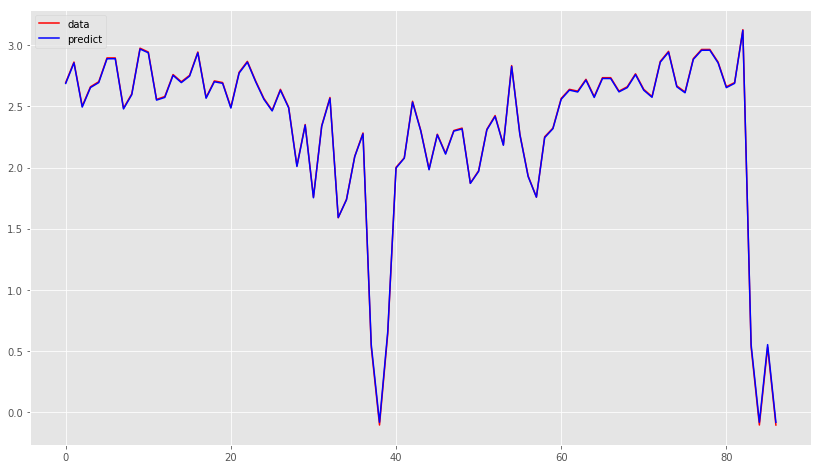

x_scale:  (2, 87, 3, 1)


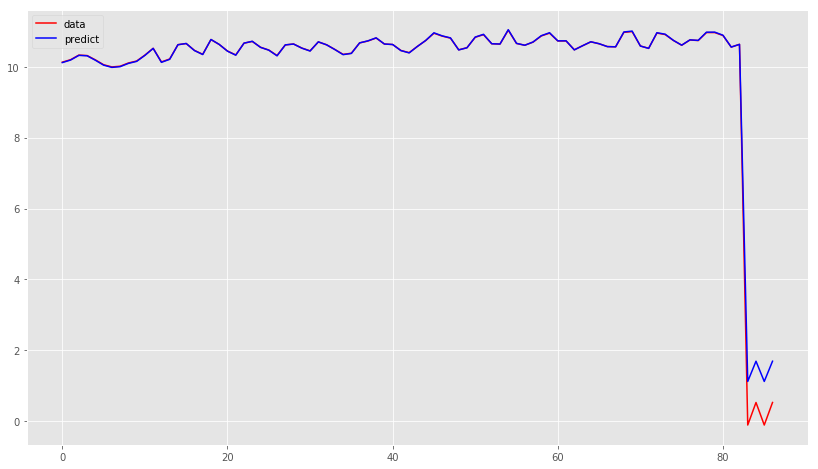

87/87 [==============================] - 0s 65us/step
model evaluate mse: [6.947425809399835, 0.04064272455442911, 6.906783147789966, 0.04064272515390111, 6.906783449238744]


In [21]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

In [22]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.008091519183031418
rmse: 0.17345897760818163
0.09077524839560652


## ヘテロジニアスモデルの事前学習

In [23]:
log_dir = 'model_hetero'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

del model
gc.collect()

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

with timer('train model individual'):
    model.fit(x, x, validation_split=0.1, epochs=1000, 
              callbacks=[tensorboard, hetero_genious_callbacks, early_stop])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 3, 120)       58560       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 3, 150)       91200       input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

135/135 [==============================] - 0s 227us/step - loss: 0.0370 - dense_3_loss: 0.0098 - dense_4_loss: 0.0272 - dense_3_mean_squared_error: 0.0098 - dense_4_mean_squared_error: 0.0272 - val_loss: 0.0701 - val_dense_3_loss: 0.0131 - val_dense_4_loss: 0.0569 - val_dense_3_mean_squared_error: 0.0131 - val_dense_4_mean_squared_error: 0.0569
Epoch 20/1000
135/135 [==============================] - 0s 233us/step - loss: 0.0327 - dense_3_loss: 0.0091 - dense_4_loss: 0.0235 - dense_3_mean_squared_error: 0.0091 - dense_4_mean_squared_error: 0.0235 - val_loss: 0.0668 - val_dense_3_loss: 0.0128 - val_dense_4_loss: 0.0540 - val_dense_3_mean_squared_error: 0.0128 - val_dense_4_mean_squared_error: 0.0540
Epoch 21/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0292 - dense_3_loss: 0.0085 - dense_4_loss: 0.0206 - dense_3_mean_squared_error: 0.0085 - dense_4_mean_squared_error: 0.0206 - val_loss: 0.0639 - val_dense_3_loss: 0.0124 - val_dense_4_loss: 0.0515 - val_dense_3

Epoch 42/1000
135/135 [==============================] - 0s 224us/step - loss: 0.0032 - dense_3_loss: 0.0017 - dense_4_loss: 0.0015 - dense_3_mean_squared_error: 0.0017 - dense_4_mean_squared_error: 0.0015 - val_loss: 0.0385 - val_dense_3_loss: 0.0049 - val_dense_4_loss: 0.0335 - val_dense_3_mean_squared_error: 0.0049 - val_dense_4_mean_squared_error: 0.0335
Epoch 43/1000
135/135 [==============================] - 0s 242us/step - loss: 0.0031 - dense_3_loss: 0.0015 - dense_4_loss: 0.0016 - dense_3_mean_squared_error: 0.0015 - dense_4_mean_squared_error: 0.0016 - val_loss: 0.0382 - val_dense_3_loss: 0.0048 - val_dense_4_loss: 0.0334 - val_dense_3_mean_squared_error: 0.0048 - val_dense_4_mean_squared_error: 0.0334
Epoch 44/1000
135/135 [==============================] - 0s 245us/step - loss: 0.0029 - dense_3_loss: 0.0014 - dense_4_loss: 0.0015 - dense_3_mean_squared_error: 0.0014 - dense_4_mean_squared_error: 0.0015 - val_loss: 0.0379 - val_dense_3_loss: 0.0046 - val_dense_4_loss: 0.0333

135/135 [==============================] - 0s 239us/step - loss: 0.0017 - dense_3_loss: 3.5864e-04 - dense_4_loss: 0.0014 - dense_3_mean_squared_error: 3.5864e-04 - dense_4_mean_squared_error: 0.0014 - val_loss: 0.0312 - val_dense_3_loss: 0.0013 - val_dense_4_loss: 0.0299 - val_dense_3_mean_squared_error: 0.0013 - val_dense_4_mean_squared_error: 0.0299
Epoch 65/1000
135/135 [==============================] - 0s 224us/step - loss: 0.0017 - dense_3_loss: 3.3190e-04 - dense_4_loss: 0.0014 - dense_3_mean_squared_error: 3.3190e-04 - dense_4_mean_squared_error: 0.0014 - val_loss: 0.0308 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0296 - val_dense_3_mean_squared_error: 0.0012 - val_dense_4_mean_squared_error: 0.0296
Epoch 66/1000
135/135 [==============================] - 0s 228us/step - loss: 0.0017 - dense_3_loss: 3.0711e-04 - dense_4_loss: 0.0014 - dense_3_mean_squared_error: 3.0711e-04 - dense_4_mean_squared_error: 0.0014 - val_loss: 0.0305 - val_dense_3_loss: 0.0011 - val_dense_4_lo

Epoch 86/1000
135/135 [==============================] - 0s 216us/step - loss: 0.0012 - dense_3_loss: 5.5163e-05 - dense_4_loss: 0.0012 - dense_3_mean_squared_error: 5.5163e-05 - dense_4_mean_squared_error: 0.0012 - val_loss: 0.0260 - val_dense_3_loss: 1.3758e-04 - val_dense_4_loss: 0.0259 - val_dense_3_mean_squared_error: 1.3758e-04 - val_dense_4_mean_squared_error: 0.0259
Epoch 87/1000
135/135 [==============================] - 0s 214us/step - loss: 0.0012 - dense_3_loss: 5.1017e-05 - dense_4_loss: 0.0012 - dense_3_mean_squared_error: 5.1017e-05 - dense_4_mean_squared_error: 0.0012 - val_loss: 0.0258 - val_dense_3_loss: 1.2466e-04 - val_dense_4_loss: 0.0257 - val_dense_3_mean_squared_error: 1.2466e-04 - val_dense_4_mean_squared_error: 0.0257
Epoch 88/1000
135/135 [==============================] - 0s 224us/step - loss: 0.0012 - dense_3_loss: 4.7738e-05 - dense_4_loss: 0.0012 - dense_3_mean_squared_error: 4.7738e-05 - dense_4_mean_squared_error: 0.0012 - val_loss: 0.0256 - val_dense_3

Epoch 108/1000
135/135 [==============================] - 0s 231us/step - loss: 0.0010 - dense_3_loss: 1.4138e-05 - dense_4_loss: 0.0010 - dense_3_mean_squared_error: 1.4138e-05 - dense_4_mean_squared_error: 0.0010 - val_loss: 0.0223 - val_dense_3_loss: 2.5016e-05 - val_dense_4_loss: 0.0222 - val_dense_3_mean_squared_error: 2.5016e-05 - val_dense_4_mean_squared_error: 0.0222
Epoch 109/1000
135/135 [==============================] - 0s 226us/step - loss: 0.0010 - dense_3_loss: 1.3434e-05 - dense_4_loss: 9.9642e-04 - dense_3_mean_squared_error: 1.3434e-05 - dense_4_mean_squared_error: 9.9642e-04 - val_loss: 0.0221 - val_dense_3_loss: 2.3321e-05 - val_dense_4_loss: 0.0221 - val_dense_3_mean_squared_error: 2.3321e-05 - val_dense_4_mean_squared_error: 0.0221
Epoch 110/1000
135/135 [==============================] - 0s 231us/step - loss: 0.0010 - dense_3_loss: 1.3090e-05 - dense_4_loss: 9.9866e-04 - dense_3_mean_squared_error: 1.3090e-05 - dense_4_mean_squared_error: 9.9866e-04 - val_loss: 0

135/135 [==============================] - 0s 210us/step - loss: 8.7649e-04 - dense_3_loss: 6.6707e-06 - dense_4_loss: 8.6982e-04 - dense_3_mean_squared_error: 6.6707e-06 - dense_4_mean_squared_error: 8.6982e-04 - val_loss: 0.0194 - val_dense_3_loss: 1.0221e-05 - val_dense_4_loss: 0.0194 - val_dense_3_mean_squared_error: 1.0221e-05 - val_dense_4_mean_squared_error: 0.0194
Epoch 130/1000
135/135 [==============================] - 0s 235us/step - loss: 8.7430e-04 - dense_3_loss: 6.5284e-06 - dense_4_loss: 8.6777e-04 - dense_3_mean_squared_error: 6.5284e-06 - dense_4_mean_squared_error: 8.6777e-04 - val_loss: 0.0192 - val_dense_3_loss: 9.8144e-06 - val_dense_4_loss: 0.0192 - val_dense_3_mean_squared_error: 9.8144e-06 - val_dense_4_mean_squared_error: 0.0192
Epoch 131/1000
135/135 [==============================] - 0s 217us/step - loss: 8.6456e-04 - dense_3_loss: 6.3581e-06 - dense_4_loss: 8.5820e-04 - dense_3_mean_squared_error: 6.3581e-06 - dense_4_mean_squared_error: 8.5820e-04 - val_lo

135/135 [==============================] - 0s 249us/step - loss: 7.6048e-04 - dense_3_loss: 4.6548e-06 - dense_4_loss: 7.5583e-04 - dense_3_mean_squared_error: 4.6548e-06 - dense_4_mean_squared_error: 7.5583e-04 - val_loss: 0.0171 - val_dense_3_loss: 6.1751e-06 - val_dense_4_loss: 0.0171 - val_dense_3_mean_squared_error: 6.1751e-06 - val_dense_4_mean_squared_error: 0.0171
Epoch 151/1000
135/135 [==============================] - 0s 228us/step - loss: 7.5308e-04 - dense_3_loss: 4.5952e-06 - dense_4_loss: 7.4849e-04 - dense_3_mean_squared_error: 4.5952e-06 - dense_4_mean_squared_error: 7.4849e-04 - val_loss: 0.0170 - val_dense_3_loss: 6.1768e-06 - val_dense_4_loss: 0.0170 - val_dense_3_mean_squared_error: 6.1768e-06 - val_dense_4_mean_squared_error: 0.0170
Epoch 152/1000
135/135 [==============================] - 0s 242us/step - loss: 7.5101e-04 - dense_3_loss: 4.5572e-06 - dense_4_loss: 7.4646e-04 - dense_3_mean_squared_error: 4.5572e-06 - dense_4_mean_squared_error: 7.4646e-04 - val_lo

135/135 [==============================] - 0s 281us/step - loss: 6.5842e-04 - dense_3_loss: 3.9887e-06 - dense_4_loss: 6.5443e-04 - dense_3_mean_squared_error: 3.9887e-06 - dense_4_mean_squared_error: 6.5443e-04 - val_loss: 0.0153 - val_dense_3_loss: 5.4879e-06 - val_dense_4_loss: 0.0153 - val_dense_3_mean_squared_error: 5.4879e-06 - val_dense_4_mean_squared_error: 0.0153
Epoch 172/1000
135/135 [==============================] - 0s 236us/step - loss: 6.5346e-04 - dense_3_loss: 3.9862e-06 - dense_4_loss: 6.4947e-04 - dense_3_mean_squared_error: 3.9862e-06 - dense_4_mean_squared_error: 6.4947e-04 - val_loss: 0.0153 - val_dense_3_loss: 5.4732e-06 - val_dense_4_loss: 0.0153 - val_dense_3_mean_squared_error: 5.4732e-06 - val_dense_4_mean_squared_error: 0.0153
Epoch 173/1000
135/135 [==============================] - 0s 240us/step - loss: 6.4782e-04 - dense_3_loss: 3.9900e-06 - dense_4_loss: 6.4383e-04 - dense_3_mean_squared_error: 3.9900e-06 - dense_4_mean_squared_error: 6.4383e-04 - val_lo

135/135 [==============================] - 0s 253us/step - loss: 5.8652e-04 - dense_3_loss: 3.7035e-06 - dense_4_loss: 5.8282e-04 - dense_3_mean_squared_error: 3.7035e-06 - dense_4_mean_squared_error: 5.8282e-04 - val_loss: 0.0139 - val_dense_3_loss: 4.8664e-06 - val_dense_4_loss: 0.0139 - val_dense_3_mean_squared_error: 4.8664e-06 - val_dense_4_mean_squared_error: 0.0139
Epoch 193/1000
135/135 [==============================] - 0s 237us/step - loss: 5.7104e-04 - dense_3_loss: 3.6869e-06 - dense_4_loss: 5.6735e-04 - dense_3_mean_squared_error: 3.6869e-06 - dense_4_mean_squared_error: 5.6735e-04 - val_loss: 0.0139 - val_dense_3_loss: 4.9135e-06 - val_dense_4_loss: 0.0139 - val_dense_3_mean_squared_error: 4.9135e-06 - val_dense_4_mean_squared_error: 0.0139
Epoch 194/1000
135/135 [==============================] - 0s 256us/step - loss: 5.7058e-04 - dense_3_loss: 3.6899e-06 - dense_4_loss: 5.6689e-04 - dense_3_mean_squared_error: 3.6899e-06 - dense_4_mean_squared_error: 5.6689e-04 - val_lo

135/135 [==============================] - 0s 239us/step - loss: 4.8775e-04 - dense_3_loss: 3.4710e-06 - dense_4_loss: 4.8428e-04 - dense_3_mean_squared_error: 3.4710e-06 - dense_4_mean_squared_error: 4.8428e-04 - val_loss: 0.0128 - val_dense_3_loss: 4.7845e-06 - val_dense_4_loss: 0.0127 - val_dense_3_mean_squared_error: 4.7845e-06 - val_dense_4_mean_squared_error: 0.0127
Epoch 214/1000
135/135 [==============================] - 0s 241us/step - loss: 4.8279e-04 - dense_3_loss: 3.4805e-06 - dense_4_loss: 4.7931e-04 - dense_3_mean_squared_error: 3.4805e-06 - dense_4_mean_squared_error: 4.7931e-04 - val_loss: 0.0127 - val_dense_3_loss: 4.7266e-06 - val_dense_4_loss: 0.0127 - val_dense_3_mean_squared_error: 4.7266e-06 - val_dense_4_mean_squared_error: 0.0127
Epoch 215/1000
135/135 [==============================] - 0s 243us/step - loss: 4.8047e-04 - dense_3_loss: 3.4473e-06 - dense_4_loss: 4.7702e-04 - dense_3_mean_squared_error: 3.4473e-06 - dense_4_mean_squared_error: 4.7702e-04 - val_lo

135/135 [==============================] - 0s 227us/step - loss: 4.2011e-04 - dense_3_loss: 3.2303e-06 - dense_4_loss: 4.1688e-04 - dense_3_mean_squared_error: 3.2303e-06 - dense_4_mean_squared_error: 4.1688e-04 - val_loss: 0.0116 - val_dense_3_loss: 4.5515e-06 - val_dense_4_loss: 0.0116 - val_dense_3_mean_squared_error: 4.5515e-06 - val_dense_4_mean_squared_error: 0.0116
Epoch 235/1000
135/135 [==============================] - 0s 247us/step - loss: 4.1052e-04 - dense_3_loss: 3.2189e-06 - dense_4_loss: 4.0730e-04 - dense_3_mean_squared_error: 3.2189e-06 - dense_4_mean_squared_error: 4.0730e-04 - val_loss: 0.0117 - val_dense_3_loss: 4.5322e-06 - val_dense_4_loss: 0.0117 - val_dense_3_mean_squared_error: 4.5322e-06 - val_dense_4_mean_squared_error: 0.0117
Epoch 236/1000
135/135 [==============================] - 0s 250us/step - loss: 4.1450e-04 - dense_3_loss: 3.2227e-06 - dense_4_loss: 4.1128e-04 - dense_3_mean_squared_error: 3.2227e-06 - dense_4_mean_squared_error: 4.1128e-04 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 3.5207e-04 - dense_3_loss: 3.0418e-06 - dense_4_loss: 3.4903e-04 - dense_3_mean_squared_error: 3.0418e-06 - dense_4_mean_squared_error: 3.4903e-04 - val_loss: 0.0106 - val_dense_3_loss: 4.1975e-06 - val_dense_4_loss: 0.0106 - val_dense_3_mean_squared_error: 4.1975e-06 - val_dense_4_mean_squared_error: 0.0106
Epoch 256/1000
135/135 [==============================] - 0s 228us/step - loss: 3.4670e-04 - dense_3_loss: 3.0313e-06 - dense_4_loss: 3.4367e-04 - dense_3_mean_squared_error: 3.0313e-06 - dense_4_mean_squared_error: 3.4367e-04 - val_loss: 0.0106 - val_dense_3_loss: 4.2361e-06 - val_dense_4_loss: 0.0106 - val_dense_3_mean_squared_error: 4.2361e-06 - val_dense_4_mean_squared_error: 0.0106
Epoch 257/1000
135/135 [==============================] - 0s 244us/step - loss: 3.4575e-04 - dense_3_loss: 3.0258e-06 - dense_4_loss: 3.4272e-04 - dense_3_mean_squared_error: 3.0258e-06 - dense_4_mean_squared_error: 3.4272e-04 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 2.9527e-04 - dense_3_loss: 2.8356e-06 - dense_4_loss: 2.9244e-04 - dense_3_mean_squared_error: 2.8356e-06 - dense_4_mean_squared_error: 2.9244e-04 - val_loss: 0.0096 - val_dense_3_loss: 4.0115e-06 - val_dense_4_loss: 0.0096 - val_dense_3_mean_squared_error: 4.0115e-06 - val_dense_4_mean_squared_error: 0.0096
Epoch 277/1000
135/135 [==============================] - 0s 246us/step - loss: 2.9081e-04 - dense_3_loss: 2.8061e-06 - dense_4_loss: 2.8800e-04 - dense_3_mean_squared_error: 2.8061e-06 - dense_4_mean_squared_error: 2.8800e-04 - val_loss: 0.0096 - val_dense_3_loss: 3.9828e-06 - val_dense_4_loss: 0.0096 - val_dense_3_mean_squared_error: 3.9828e-06 - val_dense_4_mean_squared_error: 0.0096
Epoch 278/1000
135/135 [==============================] - 0s 236us/step - loss: 2.9030e-04 - dense_3_loss: 2.8120e-06 - dense_4_loss: 2.8748e-04 - dense_3_mean_squared_error: 2.8120e-06 - dense_4_mean_squared_error: 2.8748e-04 - val_lo

Epoch 297/1000
135/135 [==============================] - 0s 273us/step - loss: 2.4057e-04 - dense_3_loss: 2.6457e-06 - dense_4_loss: 2.3792e-04 - dense_3_mean_squared_error: 2.6457e-06 - dense_4_mean_squared_error: 2.3792e-04 - val_loss: 0.0086 - val_dense_3_loss: 3.6381e-06 - val_dense_4_loss: 0.0086 - val_dense_3_mean_squared_error: 3.6381e-06 - val_dense_4_mean_squared_error: 0.0086
Epoch 298/1000
135/135 [==============================] - 0s 263us/step - loss: 2.4454e-04 - dense_3_loss: 2.6357e-06 - dense_4_loss: 2.4191e-04 - dense_3_mean_squared_error: 2.6357e-06 - dense_4_mean_squared_error: 2.4191e-04 - val_loss: 0.0086 - val_dense_3_loss: 3.7000e-06 - val_dense_4_loss: 0.0086 - val_dense_3_mean_squared_error: 3.7000e-06 - val_dense_4_mean_squared_error: 0.0086
Epoch 299/1000
135/135 [==============================] - 0s 241us/step - loss: 2.4201e-04 - dense_3_loss: 2.6287e-06 - dense_4_loss: 2.3938e-04 - dense_3_mean_squared_error: 2.6287e-06 - dense_4_mean_squared_error: 2.39

135/135 [==============================] - 0s 257us/step - loss: 1.9940e-04 - dense_3_loss: 2.4497e-06 - dense_4_loss: 1.9695e-04 - dense_3_mean_squared_error: 2.4497e-06 - dense_4_mean_squared_error: 1.9695e-04 - val_loss: 0.0077 - val_dense_3_loss: 3.5693e-06 - val_dense_4_loss: 0.0077 - val_dense_3_mean_squared_error: 3.5693e-06 - val_dense_4_mean_squared_error: 0.0077
Epoch 319/1000
135/135 [==============================] - 0s 255us/step - loss: 1.9687e-04 - dense_3_loss: 2.4886e-06 - dense_4_loss: 1.9438e-04 - dense_3_mean_squared_error: 2.4886e-06 - dense_4_mean_squared_error: 1.9438e-04 - val_loss: 0.0077 - val_dense_3_loss: 3.5875e-06 - val_dense_4_loss: 0.0077 - val_dense_3_mean_squared_error: 3.5875e-06 - val_dense_4_mean_squared_error: 0.0077
Epoch 320/1000
135/135 [==============================] - 0s 236us/step - loss: 1.9501e-04 - dense_3_loss: 2.4887e-06 - dense_4_loss: 1.9252e-04 - dense_3_mean_squared_error: 2.4887e-06 - dense_4_mean_squared_error: 1.9252e-04 - val_lo

135/135 [==============================] - 0s 256us/step - loss: 1.6589e-04 - dense_3_loss: 2.3052e-06 - dense_4_loss: 1.6358e-04 - dense_3_mean_squared_error: 2.3052e-06 - dense_4_mean_squared_error: 1.6358e-04 - val_loss: 0.0069 - val_dense_3_loss: 3.4248e-06 - val_dense_4_loss: 0.0069 - val_dense_3_mean_squared_error: 3.4248e-06 - val_dense_4_mean_squared_error: 0.0069
Epoch 340/1000
135/135 [==============================] - 0s 257us/step - loss: 1.6389e-04 - dense_3_loss: 2.2702e-06 - dense_4_loss: 1.6162e-04 - dense_3_mean_squared_error: 2.2702e-06 - dense_4_mean_squared_error: 1.6162e-04 - val_loss: 0.0068 - val_dense_3_loss: 3.4273e-06 - val_dense_4_loss: 0.0068 - val_dense_3_mean_squared_error: 3.4273e-06 - val_dense_4_mean_squared_error: 0.0068
Epoch 341/1000
135/135 [==============================] - 0s 254us/step - loss: 1.6102e-04 - dense_3_loss: 2.2868e-06 - dense_4_loss: 1.5874e-04 - dense_3_mean_squared_error: 2.2868e-06 - dense_4_mean_squared_error: 1.5874e-04 - val_lo

135/135 [==============================] - 0s 275us/step - loss: 1.3787e-04 - dense_3_loss: 2.1396e-06 - dense_4_loss: 1.3573e-04 - dense_3_mean_squared_error: 2.1396e-06 - dense_4_mean_squared_error: 1.3573e-04 - val_loss: 0.0061 - val_dense_3_loss: 3.3074e-06 - val_dense_4_loss: 0.0061 - val_dense_3_mean_squared_error: 3.3074e-06 - val_dense_4_mean_squared_error: 0.0061
Epoch 361/1000
135/135 [==============================] - 0s 237us/step - loss: 1.3475e-04 - dense_3_loss: 2.1364e-06 - dense_4_loss: 1.3261e-04 - dense_3_mean_squared_error: 2.1364e-06 - dense_4_mean_squared_error: 1.3261e-04 - val_loss: 0.0061 - val_dense_3_loss: 3.3140e-06 - val_dense_4_loss: 0.0061 - val_dense_3_mean_squared_error: 3.3140e-06 - val_dense_4_mean_squared_error: 0.0061
Epoch 362/1000
135/135 [==============================] - 0s 241us/step - loss: 1.3288e-04 - dense_3_loss: 2.1094e-06 - dense_4_loss: 1.3077e-04 - dense_3_mean_squared_error: 2.1094e-06 - dense_4_mean_squared_error: 1.3077e-04 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 1.1611e-04 - dense_3_loss: 1.9636e-06 - dense_4_loss: 1.1415e-04 - dense_3_mean_squared_error: 1.9636e-06 - dense_4_mean_squared_error: 1.1415e-04 - val_loss: 0.0055 - val_dense_3_loss: 2.8831e-06 - val_dense_4_loss: 0.0055 - val_dense_3_mean_squared_error: 2.8831e-06 - val_dense_4_mean_squared_error: 0.0055
Epoch 382/1000
135/135 [==============================] - 0s 242us/step - loss: 1.1584e-04 - dense_3_loss: 1.9707e-06 - dense_4_loss: 1.1387e-04 - dense_3_mean_squared_error: 1.9707e-06 - dense_4_mean_squared_error: 1.1387e-04 - val_loss: 0.0054 - val_dense_3_loss: 2.9245e-06 - val_dense_4_loss: 0.0054 - val_dense_3_mean_squared_error: 2.9245e-06 - val_dense_4_mean_squared_error: 0.0054
Epoch 383/1000
135/135 [==============================] - 0s 242us/step - loss: 1.1323e-04 - dense_3_loss: 1.9745e-06 - dense_4_loss: 1.1126e-04 - dense_3_mean_squared_error: 1.9745e-06 - dense_4_mean_squared_error: 1.1126e-04 - val_lo

135/135 [==============================] - 0s 228us/step - loss: 9.5858e-05 - dense_3_loss: 1.8559e-06 - dense_4_loss: 9.4003e-05 - dense_3_mean_squared_error: 1.8559e-06 - dense_4_mean_squared_error: 9.4003e-05 - val_loss: 0.0049 - val_dense_3_loss: 2.8552e-06 - val_dense_4_loss: 0.0049 - val_dense_3_mean_squared_error: 2.8552e-06 - val_dense_4_mean_squared_error: 0.0049
Epoch 403/1000
135/135 [==============================] - 0s 227us/step - loss: 9.4667e-05 - dense_3_loss: 1.8318e-06 - dense_4_loss: 9.2835e-05 - dense_3_mean_squared_error: 1.8318e-06 - dense_4_mean_squared_error: 9.2835e-05 - val_loss: 0.0049 - val_dense_3_loss: 2.7871e-06 - val_dense_4_loss: 0.0049 - val_dense_3_mean_squared_error: 2.7871e-06 - val_dense_4_mean_squared_error: 0.0049
Epoch 404/1000
135/135 [==============================] - 0s 227us/step - loss: 9.5660e-05 - dense_3_loss: 1.8220e-06 - dense_4_loss: 9.3838e-05 - dense_3_mean_squared_error: 1.8220e-06 - dense_4_mean_squared_error: 9.3838e-05 - val_lo

135/135 [==============================] - 0s 238us/step - loss: 7.7374e-05 - dense_3_loss: 1.7074e-06 - dense_4_loss: 7.5667e-05 - dense_3_mean_squared_error: 1.7074e-06 - dense_4_mean_squared_error: 7.5667e-05 - val_loss: 0.0045 - val_dense_3_loss: 2.5762e-06 - val_dense_4_loss: 0.0045 - val_dense_3_mean_squared_error: 2.5762e-06 - val_dense_4_mean_squared_error: 0.0045
Epoch 424/1000
135/135 [==============================] - 0s 242us/step - loss: 7.5883e-05 - dense_3_loss: 1.7217e-06 - dense_4_loss: 7.4162e-05 - dense_3_mean_squared_error: 1.7217e-06 - dense_4_mean_squared_error: 7.4162e-05 - val_loss: 0.0044 - val_dense_3_loss: 2.6307e-06 - val_dense_4_loss: 0.0044 - val_dense_3_mean_squared_error: 2.6307e-06 - val_dense_4_mean_squared_error: 0.0044
Epoch 425/1000
135/135 [==============================] - 0s 236us/step - loss: 7.6124e-05 - dense_3_loss: 1.6780e-06 - dense_4_loss: 7.4446e-05 - dense_3_mean_squared_error: 1.6780e-06 - dense_4_mean_squared_error: 7.4446e-05 - val_lo

135/135 [==============================] - 0s 225us/step - loss: 6.2619e-05 - dense_3_loss: 1.5623e-06 - dense_4_loss: 6.1057e-05 - dense_3_mean_squared_error: 1.5623e-06 - dense_4_mean_squared_error: 6.1057e-05 - val_loss: 0.0041 - val_dense_3_loss: 2.5769e-06 - val_dense_4_loss: 0.0041 - val_dense_3_mean_squared_error: 2.5769e-06 - val_dense_4_mean_squared_error: 0.0041
Epoch 445/1000
135/135 [==============================] - 0s 238us/step - loss: 6.1488e-05 - dense_3_loss: 1.5823e-06 - dense_4_loss: 5.9905e-05 - dense_3_mean_squared_error: 1.5823e-06 - dense_4_mean_squared_error: 5.9905e-05 - val_loss: 0.0041 - val_dense_3_loss: 2.5600e-06 - val_dense_4_loss: 0.0041 - val_dense_3_mean_squared_error: 2.5600e-06 - val_dense_4_mean_squared_error: 0.0041
Epoch 446/1000
135/135 [==============================] - 0s 248us/step - loss: 6.0839e-05 - dense_3_loss: 1.5650e-06 - dense_4_loss: 5.9274e-05 - dense_3_mean_squared_error: 1.5650e-06 - dense_4_mean_squared_error: 5.9274e-05 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 5.0923e-05 - dense_3_loss: 1.4585e-06 - dense_4_loss: 4.9465e-05 - dense_3_mean_squared_error: 1.4585e-06 - dense_4_mean_squared_error: 4.9465e-05 - val_loss: 0.0037 - val_dense_3_loss: 2.4403e-06 - val_dense_4_loss: 0.0037 - val_dense_3_mean_squared_error: 2.4403e-06 - val_dense_4_mean_squared_error: 0.0037
Epoch 466/1000
135/135 [==============================] - 0s 225us/step - loss: 5.0786e-05 - dense_3_loss: 1.4473e-06 - dense_4_loss: 4.9339e-05 - dense_3_mean_squared_error: 1.4473e-06 - dense_4_mean_squared_error: 4.9339e-05 - val_loss: 0.0037 - val_dense_3_loss: 2.3476e-06 - val_dense_4_loss: 0.0037 - val_dense_3_mean_squared_error: 2.3476e-06 - val_dense_4_mean_squared_error: 0.0037
Epoch 467/1000
135/135 [==============================] - 0s 234us/step - loss: 5.0418e-05 - dense_3_loss: 1.4455e-06 - dense_4_loss: 4.8972e-05 - dense_3_mean_squared_error: 1.4455e-06 - dense_4_mean_squared_error: 4.8972e-05 - val_lo

135/135 [==============================] - 0s 245us/step - loss: 4.2182e-05 - dense_3_loss: 1.3685e-06 - dense_4_loss: 4.0814e-05 - dense_3_mean_squared_error: 1.3685e-06 - dense_4_mean_squared_error: 4.0814e-05 - val_loss: 0.0034 - val_dense_3_loss: 2.1050e-06 - val_dense_4_loss: 0.0034 - val_dense_3_mean_squared_error: 2.1050e-06 - val_dense_4_mean_squared_error: 0.0034
Epoch 487/1000
135/135 [==============================] - 0s 240us/step - loss: 4.2936e-05 - dense_3_loss: 1.3470e-06 - dense_4_loss: 4.1589e-05 - dense_3_mean_squared_error: 1.3470e-06 - dense_4_mean_squared_error: 4.1589e-05 - val_loss: 0.0034 - val_dense_3_loss: 2.1510e-06 - val_dense_4_loss: 0.0034 - val_dense_3_mean_squared_error: 2.1510e-06 - val_dense_4_mean_squared_error: 0.0034
Epoch 488/1000
135/135 [==============================] - 0s 240us/step - loss: 4.2111e-05 - dense_3_loss: 1.3416e-06 - dense_4_loss: 4.0769e-05 - dense_3_mean_squared_error: 1.3416e-06 - dense_4_mean_squared_error: 4.0769e-05 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 3.3924e-05 - dense_3_loss: 1.2565e-06 - dense_4_loss: 3.2667e-05 - dense_3_mean_squared_error: 1.2565e-06 - dense_4_mean_squared_error: 3.2667e-05 - val_loss: 0.0031 - val_dense_3_loss: 2.0683e-06 - val_dense_4_loss: 0.0031 - val_dense_3_mean_squared_error: 2.0683e-06 - val_dense_4_mean_squared_error: 0.0031
Epoch 508/1000
135/135 [==============================] - 0s 236us/step - loss: 3.4302e-05 - dense_3_loss: 1.3277e-06 - dense_4_loss: 3.2974e-05 - dense_3_mean_squared_error: 1.3277e-06 - dense_4_mean_squared_error: 3.2974e-05 - val_loss: 0.0031 - val_dense_3_loss: 2.3104e-06 - val_dense_4_loss: 0.0031 - val_dense_3_mean_squared_error: 2.3104e-06 - val_dense_4_mean_squared_error: 0.0031
Epoch 509/1000
135/135 [==============================] - 0s 242us/step - loss: 3.4136e-05 - dense_3_loss: 1.2720e-06 - dense_4_loss: 3.2864e-05 - dense_3_mean_squared_error: 1.2720e-06 - dense_4_mean_squared_error: 3.2864e-05 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 2.7651e-05 - dense_3_loss: 1.1290e-06 - dense_4_loss: 2.6522e-05 - dense_3_mean_squared_error: 1.1290e-06 - dense_4_mean_squared_error: 2.6522e-05 - val_loss: 0.0028 - val_dense_3_loss: 1.8993e-06 - val_dense_4_loss: 0.0028 - val_dense_3_mean_squared_error: 1.8993e-06 - val_dense_4_mean_squared_error: 0.0028
Epoch 529/1000
135/135 [==============================] - 0s 231us/step - loss: 2.7024e-05 - dense_3_loss: 1.1445e-06 - dense_4_loss: 2.5879e-05 - dense_3_mean_squared_error: 1.1445e-06 - dense_4_mean_squared_error: 2.5879e-05 - val_loss: 0.0028 - val_dense_3_loss: 1.8862e-06 - val_dense_4_loss: 0.0028 - val_dense_3_mean_squared_error: 1.8862e-06 - val_dense_4_mean_squared_error: 0.0028
Epoch 530/1000
135/135 [==============================] - 0s 249us/step - loss: 2.7620e-05 - dense_3_loss: 1.1290e-06 - dense_4_loss: 2.6491e-05 - dense_3_mean_squared_error: 1.1290e-06 - dense_4_mean_squared_error: 2.6491e-05 - val_lo

135/135 [==============================] - 0s 270us/step - loss: 2.2366e-05 - dense_3_loss: 1.0398e-06 - dense_4_loss: 2.1327e-05 - dense_3_mean_squared_error: 1.0398e-06 - dense_4_mean_squared_error: 2.1327e-05 - val_loss: 0.0026 - val_dense_3_loss: 1.7738e-06 - val_dense_4_loss: 0.0026 - val_dense_3_mean_squared_error: 1.7738e-06 - val_dense_4_mean_squared_error: 0.0026
Epoch 550/1000
135/135 [==============================] - 0s 262us/step - loss: 2.2209e-05 - dense_3_loss: 1.0286e-06 - dense_4_loss: 2.1180e-05 - dense_3_mean_squared_error: 1.0286e-06 - dense_4_mean_squared_error: 2.1180e-05 - val_loss: 0.0026 - val_dense_3_loss: 1.7539e-06 - val_dense_4_loss: 0.0026 - val_dense_3_mean_squared_error: 1.7539e-06 - val_dense_4_mean_squared_error: 0.0026
Epoch 551/1000
135/135 [==============================] - 0s 280us/step - loss: 2.2082e-05 - dense_3_loss: 1.0374e-06 - dense_4_loss: 2.1045e-05 - dense_3_mean_squared_error: 1.0374e-06 - dense_4_mean_squared_error: 2.1045e-05 - val_lo

135/135 [==============================] - 0s 251us/step - loss: 1.7841e-05 - dense_3_loss: 9.5011e-07 - dense_4_loss: 1.6890e-05 - dense_3_mean_squared_error: 9.5011e-07 - dense_4_mean_squared_error: 1.6890e-05 - val_loss: 0.0024 - val_dense_3_loss: 1.8555e-06 - val_dense_4_loss: 0.0024 - val_dense_3_mean_squared_error: 1.8555e-06 - val_dense_4_mean_squared_error: 0.0024
Epoch 571/1000
135/135 [==============================] - 0s 241us/step - loss: 1.7815e-05 - dense_3_loss: 9.4414e-07 - dense_4_loss: 1.6870e-05 - dense_3_mean_squared_error: 9.4414e-07 - dense_4_mean_squared_error: 1.6870e-05 - val_loss: 0.0024 - val_dense_3_loss: 1.7964e-06 - val_dense_4_loss: 0.0024 - val_dense_3_mean_squared_error: 1.7964e-06 - val_dense_4_mean_squared_error: 0.0024
Epoch 572/1000
135/135 [==============================] - 0s 242us/step - loss: 1.7586e-05 - dense_3_loss: 9.5621e-07 - dense_4_loss: 1.6630e-05 - dense_3_mean_squared_error: 9.5621e-07 - dense_4_mean_squared_error: 1.6630e-05 - val_lo

Epoch 591/1000
135/135 [==============================] - 0s 220us/step - loss: 1.4283e-05 - dense_3_loss: 9.0433e-07 - dense_4_loss: 1.3378e-05 - dense_3_mean_squared_error: 9.0433e-07 - dense_4_mean_squared_error: 1.3378e-05 - val_loss: 0.0022 - val_dense_3_loss: 1.7069e-06 - val_dense_4_loss: 0.0022 - val_dense_3_mean_squared_error: 1.7069e-06 - val_dense_4_mean_squared_error: 0.0022
Epoch 592/1000
135/135 [==============================] - 0s 223us/step - loss: 1.4057e-05 - dense_3_loss: 8.7309e-07 - dense_4_loss: 1.3184e-05 - dense_3_mean_squared_error: 8.7309e-07 - dense_4_mean_squared_error: 1.3184e-05 - val_loss: 0.0022 - val_dense_3_loss: 1.7246e-06 - val_dense_4_loss: 0.0022 - val_dense_3_mean_squared_error: 1.7246e-06 - val_dense_4_mean_squared_error: 0.0022
Epoch 593/1000
135/135 [==============================] - 0s 221us/step - loss: 1.3970e-05 - dense_3_loss: 8.6599e-07 - dense_4_loss: 1.3104e-05 - dense_3_mean_squared_error: 8.6599e-07 - dense_4_mean_squared_error: 1.31

135/135 [==============================] - 0s 249us/step - loss: 1.1980e-05 - dense_3_loss: 8.3568e-07 - dense_4_loss: 1.1144e-05 - dense_3_mean_squared_error: 8.3568e-07 - dense_4_mean_squared_error: 1.1144e-05 - val_loss: 0.0021 - val_dense_3_loss: 1.4391e-06 - val_dense_4_loss: 0.0021 - val_dense_3_mean_squared_error: 1.4391e-06 - val_dense_4_mean_squared_error: 0.0021
Epoch 613/1000
135/135 [==============================] - 0s 249us/step - loss: 1.1615e-05 - dense_3_loss: 8.0919e-07 - dense_4_loss: 1.0806e-05 - dense_3_mean_squared_error: 8.0919e-07 - dense_4_mean_squared_error: 1.0806e-05 - val_loss: 0.0021 - val_dense_3_loss: 1.4622e-06 - val_dense_4_loss: 0.0021 - val_dense_3_mean_squared_error: 1.4622e-06 - val_dense_4_mean_squared_error: 0.0021
Epoch 614/1000
135/135 [==============================] - 0s 254us/step - loss: 1.1527e-05 - dense_3_loss: 8.1456e-07 - dense_4_loss: 1.0712e-05 - dense_3_mean_squared_error: 8.1456e-07 - dense_4_mean_squared_error: 1.0712e-05 - val_lo

135/135 [==============================] - 0s 213us/step - loss: 9.6477e-06 - dense_3_loss: 7.5808e-07 - dense_4_loss: 8.8896e-06 - dense_3_mean_squared_error: 7.5808e-07 - dense_4_mean_squared_error: 8.8896e-06 - val_loss: 0.0019 - val_dense_3_loss: 1.5018e-06 - val_dense_4_loss: 0.0019 - val_dense_3_mean_squared_error: 1.5018e-06 - val_dense_4_mean_squared_error: 0.0019
Epoch 634/1000
135/135 [==============================] - 0s 232us/step - loss: 9.9037e-06 - dense_3_loss: 7.8463e-07 - dense_4_loss: 9.1190e-06 - dense_3_mean_squared_error: 7.8463e-07 - dense_4_mean_squared_error: 9.1190e-06 - val_loss: 0.0019 - val_dense_3_loss: 1.3677e-06 - val_dense_4_loss: 0.0019 - val_dense_3_mean_squared_error: 1.3677e-06 - val_dense_4_mean_squared_error: 0.0019
Epoch 635/1000
135/135 [==============================] - 0s 235us/step - loss: 1.1038e-05 - dense_3_loss: 7.5630e-07 - dense_4_loss: 1.0282e-05 - dense_3_mean_squared_error: 7.5630e-07 - dense_4_mean_squared_error: 1.0282e-05 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 8.4422e-06 - dense_3_loss: 7.0765e-07 - dense_4_loss: 7.7345e-06 - dense_3_mean_squared_error: 7.0765e-07 - dense_4_mean_squared_error: 7.7345e-06 - val_loss: 0.0018 - val_dense_3_loss: 1.2925e-06 - val_dense_4_loss: 0.0018 - val_dense_3_mean_squared_error: 1.2925e-06 - val_dense_4_mean_squared_error: 0.0018
Epoch 655/1000
135/135 [==============================] - 0s 232us/step - loss: 9.1001e-06 - dense_3_loss: 6.8071e-07 - dense_4_loss: 8.4194e-06 - dense_3_mean_squared_error: 6.8071e-07 - dense_4_mean_squared_error: 8.4194e-06 - val_loss: 0.0018 - val_dense_3_loss: 1.1618e-06 - val_dense_4_loss: 0.0018 - val_dense_3_mean_squared_error: 1.1618e-06 - val_dense_4_mean_squared_error: 0.0018
Epoch 656/1000
135/135 [==============================] - 0s 253us/step - loss: 8.9252e-06 - dense_3_loss: 7.0442e-07 - dense_4_loss: 8.2207e-06 - dense_3_mean_squared_error: 7.0442e-07 - dense_4_mean_squared_error: 8.2207e-06 - val_lo

135/135 [==============================] - 0s 233us/step - loss: 7.0430e-06 - dense_3_loss: 6.0765e-07 - dense_4_loss: 6.4354e-06 - dense_3_mean_squared_error: 6.0765e-07 - dense_4_mean_squared_error: 6.4354e-06 - val_loss: 0.0017 - val_dense_3_loss: 1.2192e-06 - val_dense_4_loss: 0.0017 - val_dense_3_mean_squared_error: 1.2192e-06 - val_dense_4_mean_squared_error: 0.0017
Epoch 676/1000
135/135 [==============================] - 0s 232us/step - loss: 7.4416e-06 - dense_3_loss: 6.1631e-07 - dense_4_loss: 6.8253e-06 - dense_3_mean_squared_error: 6.1631e-07 - dense_4_mean_squared_error: 6.8253e-06 - val_loss: 0.0017 - val_dense_3_loss: 1.1357e-06 - val_dense_4_loss: 0.0017 - val_dense_3_mean_squared_error: 1.1357e-06 - val_dense_4_mean_squared_error: 0.0017
Epoch 677/1000
135/135 [==============================] - 0s 235us/step - loss: 6.8452e-06 - dense_3_loss: 6.2226e-07 - dense_4_loss: 6.2230e-06 - dense_3_mean_squared_error: 6.2226e-07 - dense_4_mean_squared_error: 6.2230e-06 - val_lo

135/135 [==============================] - 0s 235us/step - loss: 5.4559e-06 - dense_3_loss: 5.6498e-07 - dense_4_loss: 4.8909e-06 - dense_3_mean_squared_error: 5.6498e-07 - dense_4_mean_squared_error: 4.8909e-06 - val_loss: 0.0016 - val_dense_3_loss: 1.0607e-06 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 1.0607e-06 - val_dense_4_mean_squared_error: 0.0016
Epoch 697/1000
135/135 [==============================] - 0s 247us/step - loss: 5.1798e-06 - dense_3_loss: 5.6495e-07 - dense_4_loss: 4.6148e-06 - dense_3_mean_squared_error: 5.6495e-07 - dense_4_mean_squared_error: 4.6148e-06 - val_loss: 0.0016 - val_dense_3_loss: 1.0729e-06 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 1.0729e-06 - val_dense_4_mean_squared_error: 0.0016
Epoch 698/1000
135/135 [==============================] - 0s 243us/step - loss: 5.0931e-06 - dense_3_loss: 5.6002e-07 - dense_4_loss: 4.5331e-06 - dense_3_mean_squared_error: 5.6002e-07 - dense_4_mean_squared_error: 4.5331e-06 - val_lo

135/135 [==============================] - 0s 243us/step - loss: 5.3632e-06 - dense_3_loss: 5.0161e-07 - dense_4_loss: 4.8616e-06 - dense_3_mean_squared_error: 5.0161e-07 - dense_4_mean_squared_error: 4.8616e-06 - val_loss: 0.0015 - val_dense_3_loss: 1.0771e-06 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 1.0771e-06 - val_dense_4_mean_squared_error: 0.0015
Epoch 718/1000
135/135 [==============================] - 0s 243us/step - loss: 5.4351e-06 - dense_3_loss: 5.0606e-07 - dense_4_loss: 4.9290e-06 - dense_3_mean_squared_error: 5.0606e-07 - dense_4_mean_squared_error: 4.9290e-06 - val_loss: 0.0015 - val_dense_3_loss: 1.1042e-06 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 1.1042e-06 - val_dense_4_mean_squared_error: 0.0015
Epoch 719/1000
135/135 [==============================] - 0s 226us/step - loss: 4.9717e-06 - dense_3_loss: 4.9954e-07 - dense_4_loss: 4.4722e-06 - dense_3_mean_squared_error: 4.9954e-07 - dense_4_mean_squared_error: 4.4722e-06 - val_lo

Epoch 738/1000
135/135 [==============================] - 0s 228us/step - loss: 3.7961e-06 - dense_3_loss: 4.6503e-07 - dense_4_loss: 3.3311e-06 - dense_3_mean_squared_error: 4.6503e-07 - dense_4_mean_squared_error: 3.3311e-06 - val_loss: 0.0015 - val_dense_3_loss: 1.0196e-06 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 1.0196e-06 - val_dense_4_mean_squared_error: 0.0015
Epoch 739/1000
135/135 [==============================] - 0s 230us/step - loss: 3.9854e-06 - dense_3_loss: 4.7564e-07 - dense_4_loss: 3.5097e-06 - dense_3_mean_squared_error: 4.7564e-07 - dense_4_mean_squared_error: 3.5097e-06 - val_loss: 0.0015 - val_dense_3_loss: 1.1277e-06 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 1.1277e-06 - val_dense_4_mean_squared_error: 0.0015
Epoch 740/1000
135/135 [==============================] - 0s 234us/step - loss: 3.8547e-06 - dense_3_loss: 4.6968e-07 - dense_4_loss: 3.3850e-06 - dense_3_mean_squared_error: 4.6968e-07 - dense_4_mean_squared_error: 3.38

135/135 [==============================] - 0s 228us/step - loss: 4.0620e-06 - dense_3_loss: 4.2263e-07 - dense_4_loss: 3.6394e-06 - dense_3_mean_squared_error: 4.2263e-07 - dense_4_mean_squared_error: 3.6394e-06 - val_loss: 0.0014 - val_dense_3_loss: 9.5146e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 9.5146e-07 - val_dense_4_mean_squared_error: 0.0014
Epoch 760/1000
135/135 [==============================] - 0s 245us/step - loss: 3.9629e-06 - dense_3_loss: 4.3785e-07 - dense_4_loss: 3.5251e-06 - dense_3_mean_squared_error: 4.3785e-07 - dense_4_mean_squared_error: 3.5251e-06 - val_loss: 0.0014 - val_dense_3_loss: 9.2474e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 9.2474e-07 - val_dense_4_mean_squared_error: 0.0014
Epoch 761/1000
135/135 [==============================] - 0s 211us/step - loss: 4.1902e-06 - dense_3_loss: 4.3202e-07 - dense_4_loss: 3.7582e-06 - dense_3_mean_squared_error: 4.3202e-07 - dense_4_mean_squared_error: 3.7582e-06 - val_lo

135/135 [==============================] - 0s 245us/step - loss: 3.1541e-06 - dense_3_loss: 4.2162e-07 - dense_4_loss: 2.7325e-06 - dense_3_mean_squared_error: 4.2162e-07 - dense_4_mean_squared_error: 2.7325e-06 - val_loss: 0.0013 - val_dense_3_loss: 9.0990e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 9.0990e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 781/1000
135/135 [==============================] - 0s 255us/step - loss: 3.1399e-06 - dense_3_loss: 4.2104e-07 - dense_4_loss: 2.7189e-06 - dense_3_mean_squared_error: 4.2104e-07 - dense_4_mean_squared_error: 2.7189e-06 - val_loss: 0.0014 - val_dense_3_loss: 9.3160e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 9.3160e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 782/1000
135/135 [==============================] - 0s 248us/step - loss: 3.0294e-06 - dense_3_loss: 4.0554e-07 - dense_4_loss: 2.6238e-06 - dense_3_mean_squared_error: 4.0554e-07 - dense_4_mean_squared_error: 2.6238e-06 - val_lo

135/135 [==============================] - 0s 258us/step - loss: 3.1545e-06 - dense_3_loss: 3.5941e-07 - dense_4_loss: 2.7951e-06 - dense_3_mean_squared_error: 3.5941e-07 - dense_4_mean_squared_error: 2.7951e-06 - val_loss: 0.0013 - val_dense_3_loss: 7.7516e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 7.7516e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 802/1000
135/135 [==============================] - 0s 277us/step - loss: 2.6969e-06 - dense_3_loss: 3.6232e-07 - dense_4_loss: 2.3346e-06 - dense_3_mean_squared_error: 3.6232e-07 - dense_4_mean_squared_error: 2.3346e-06 - val_loss: 0.0013 - val_dense_3_loss: 9.2528e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 9.2528e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 803/1000
135/135 [==============================] - 0s 243us/step - loss: 2.7312e-06 - dense_3_loss: 3.8857e-07 - dense_4_loss: 2.3426e-06 - dense_3_mean_squared_error: 3.8857e-07 - dense_4_mean_squared_error: 2.3426e-06 - val_lo

135/135 [==============================] - 0s 232us/step - loss: 2.3620e-06 - dense_3_loss: 3.2878e-07 - dense_4_loss: 2.0332e-06 - dense_3_mean_squared_error: 3.2878e-07 - dense_4_mean_squared_error: 2.0332e-06 - val_loss: 0.0013 - val_dense_3_loss: 7.1935e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 7.1935e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 823/1000
135/135 [==============================] - 0s 234us/step - loss: 2.1328e-06 - dense_3_loss: 3.2873e-07 - dense_4_loss: 1.8041e-06 - dense_3_mean_squared_error: 3.2873e-07 - dense_4_mean_squared_error: 1.8041e-06 - val_loss: 0.0013 - val_dense_3_loss: 7.6819e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 7.6819e-07 - val_dense_4_mean_squared_error: 0.0013
Epoch 824/1000
135/135 [==============================] - 0s 241us/step - loss: 2.3327e-06 - dense_3_loss: 3.1701e-07 - dense_4_loss: 2.0157e-06 - dense_3_mean_squared_error: 3.1701e-07 - dense_4_mean_squared_error: 2.0157e-06 - val_lo

135/135 [==============================] - 0s 224us/step - loss: 3.3481e-06 - dense_3_loss: 2.9540e-07 - dense_4_loss: 3.0527e-06 - dense_3_mean_squared_error: 2.9540e-07 - dense_4_mean_squared_error: 3.0527e-06 - val_loss: 0.0012 - val_dense_3_loss: 7.9932e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 7.9932e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 844/1000
135/135 [==============================] - 0s 219us/step - loss: 2.4914e-06 - dense_3_loss: 3.0002e-07 - dense_4_loss: 2.1914e-06 - dense_3_mean_squared_error: 3.0002e-07 - dense_4_mean_squared_error: 2.1914e-06 - val_loss: 0.0012 - val_dense_3_loss: 7.8149e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 7.8149e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 845/1000
135/135 [==============================] - 0s 237us/step - loss: 2.2620e-06 - dense_3_loss: 2.9965e-07 - dense_4_loss: 1.9623e-06 - dense_3_mean_squared_error: 2.9965e-07 - dense_4_mean_squared_error: 1.9623e-06 - val_lo

135/135 [==============================] - 0s 238us/step - loss: 3.0452e-06 - dense_3_loss: 2.8577e-07 - dense_4_loss: 2.7594e-06 - dense_3_mean_squared_error: 2.8577e-07 - dense_4_mean_squared_error: 2.7594e-06 - val_loss: 0.0012 - val_dense_3_loss: 7.1668e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 7.1668e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 865/1000
135/135 [==============================] - 0s 229us/step - loss: 5.4372e-06 - dense_3_loss: 2.7968e-07 - dense_4_loss: 5.1575e-06 - dense_3_mean_squared_error: 2.7968e-07 - dense_4_mean_squared_error: 5.1575e-06 - val_loss: 0.0012 - val_dense_3_loss: 5.7455e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 5.7455e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 866/1000
135/135 [==============================] - 0s 235us/step - loss: 3.2338e-06 - dense_3_loss: 2.7617e-07 - dense_4_loss: 2.9576e-06 - dense_3_mean_squared_error: 2.7617e-07 - dense_4_mean_squared_error: 2.9576e-06 - val_lo

135/135 [==============================] - 0s 256us/step - loss: 1.9274e-06 - dense_3_loss: 2.6267e-07 - dense_4_loss: 1.6647e-06 - dense_3_mean_squared_error: 2.6267e-07 - dense_4_mean_squared_error: 1.6647e-06 - val_loss: 0.0012 - val_dense_3_loss: 6.0143e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 6.0143e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 886/1000
135/135 [==============================] - 0s 236us/step - loss: 1.8487e-06 - dense_3_loss: 3.0347e-07 - dense_4_loss: 1.5453e-06 - dense_3_mean_squared_error: 3.0347e-07 - dense_4_mean_squared_error: 1.5453e-06 - val_loss: 0.0012 - val_dense_3_loss: 6.4168e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 6.4168e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 887/1000
135/135 [==============================] - 0s 243us/step - loss: 1.9494e-06 - dense_3_loss: 3.0079e-07 - dense_4_loss: 1.6486e-06 - dense_3_mean_squared_error: 3.0079e-07 - dense_4_mean_squared_error: 1.6486e-06 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 1.5434e-06 - dense_3_loss: 2.3184e-07 - dense_4_loss: 1.3115e-06 - dense_3_mean_squared_error: 2.3184e-07 - dense_4_mean_squared_error: 1.3115e-06 - val_loss: 0.0012 - val_dense_3_loss: 5.1561e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 5.1561e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 907/1000
135/135 [==============================] - 0s 208us/step - loss: 1.8726e-06 - dense_3_loss: 2.2629e-07 - dense_4_loss: 1.6464e-06 - dense_3_mean_squared_error: 2.2629e-07 - dense_4_mean_squared_error: 1.6464e-06 - val_loss: 0.0012 - val_dense_3_loss: 5.7054e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 5.7054e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 908/1000
135/135 [==============================] - 0s 214us/step - loss: 2.1770e-06 - dense_3_loss: 2.2756e-07 - dense_4_loss: 1.9495e-06 - dense_3_mean_squared_error: 2.2756e-07 - dense_4_mean_squared_error: 1.9495e-06 - val_lo

135/135 [==============================] - 0s 246us/step - loss: 2.0574e-06 - dense_3_loss: 2.2935e-07 - dense_4_loss: 1.8281e-06 - dense_3_mean_squared_error: 2.2935e-07 - dense_4_mean_squared_error: 1.8281e-06 - val_loss: 0.0012 - val_dense_3_loss: 4.0784e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 4.0784e-07 - val_dense_4_mean_squared_error: 0.0012
Epoch 928/1000
135/135 [==============================] - 0s 243us/step - loss: 3.9528e-06 - dense_3_loss: 2.2561e-07 - dense_4_loss: 3.7272e-06 - dense_3_mean_squared_error: 2.2561e-07 - dense_4_mean_squared_error: 3.7272e-06 - val_loss: 0.0012 - val_dense_3_loss: 3.7334e-07 - val_dense_4_loss: 0.0012 - val_dense_3_mean_squared_error: 3.7334e-07 - val_dense_4_mean_squared_error: 0.0012
hetero genious class weight {0: 1.0, 1: 9.777907252136327}
train model individual - done in 35.8133518696s


(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.2306549549s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2516241669654846
Inverse
after max 2.8502867221832275
x_scale:  (2, 87, 3, 1)


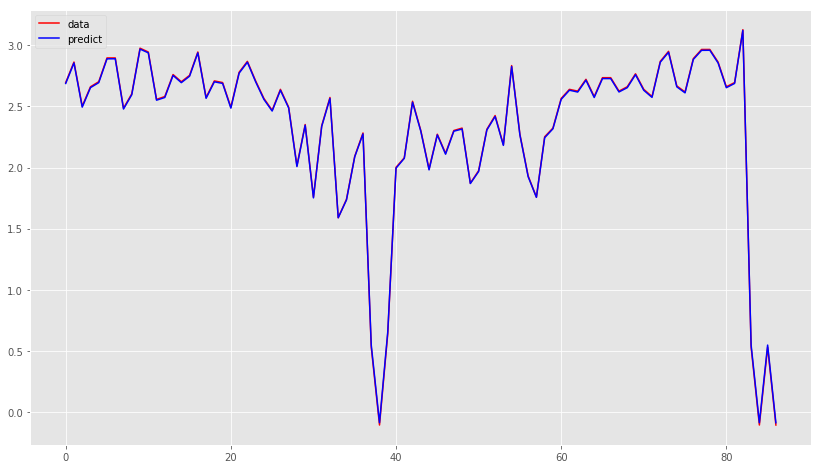

x_scale:  (2, 87, 3, 1)


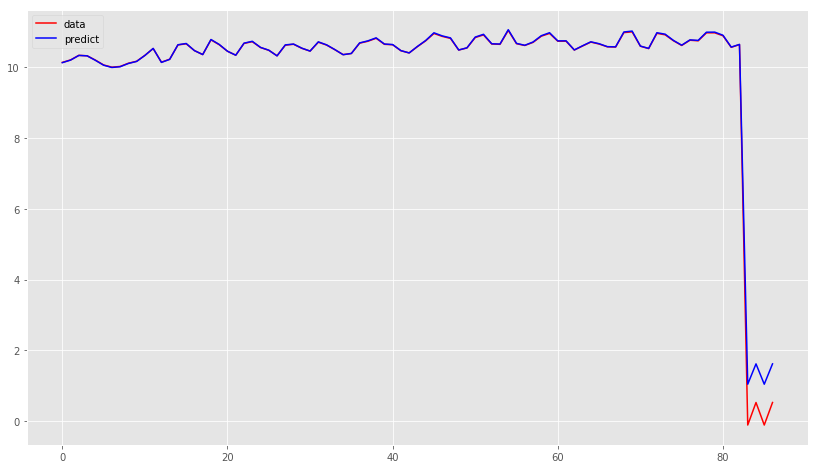

87/87 [==============================] - 0s 63us/step
model evaluate mse: [6.542061235712863, 0.04316662915650456, 6.498894751757041, 0.04316662885676855, 6.498894400980281]


In [24]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

## 事前学習モデルの精度の評価

In [25]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.010133943531705129
rmse: 0.15395204567158569
0.08204299460164541


In [26]:
del model
gc.collect()

15325

In [27]:
hetero_genious_callbacks.class_weight

{0: 1.0, 1: 9.777907252136327}

## 学習後の重みを付与

In [28]:
model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

with timer('train model individual hetero'):
    model.fit(x, x, validation_split=0.1, class_weight=hetero_genious_callbacks.class_weight, 
              epochs=1000, callbacks=[tensorboard, early_stop])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 3, 120)       58560       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 3, 150)       91200       input_6[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

135/135 [==============================] - 0s 236us/step - loss: 0.0399 - dense_5_loss: 0.0085 - dense_6_loss: 0.0314 - dense_5_mean_squared_error: 0.0085 - dense_6_mean_squared_error: 0.0314 - val_loss: 0.0723 - val_dense_5_loss: 0.0117 - val_dense_6_loss: 0.0607 - val_dense_5_mean_squared_error: 0.0117 - val_dense_6_mean_squared_error: 0.0607
Epoch 20/1000
135/135 [==============================] - 0s 240us/step - loss: 0.0348 - dense_5_loss: 0.0078 - dense_6_loss: 0.0270 - dense_5_mean_squared_error: 0.0078 - dense_6_mean_squared_error: 0.0270 - val_loss: 0.0681 - val_dense_5_loss: 0.0112 - val_dense_6_loss: 0.0569 - val_dense_5_mean_squared_error: 0.0112 - val_dense_6_mean_squared_error: 0.0569
Epoch 21/1000
135/135 [==============================] - 0s 256us/step - loss: 0.0306 - dense_5_loss: 0.0072 - dense_6_loss: 0.0234 - dense_5_mean_squared_error: 0.0072 - dense_6_mean_squared_error: 0.0234 - val_loss: 0.0647 - val_dense_5_loss: 0.0108 - val_dense_6_loss: 0.0539 - val_dense_5

Epoch 42/1000
135/135 [==============================] - 0s 239us/step - loss: 0.0028 - dense_5_loss: 0.0013 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0013 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0386 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 0.0344 - val_dense_5_mean_squared_error: 0.0042 - val_dense_6_mean_squared_error: 0.0344
Epoch 43/1000
135/135 [==============================] - 0s 253us/step - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0012 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0383 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 0.0343 - val_dense_5_mean_squared_error: 0.0039 - val_dense_6_mean_squared_error: 0.0343
Epoch 44/1000
135/135 [==============================] - 0s 312us/step - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0011 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0378 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 0.0341

135/135 [==============================] - 0s 371us/step - loss: 0.0016 - dense_5_loss: 2.4630e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 2.4630e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0316 - val_dense_5_loss: 8.1140e-04 - val_dense_6_loss: 0.0308 - val_dense_5_mean_squared_error: 8.1140e-04 - val_dense_6_mean_squared_error: 0.0308
Epoch 65/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0016 - dense_5_loss: 2.2560e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 2.2560e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0313 - val_dense_5_loss: 7.3219e-04 - val_dense_6_loss: 0.0306 - val_dense_5_mean_squared_error: 7.3219e-04 - val_dense_6_mean_squared_error: 0.0306
Epoch 66/1000
135/135 [==============================] - 0s 231us/step - loss: 0.0016 - dense_5_loss: 2.0486e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 2.0486e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0310 - val_dense_5_loss: 6.3624e

Epoch 86/1000
135/135 [==============================] - 0s 230us/step - loss: 0.0012 - dense_5_loss: 3.2539e-05 - dense_6_loss: 0.0012 - dense_5_mean_squared_error: 3.2539e-05 - dense_6_mean_squared_error: 0.0012 - val_loss: 0.0268 - val_dense_5_loss: 6.7236e-05 - val_dense_6_loss: 0.0268 - val_dense_5_mean_squared_error: 6.7236e-05 - val_dense_6_mean_squared_error: 0.0268
Epoch 87/1000
135/135 [==============================] - 0s 225us/step - loss: 0.0013 - dense_5_loss: 3.0640e-05 - dense_6_loss: 0.0012 - dense_5_mean_squared_error: 3.0640e-05 - dense_6_mean_squared_error: 0.0012 - val_loss: 0.0266 - val_dense_5_loss: 6.0696e-05 - val_dense_6_loss: 0.0266 - val_dense_5_mean_squared_error: 6.0696e-05 - val_dense_6_mean_squared_error: 0.0266
Epoch 88/1000
135/135 [==============================] - 0s 241us/step - loss: 0.0012 - dense_5_loss: 2.7958e-05 - dense_6_loss: 0.0012 - dense_5_mean_squared_error: 2.7958e-05 - dense_6_mean_squared_error: 0.0012 - val_loss: 0.0266 - val_dense_5

Epoch 108/1000
135/135 [==============================] - 0s 258us/step - loss: 0.0011 - dense_5_loss: 8.4522e-06 - dense_6_loss: 0.0010 - dense_5_mean_squared_error: 8.4522e-06 - dense_6_mean_squared_error: 0.0010 - val_loss: 0.0231 - val_dense_5_loss: 1.3197e-05 - val_dense_6_loss: 0.0231 - val_dense_5_mean_squared_error: 1.3197e-05 - val_dense_6_mean_squared_error: 0.0231
Epoch 109/1000
135/135 [==============================] - 0s 245us/step - loss: 0.0011 - dense_5_loss: 8.0679e-06 - dense_6_loss: 0.0010 - dense_5_mean_squared_error: 8.0679e-06 - dense_6_mean_squared_error: 0.0010 - val_loss: 0.0229 - val_dense_5_loss: 1.2703e-05 - val_dense_6_loss: 0.0229 - val_dense_5_mean_squared_error: 1.2703e-05 - val_dense_6_mean_squared_error: 0.0229
Epoch 110/1000
135/135 [==============================] - 0s 283us/step - loss: 0.0010 - dense_5_loss: 7.8187e-06 - dense_6_loss: 0.0010 - dense_5_mean_squared_error: 7.8187e-06 - dense_6_mean_squared_error: 0.0010 - val_loss: 0.0228 - val_dens

135/135 [==============================] - 0s 259us/step - loss: 9.0060e-04 - dense_5_loss: 4.2836e-06 - dense_6_loss: 8.9632e-04 - dense_5_mean_squared_error: 4.2836e-06 - dense_6_mean_squared_error: 8.9632e-04 - val_loss: 0.0200 - val_dense_5_loss: 5.8400e-06 - val_dense_6_loss: 0.0200 - val_dense_5_mean_squared_error: 5.8400e-06 - val_dense_6_mean_squared_error: 0.0200
Epoch 130/1000
135/135 [==============================] - 0s 280us/step - loss: 8.8805e-04 - dense_5_loss: 4.1937e-06 - dense_6_loss: 8.8386e-04 - dense_5_mean_squared_error: 4.1937e-06 - dense_6_mean_squared_error: 8.8386e-04 - val_loss: 0.0199 - val_dense_5_loss: 5.7055e-06 - val_dense_6_loss: 0.0199 - val_dense_5_mean_squared_error: 5.7055e-06 - val_dense_6_mean_squared_error: 0.0199
Epoch 131/1000
135/135 [==============================] - 0s 306us/step - loss: 8.8766e-04 - dense_5_loss: 4.1355e-06 - dense_6_loss: 8.8353e-04 - dense_5_mean_squared_error: 4.1355e-06 - dense_6_mean_squared_error: 8.8353e-04 - val_lo

135/135 [==============================] - 0s 255us/step - loss: 7.7566e-04 - dense_5_loss: 3.3828e-06 - dense_6_loss: 7.7228e-04 - dense_5_mean_squared_error: 3.3828e-06 - dense_6_mean_squared_error: 7.7228e-04 - val_loss: 0.0176 - val_dense_5_loss: 4.5764e-06 - val_dense_6_loss: 0.0176 - val_dense_5_mean_squared_error: 4.5764e-06 - val_dense_6_mean_squared_error: 0.0176
Epoch 151/1000
135/135 [==============================] - 0s 253us/step - loss: 7.7646e-04 - dense_5_loss: 3.3653e-06 - dense_6_loss: 7.7310e-04 - dense_5_mean_squared_error: 3.3653e-06 - dense_6_mean_squared_error: 7.7310e-04 - val_loss: 0.0175 - val_dense_5_loss: 4.6120e-06 - val_dense_6_loss: 0.0175 - val_dense_5_mean_squared_error: 4.6120e-06 - val_dense_6_mean_squared_error: 0.0175
Epoch 152/1000
135/135 [==============================] - 0s 256us/step - loss: 7.6954e-04 - dense_5_loss: 3.3479e-06 - dense_6_loss: 7.6619e-04 - dense_5_mean_squared_error: 3.3479e-06 - dense_6_mean_squared_error: 7.6619e-04 - val_lo

135/135 [==============================] - 0s 254us/step - loss: 6.7997e-04 - dense_5_loss: 3.0874e-06 - dense_6_loss: 6.7688e-04 - dense_5_mean_squared_error: 3.0874e-06 - dense_6_mean_squared_error: 6.7688e-04 - val_loss: 0.0156 - val_dense_5_loss: 4.4213e-06 - val_dense_6_loss: 0.0156 - val_dense_5_mean_squared_error: 4.4213e-06 - val_dense_6_mean_squared_error: 0.0156
Epoch 172/1000
135/135 [==============================] - 0s 231us/step - loss: 6.8702e-04 - dense_5_loss: 3.0952e-06 - dense_6_loss: 6.8392e-04 - dense_5_mean_squared_error: 3.0952e-06 - dense_6_mean_squared_error: 6.8392e-04 - val_loss: 0.0156 - val_dense_5_loss: 4.3720e-06 - val_dense_6_loss: 0.0156 - val_dense_5_mean_squared_error: 4.3720e-06 - val_dense_6_mean_squared_error: 0.0156
Epoch 173/1000
135/135 [==============================] - 0s 220us/step - loss: 6.7610e-04 - dense_5_loss: 3.0919e-06 - dense_6_loss: 6.7301e-04 - dense_5_mean_squared_error: 3.0919e-06 - dense_6_mean_squared_error: 6.7301e-04 - val_lo

135/135 [==============================] - 0s 213us/step - loss: 5.8343e-04 - dense_5_loss: 2.9288e-06 - dense_6_loss: 5.8050e-04 - dense_5_mean_squared_error: 2.9288e-06 - dense_6_mean_squared_error: 5.8050e-04 - val_loss: 0.0142 - val_dense_5_loss: 3.8383e-06 - val_dense_6_loss: 0.0142 - val_dense_5_mean_squared_error: 3.8383e-06 - val_dense_6_mean_squared_error: 0.0142
Epoch 193/1000
135/135 [==============================] - 0s 218us/step - loss: 5.7999e-04 - dense_5_loss: 2.8913e-06 - dense_6_loss: 5.7710e-04 - dense_5_mean_squared_error: 2.8913e-06 - dense_6_mean_squared_error: 5.7710e-04 - val_loss: 0.0141 - val_dense_5_loss: 3.9283e-06 - val_dense_6_loss: 0.0141 - val_dense_5_mean_squared_error: 3.9283e-06 - val_dense_6_mean_squared_error: 0.0141
Epoch 194/1000
135/135 [==============================] - 0s 212us/step - loss: 5.8193e-04 - dense_5_loss: 2.8936e-06 - dense_6_loss: 5.7903e-04 - dense_5_mean_squared_error: 2.8936e-06 - dense_6_mean_squared_error: 5.7903e-04 - val_lo

135/135 [==============================] - 0s 250us/step - loss: 5.0462e-04 - dense_5_loss: 2.7350e-06 - dense_6_loss: 5.0189e-04 - dense_5_mean_squared_error: 2.7350e-06 - dense_6_mean_squared_error: 5.0189e-04 - val_loss: 0.0130 - val_dense_5_loss: 3.7916e-06 - val_dense_6_loss: 0.0130 - val_dense_5_mean_squared_error: 3.7916e-06 - val_dense_6_mean_squared_error: 0.0130
Epoch 214/1000
135/135 [==============================] - 0s 247us/step - loss: 4.9720e-04 - dense_5_loss: 2.7104e-06 - dense_6_loss: 4.9449e-04 - dense_5_mean_squared_error: 2.7104e-06 - dense_6_mean_squared_error: 4.9449e-04 - val_loss: 0.0129 - val_dense_5_loss: 3.7409e-06 - val_dense_6_loss: 0.0129 - val_dense_5_mean_squared_error: 3.7409e-06 - val_dense_6_mean_squared_error: 0.0129
Epoch 215/1000
135/135 [==============================] - 0s 227us/step - loss: 4.9466e-04 - dense_5_loss: 2.7067e-06 - dense_6_loss: 4.9196e-04 - dense_5_mean_squared_error: 2.7067e-06 - dense_6_mean_squared_error: 4.9196e-04 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 4.2999e-04 - dense_5_loss: 2.5577e-06 - dense_6_loss: 4.2743e-04 - dense_5_mean_squared_error: 2.5577e-06 - dense_6_mean_squared_error: 4.2743e-04 - val_loss: 0.0118 - val_dense_5_loss: 3.4909e-06 - val_dense_6_loss: 0.0118 - val_dense_5_mean_squared_error: 3.4909e-06 - val_dense_6_mean_squared_error: 0.0118
Epoch 235/1000
135/135 [==============================] - 0s 231us/step - loss: 4.2344e-04 - dense_5_loss: 2.5836e-06 - dense_6_loss: 4.2085e-04 - dense_5_mean_squared_error: 2.5836e-06 - dense_6_mean_squared_error: 4.2085e-04 - val_loss: 0.0118 - val_dense_5_loss: 3.4237e-06 - val_dense_6_loss: 0.0118 - val_dense_5_mean_squared_error: 3.4237e-06 - val_dense_6_mean_squared_error: 0.0118
Epoch 236/1000
135/135 [==============================] - 0s 235us/step - loss: 4.1893e-04 - dense_5_loss: 2.5464e-06 - dense_6_loss: 4.1638e-04 - dense_5_mean_squared_error: 2.5464e-06 - dense_6_mean_squared_error: 4.1638e-04 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 3.5739e-04 - dense_5_loss: 2.4251e-06 - dense_6_loss: 3.5496e-04 - dense_5_mean_squared_error: 2.4251e-06 - dense_6_mean_squared_error: 3.5496e-04 - val_loss: 0.0108 - val_dense_5_loss: 3.2123e-06 - val_dense_6_loss: 0.0108 - val_dense_5_mean_squared_error: 3.2123e-06 - val_dense_6_mean_squared_error: 0.0108
Epoch 256/1000
135/135 [==============================] - 0s 255us/step - loss: 3.5277e-04 - dense_5_loss: 2.4008e-06 - dense_6_loss: 3.5037e-04 - dense_5_mean_squared_error: 2.4008e-06 - dense_6_mean_squared_error: 3.5037e-04 - val_loss: 0.0107 - val_dense_5_loss: 3.2265e-06 - val_dense_6_loss: 0.0107 - val_dense_5_mean_squared_error: 3.2265e-06 - val_dense_6_mean_squared_error: 0.0107
Epoch 257/1000
135/135 [==============================] - 0s 239us/step - loss: 3.4898e-04 - dense_5_loss: 2.3581e-06 - dense_6_loss: 3.4662e-04 - dense_5_mean_squared_error: 2.3581e-06 - dense_6_mean_squared_error: 3.4662e-04 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 2.9667e-04 - dense_5_loss: 2.2204e-06 - dense_6_loss: 2.9445e-04 - dense_5_mean_squared_error: 2.2204e-06 - dense_6_mean_squared_error: 2.9445e-04 - val_loss: 0.0097 - val_dense_5_loss: 3.3031e-06 - val_dense_6_loss: 0.0097 - val_dense_5_mean_squared_error: 3.3031e-06 - val_dense_6_mean_squared_error: 0.0097
Epoch 277/1000
135/135 [==============================] - 0s 211us/step - loss: 2.9436e-04 - dense_5_loss: 2.2387e-06 - dense_6_loss: 2.9213e-04 - dense_5_mean_squared_error: 2.2387e-06 - dense_6_mean_squared_error: 2.9213e-04 - val_loss: 0.0097 - val_dense_5_loss: 3.2704e-06 - val_dense_6_loss: 0.0097 - val_dense_5_mean_squared_error: 3.2704e-06 - val_dense_6_mean_squared_error: 0.0097
Epoch 278/1000
135/135 [==============================] - 0s 216us/step - loss: 2.9258e-04 - dense_5_loss: 2.2009e-06 - dense_6_loss: 2.9038e-04 - dense_5_mean_squared_error: 2.2009e-06 - dense_6_mean_squared_error: 2.9038e-04 - val_lo

135/135 [==============================] - 0s 244us/step - loss: 2.4813e-04 - dense_5_loss: 2.0699e-06 - dense_6_loss: 2.4606e-04 - dense_5_mean_squared_error: 2.0699e-06 - dense_6_mean_squared_error: 2.4606e-04 - val_loss: 0.0088 - val_dense_5_loss: 2.9832e-06 - val_dense_6_loss: 0.0088 - val_dense_5_mean_squared_error: 2.9832e-06 - val_dense_6_mean_squared_error: 0.0088
Epoch 298/1000
135/135 [==============================] - 0s 246us/step - loss: 2.4810e-04 - dense_5_loss: 2.0540e-06 - dense_6_loss: 2.4605e-04 - dense_5_mean_squared_error: 2.0540e-06 - dense_6_mean_squared_error: 2.4605e-04 - val_loss: 0.0087 - val_dense_5_loss: 2.9089e-06 - val_dense_6_loss: 0.0087 - val_dense_5_mean_squared_error: 2.9089e-06 - val_dense_6_mean_squared_error: 0.0087
Epoch 299/1000
135/135 [==============================] - 0s 249us/step - loss: 2.4968e-04 - dense_5_loss: 2.0573e-06 - dense_6_loss: 2.4762e-04 - dense_5_mean_squared_error: 2.0573e-06 - dense_6_mean_squared_error: 2.4762e-04 - val_lo

135/135 [==============================] - 0s 217us/step - loss: 2.0290e-04 - dense_5_loss: 1.9235e-06 - dense_6_loss: 2.0098e-04 - dense_5_mean_squared_error: 1.9235e-06 - dense_6_mean_squared_error: 2.0098e-04 - val_loss: 0.0078 - val_dense_5_loss: 2.8288e-06 - val_dense_6_loss: 0.0078 - val_dense_5_mean_squared_error: 2.8288e-06 - val_dense_6_mean_squared_error: 0.0078
Epoch 319/1000
135/135 [==============================] - 0s 215us/step - loss: 2.0427e-04 - dense_5_loss: 1.9283e-06 - dense_6_loss: 2.0234e-04 - dense_5_mean_squared_error: 1.9283e-06 - dense_6_mean_squared_error: 2.0234e-04 - val_loss: 0.0077 - val_dense_5_loss: 2.8468e-06 - val_dense_6_loss: 0.0077 - val_dense_5_mean_squared_error: 2.8468e-06 - val_dense_6_mean_squared_error: 0.0077
Epoch 320/1000
135/135 [==============================] - 0s 216us/step - loss: 2.0392e-04 - dense_5_loss: 1.9299e-06 - dense_6_loss: 2.0199e-04 - dense_5_mean_squared_error: 1.9299e-06 - dense_6_mean_squared_error: 2.0199e-04 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 1.6843e-04 - dense_5_loss: 1.7964e-06 - dense_6_loss: 1.6664e-04 - dense_5_mean_squared_error: 1.7964e-06 - dense_6_mean_squared_error: 1.6664e-04 - val_loss: 0.0069 - val_dense_5_loss: 2.7437e-06 - val_dense_6_loss: 0.0069 - val_dense_5_mean_squared_error: 2.7437e-06 - val_dense_6_mean_squared_error: 0.0069
Epoch 340/1000
135/135 [==============================] - 0s 236us/step - loss: 1.6804e-04 - dense_5_loss: 1.8087e-06 - dense_6_loss: 1.6624e-04 - dense_5_mean_squared_error: 1.8087e-06 - dense_6_mean_squared_error: 1.6624e-04 - val_loss: 0.0069 - val_dense_5_loss: 2.7279e-06 - val_dense_6_loss: 0.0069 - val_dense_5_mean_squared_error: 2.7279e-06 - val_dense_6_mean_squared_error: 0.0069
Epoch 341/1000
135/135 [==============================] - 0s 245us/step - loss: 1.6724e-04 - dense_5_loss: 1.7797e-06 - dense_6_loss: 1.6546e-04 - dense_5_mean_squared_error: 1.7797e-06 - dense_6_mean_squared_error: 1.6546e-04 - val_lo

135/135 [==============================] - 0s 221us/step - loss: 1.3974e-04 - dense_5_loss: 1.6595e-06 - dense_6_loss: 1.3808e-04 - dense_5_mean_squared_error: 1.6595e-06 - dense_6_mean_squared_error: 1.3808e-04 - val_loss: 0.0062 - val_dense_5_loss: 2.4757e-06 - val_dense_6_loss: 0.0062 - val_dense_5_mean_squared_error: 2.4757e-06 - val_dense_6_mean_squared_error: 0.0062
Epoch 361/1000
135/135 [==============================] - 0s 245us/step - loss: 1.3903e-04 - dense_5_loss: 1.6750e-06 - dense_6_loss: 1.3735e-04 - dense_5_mean_squared_error: 1.6750e-06 - dense_6_mean_squared_error: 1.3735e-04 - val_loss: 0.0062 - val_dense_5_loss: 2.4715e-06 - val_dense_6_loss: 0.0062 - val_dense_5_mean_squared_error: 2.4715e-06 - val_dense_6_mean_squared_error: 0.0062
Epoch 362/1000
135/135 [==============================] - 0s 245us/step - loss: 1.3921e-04 - dense_5_loss: 1.7358e-06 - dense_6_loss: 1.3747e-04 - dense_5_mean_squared_error: 1.7358e-06 - dense_6_mean_squared_error: 1.3747e-04 - val_lo

Epoch 381/1000
135/135 [==============================] - 0s 237us/step - loss: 1.1551e-04 - dense_5_loss: 1.5411e-06 - dense_6_loss: 1.1396e-04 - dense_5_mean_squared_error: 1.5411e-06 - dense_6_mean_squared_error: 1.1396e-04 - val_loss: 0.0056 - val_dense_5_loss: 2.3858e-06 - val_dense_6_loss: 0.0056 - val_dense_5_mean_squared_error: 2.3858e-06 - val_dense_6_mean_squared_error: 0.0056
Epoch 382/1000
135/135 [==============================] - 0s 239us/step - loss: 1.1377e-04 - dense_5_loss: 1.5398e-06 - dense_6_loss: 1.1223e-04 - dense_5_mean_squared_error: 1.5398e-06 - dense_6_mean_squared_error: 1.1223e-04 - val_loss: 0.0056 - val_dense_5_loss: 2.2897e-06 - val_dense_6_loss: 0.0056 - val_dense_5_mean_squared_error: 2.2897e-06 - val_dense_6_mean_squared_error: 0.0056
Epoch 383/1000
135/135 [==============================] - 0s 267us/step - loss: 1.1281e-04 - dense_5_loss: 1.5196e-06 - dense_6_loss: 1.1130e-04 - dense_5_mean_squared_error: 1.5196e-06 - dense_6_mean_squared_error: 1.11

135/135 [==============================] - 0s 243us/step - loss: 9.7728e-05 - dense_5_loss: 1.4249e-06 - dense_6_loss: 9.6303e-05 - dense_5_mean_squared_error: 1.4249e-06 - dense_6_mean_squared_error: 9.6303e-05 - val_loss: 0.0051 - val_dense_5_loss: 2.1685e-06 - val_dense_6_loss: 0.0051 - val_dense_5_mean_squared_error: 2.1685e-06 - val_dense_6_mean_squared_error: 0.0051
Epoch 403/1000
135/135 [==============================] - 0s 231us/step - loss: 9.6576e-05 - dense_5_loss: 1.4460e-06 - dense_6_loss: 9.5130e-05 - dense_5_mean_squared_error: 1.4460e-06 - dense_6_mean_squared_error: 9.5130e-05 - val_loss: 0.0051 - val_dense_5_loss: 2.2628e-06 - val_dense_6_loss: 0.0051 - val_dense_5_mean_squared_error: 2.2628e-06 - val_dense_6_mean_squared_error: 0.0051
Epoch 404/1000
135/135 [==============================] - 0s 240us/step - loss: 9.8866e-05 - dense_5_loss: 1.4190e-06 - dense_6_loss: 9.7447e-05 - dense_5_mean_squared_error: 1.4190e-06 - dense_6_mean_squared_error: 9.7447e-05 - val_lo

135/135 [==============================] - 0s 213us/step - loss: 7.8432e-05 - dense_5_loss: 1.3411e-06 - dense_6_loss: 7.7091e-05 - dense_5_mean_squared_error: 1.3411e-06 - dense_6_mean_squared_error: 7.7091e-05 - val_loss: 0.0046 - val_dense_5_loss: 2.0798e-06 - val_dense_6_loss: 0.0046 - val_dense_5_mean_squared_error: 2.0798e-06 - val_dense_6_mean_squared_error: 0.0046
Epoch 424/1000
135/135 [==============================] - 0s 219us/step - loss: 7.8604e-05 - dense_5_loss: 1.3308e-06 - dense_6_loss: 7.7273e-05 - dense_5_mean_squared_error: 1.3308e-06 - dense_6_mean_squared_error: 7.7273e-05 - val_loss: 0.0045 - val_dense_5_loss: 2.0679e-06 - val_dense_6_loss: 0.0045 - val_dense_5_mean_squared_error: 2.0679e-06 - val_dense_6_mean_squared_error: 0.0045
Epoch 425/1000
135/135 [==============================] - 0s 219us/step - loss: 7.7373e-05 - dense_5_loss: 1.3194e-06 - dense_6_loss: 7.6054e-05 - dense_5_mean_squared_error: 1.3194e-06 - dense_6_mean_squared_error: 7.6054e-05 - val_lo

135/135 [==============================] - 0s 246us/step - loss: 6.3216e-05 - dense_5_loss: 1.2317e-06 - dense_6_loss: 6.1984e-05 - dense_5_mean_squared_error: 1.2317e-06 - dense_6_mean_squared_error: 6.1984e-05 - val_loss: 0.0041 - val_dense_5_loss: 1.8588e-06 - val_dense_6_loss: 0.0041 - val_dense_5_mean_squared_error: 1.8588e-06 - val_dense_6_mean_squared_error: 0.0041
Epoch 445/1000
135/135 [==============================] - 0s 238us/step - loss: 6.2621e-05 - dense_5_loss: 1.2251e-06 - dense_6_loss: 6.1396e-05 - dense_5_mean_squared_error: 1.2251e-06 - dense_6_mean_squared_error: 6.1396e-05 - val_loss: 0.0041 - val_dense_5_loss: 1.8219e-06 - val_dense_6_loss: 0.0041 - val_dense_5_mean_squared_error: 1.8219e-06 - val_dense_6_mean_squared_error: 0.0041
Epoch 446/1000
135/135 [==============================] - 0s 238us/step - loss: 6.1438e-05 - dense_5_loss: 1.2088e-06 - dense_6_loss: 6.0230e-05 - dense_5_mean_squared_error: 1.2088e-06 - dense_6_mean_squared_error: 6.0230e-05 - val_lo

135/135 [==============================] - 0s 268us/step - loss: 5.2113e-05 - dense_5_loss: 1.1504e-06 - dense_6_loss: 5.0962e-05 - dense_5_mean_squared_error: 1.1504e-06 - dense_6_mean_squared_error: 5.0962e-05 - val_loss: 0.0038 - val_dense_5_loss: 1.7357e-06 - val_dense_6_loss: 0.0038 - val_dense_5_mean_squared_error: 1.7357e-06 - val_dense_6_mean_squared_error: 0.0038
Epoch 466/1000
135/135 [==============================] - 0s 268us/step - loss: 5.0157e-05 - dense_5_loss: 1.1778e-06 - dense_6_loss: 4.8979e-05 - dense_5_mean_squared_error: 1.1778e-06 - dense_6_mean_squared_error: 4.8979e-05 - val_loss: 0.0037 - val_dense_5_loss: 1.6874e-06 - val_dense_6_loss: 0.0037 - val_dense_5_mean_squared_error: 1.6874e-06 - val_dense_6_mean_squared_error: 0.0037
Epoch 467/1000
135/135 [==============================] - 0s 257us/step - loss: 4.9496e-05 - dense_5_loss: 1.1360e-06 - dense_6_loss: 4.8360e-05 - dense_5_mean_squared_error: 1.1360e-06 - dense_6_mean_squared_error: 4.8360e-05 - val_lo

135/135 [==============================] - 0s 259us/step - loss: 4.0005e-05 - dense_5_loss: 1.0516e-06 - dense_6_loss: 3.8954e-05 - dense_5_mean_squared_error: 1.0516e-06 - dense_6_mean_squared_error: 3.8954e-05 - val_loss: 0.0034 - val_dense_5_loss: 1.7729e-06 - val_dense_6_loss: 0.0034 - val_dense_5_mean_squared_error: 1.7729e-06 - val_dense_6_mean_squared_error: 0.0034
Epoch 487/1000
135/135 [==============================] - 0s 260us/step - loss: 3.9548e-05 - dense_5_loss: 1.0428e-06 - dense_6_loss: 3.8505e-05 - dense_5_mean_squared_error: 1.0428e-06 - dense_6_mean_squared_error: 3.8505e-05 - val_loss: 0.0034 - val_dense_5_loss: 1.7296e-06 - val_dense_6_loss: 0.0034 - val_dense_5_mean_squared_error: 1.7296e-06 - val_dense_6_mean_squared_error: 0.0034
Epoch 488/1000
135/135 [==============================] - 0s 269us/step - loss: 3.9661e-05 - dense_5_loss: 1.0726e-06 - dense_6_loss: 3.8588e-05 - dense_5_mean_squared_error: 1.0726e-06 - dense_6_mean_squared_error: 3.8588e-05 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 3.1332e-05 - dense_5_loss: 9.7708e-07 - dense_6_loss: 3.0355e-05 - dense_5_mean_squared_error: 9.7708e-07 - dense_6_mean_squared_error: 3.0355e-05 - val_loss: 0.0031 - val_dense_5_loss: 1.5230e-06 - val_dense_6_loss: 0.0031 - val_dense_5_mean_squared_error: 1.5230e-06 - val_dense_6_mean_squared_error: 0.0031
Epoch 508/1000
135/135 [==============================] - 0s 225us/step - loss: 3.0969e-05 - dense_5_loss: 9.6218e-07 - dense_6_loss: 3.0007e-05 - dense_5_mean_squared_error: 9.6218e-07 - dense_6_mean_squared_error: 3.0007e-05 - val_loss: 0.0031 - val_dense_5_loss: 1.4857e-06 - val_dense_6_loss: 0.0031 - val_dense_5_mean_squared_error: 1.4857e-06 - val_dense_6_mean_squared_error: 0.0031
Epoch 509/1000
135/135 [==============================] - 0s 234us/step - loss: 3.0525e-05 - dense_5_loss: 9.7042e-07 - dense_6_loss: 2.9554e-05 - dense_5_mean_squared_error: 9.7042e-07 - dense_6_mean_squared_error: 2.9554e-05 - val_lo

135/135 [==============================] - 0s 254us/step - loss: 2.4830e-05 - dense_5_loss: 9.1746e-07 - dense_6_loss: 2.3913e-05 - dense_5_mean_squared_error: 9.1746e-07 - dense_6_mean_squared_error: 2.3913e-05 - val_loss: 0.0028 - val_dense_5_loss: 1.4475e-06 - val_dense_6_loss: 0.0028 - val_dense_5_mean_squared_error: 1.4475e-06 - val_dense_6_mean_squared_error: 0.0028
Epoch 529/1000
135/135 [==============================] - 0s 240us/step - loss: 2.4435e-05 - dense_5_loss: 8.8687e-07 - dense_6_loss: 2.3548e-05 - dense_5_mean_squared_error: 8.8687e-07 - dense_6_mean_squared_error: 2.3548e-05 - val_loss: 0.0028 - val_dense_5_loss: 1.4341e-06 - val_dense_6_loss: 0.0028 - val_dense_5_mean_squared_error: 1.4341e-06 - val_dense_6_mean_squared_error: 0.0028
Epoch 530/1000
135/135 [==============================] - 0s 252us/step - loss: 2.4034e-05 - dense_5_loss: 8.9156e-07 - dense_6_loss: 2.3143e-05 - dense_5_mean_squared_error: 8.9156e-07 - dense_6_mean_squared_error: 2.3143e-05 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 1.8655e-05 - dense_5_loss: 8.3265e-07 - dense_6_loss: 1.7823e-05 - dense_5_mean_squared_error: 8.3265e-07 - dense_6_mean_squared_error: 1.7823e-05 - val_loss: 0.0025 - val_dense_5_loss: 1.2061e-06 - val_dense_6_loss: 0.0025 - val_dense_5_mean_squared_error: 1.2061e-06 - val_dense_6_mean_squared_error: 0.0025
Epoch 550/1000
135/135 [==============================] - 0s 242us/step - loss: 1.8168e-05 - dense_5_loss: 8.1663e-07 - dense_6_loss: 1.7352e-05 - dense_5_mean_squared_error: 8.1663e-07 - dense_6_mean_squared_error: 1.7352e-05 - val_loss: 0.0025 - val_dense_5_loss: 1.2624e-06 - val_dense_6_loss: 0.0025 - val_dense_5_mean_squared_error: 1.2624e-06 - val_dense_6_mean_squared_error: 0.0025
Epoch 551/1000
135/135 [==============================] - 0s 236us/step - loss: 1.7839e-05 - dense_5_loss: 8.1811e-07 - dense_6_loss: 1.7020e-05 - dense_5_mean_squared_error: 8.1811e-07 - dense_6_mean_squared_error: 1.7020e-05 - val_lo

135/135 [==============================] - 0s 257us/step - loss: 1.4499e-05 - dense_5_loss: 7.8822e-07 - dense_6_loss: 1.3711e-05 - dense_5_mean_squared_error: 7.8822e-07 - dense_6_mean_squared_error: 1.3711e-05 - val_loss: 0.0023 - val_dense_5_loss: 1.1836e-06 - val_dense_6_loss: 0.0023 - val_dense_5_mean_squared_error: 1.1836e-06 - val_dense_6_mean_squared_error: 0.0023
Epoch 571/1000
135/135 [==============================] - 0s 249us/step - loss: 1.4153e-05 - dense_5_loss: 7.6281e-07 - dense_6_loss: 1.3390e-05 - dense_5_mean_squared_error: 7.6281e-07 - dense_6_mean_squared_error: 1.3390e-05 - val_loss: 0.0023 - val_dense_5_loss: 1.1352e-06 - val_dense_6_loss: 0.0023 - val_dense_5_mean_squared_error: 1.1352e-06 - val_dense_6_mean_squared_error: 0.0023
Epoch 572/1000
135/135 [==============================] - 0s 272us/step - loss: 1.3817e-05 - dense_5_loss: 7.6148e-07 - dense_6_loss: 1.3056e-05 - dense_5_mean_squared_error: 7.6148e-07 - dense_6_mean_squared_error: 1.3056e-05 - val_lo

135/135 [==============================] - 0s 307us/step - loss: 1.0731e-05 - dense_5_loss: 6.8312e-07 - dense_6_loss: 1.0048e-05 - dense_5_mean_squared_error: 6.8312e-07 - dense_6_mean_squared_error: 1.0048e-05 - val_loss: 0.0021 - val_dense_5_loss: 1.0924e-06 - val_dense_6_loss: 0.0021 - val_dense_5_mean_squared_error: 1.0924e-06 - val_dense_6_mean_squared_error: 0.0021
Epoch 592/1000
135/135 [==============================] - 0s 269us/step - loss: 1.0556e-05 - dense_5_loss: 6.8809e-07 - dense_6_loss: 9.8679e-06 - dense_5_mean_squared_error: 6.8809e-07 - dense_6_mean_squared_error: 9.8679e-06 - val_loss: 0.0021 - val_dense_5_loss: 1.0258e-06 - val_dense_6_loss: 0.0021 - val_dense_5_mean_squared_error: 1.0258e-06 - val_dense_6_mean_squared_error: 0.0021
Epoch 593/1000
135/135 [==============================] - 0s 277us/step - loss: 1.0465e-05 - dense_5_loss: 6.9647e-07 - dense_6_loss: 9.7683e-06 - dense_5_mean_squared_error: 6.9647e-07 - dense_6_mean_squared_error: 9.7683e-06 - val_lo

135/135 [==============================] - 0s 276us/step - loss: 8.3711e-06 - dense_5_loss: 6.6413e-07 - dense_6_loss: 7.7069e-06 - dense_5_mean_squared_error: 6.6413e-07 - dense_6_mean_squared_error: 7.7069e-06 - val_loss: 0.0019 - val_dense_5_loss: 1.0782e-06 - val_dense_6_loss: 0.0019 - val_dense_5_mean_squared_error: 1.0782e-06 - val_dense_6_mean_squared_error: 0.0019
Epoch 613/1000
135/135 [==============================] - 0s 286us/step - loss: 8.3575e-06 - dense_5_loss: 6.4848e-07 - dense_6_loss: 7.7090e-06 - dense_5_mean_squared_error: 6.4848e-07 - dense_6_mean_squared_error: 7.7090e-06 - val_loss: 0.0019 - val_dense_5_loss: 1.1074e-06 - val_dense_6_loss: 0.0019 - val_dense_5_mean_squared_error: 1.1074e-06 - val_dense_6_mean_squared_error: 0.0019
Epoch 614/1000
135/135 [==============================] - 0s 317us/step - loss: 8.2116e-06 - dense_5_loss: 6.2501e-07 - dense_6_loss: 7.5866e-06 - dense_5_mean_squared_error: 6.2501e-07 - dense_6_mean_squared_error: 7.5866e-06 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 6.8583e-06 - dense_5_loss: 5.8847e-07 - dense_6_loss: 6.2699e-06 - dense_5_mean_squared_error: 5.8847e-07 - dense_6_mean_squared_error: 6.2699e-06 - val_loss: 0.0017 - val_dense_5_loss: 9.8345e-07 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 9.8345e-07 - val_dense_6_mean_squared_error: 0.0017
Epoch 634/1000
135/135 [==============================] - 0s 263us/step - loss: 6.9120e-06 - dense_5_loss: 5.7895e-07 - dense_6_loss: 6.3331e-06 - dense_5_mean_squared_error: 5.7895e-07 - dense_6_mean_squared_error: 6.3331e-06 - val_loss: 0.0017 - val_dense_5_loss: 1.0529e-06 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 1.0529e-06 - val_dense_6_mean_squared_error: 0.0017
Epoch 635/1000
135/135 [==============================] - 0s 285us/step - loss: 7.1666e-06 - dense_5_loss: 5.9506e-07 - dense_6_loss: 6.5715e-06 - dense_5_mean_squared_error: 5.9506e-07 - dense_6_mean_squared_error: 6.5715e-06 - val_lo

135/135 [==============================] - 0s 216us/step - loss: 5.2763e-06 - dense_5_loss: 5.3719e-07 - dense_6_loss: 4.7391e-06 - dense_5_mean_squared_error: 5.3719e-07 - dense_6_mean_squared_error: 4.7391e-06 - val_loss: 0.0016 - val_dense_5_loss: 9.4932e-07 - val_dense_6_loss: 0.0016 - val_dense_5_mean_squared_error: 9.4932e-07 - val_dense_6_mean_squared_error: 0.0016
Epoch 655/1000
135/135 [==============================] - 0s 213us/step - loss: 5.0177e-06 - dense_5_loss: 5.4486e-07 - dense_6_loss: 4.4729e-06 - dense_5_mean_squared_error: 5.4486e-07 - dense_6_mean_squared_error: 4.4729e-06 - val_loss: 0.0016 - val_dense_5_loss: 9.1957e-07 - val_dense_6_loss: 0.0016 - val_dense_5_mean_squared_error: 9.1957e-07 - val_dense_6_mean_squared_error: 0.0016
Epoch 656/1000
135/135 [==============================] - 0s 207us/step - loss: 5.2342e-06 - dense_5_loss: 5.4437e-07 - dense_6_loss: 4.6898e-06 - dense_5_mean_squared_error: 5.4437e-07 - dense_6_mean_squared_error: 4.6898e-06 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 4.1373e-06 - dense_5_loss: 5.0332e-07 - dense_6_loss: 3.6340e-06 - dense_5_mean_squared_error: 5.0332e-07 - dense_6_mean_squared_error: 3.6340e-06 - val_loss: 0.0015 - val_dense_5_loss: 8.1148e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 8.1148e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 676/1000
135/135 [==============================] - 0s 241us/step - loss: 4.0756e-06 - dense_5_loss: 5.0090e-07 - dense_6_loss: 3.5747e-06 - dense_5_mean_squared_error: 5.0090e-07 - dense_6_mean_squared_error: 3.5747e-06 - val_loss: 0.0015 - val_dense_5_loss: 8.2508e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 8.2508e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 677/1000
135/135 [==============================] - 0s 223us/step - loss: 4.0209e-06 - dense_5_loss: 5.0748e-07 - dense_6_loss: 3.5134e-06 - dense_5_mean_squared_error: 5.0748e-07 - dense_6_mean_squared_error: 3.5134e-06 - val_lo

135/135 [==============================] - 0s 244us/step - loss: 3.6037e-06 - dense_5_loss: 4.7012e-07 - dense_6_loss: 3.1336e-06 - dense_5_mean_squared_error: 4.7012e-07 - dense_6_mean_squared_error: 3.1336e-06 - val_loss: 0.0014 - val_dense_5_loss: 7.8924e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 7.8924e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 697/1000
135/135 [==============================] - 0s 291us/step - loss: 3.3284e-06 - dense_5_loss: 4.4857e-07 - dense_6_loss: 2.8798e-06 - dense_5_mean_squared_error: 4.4857e-07 - dense_6_mean_squared_error: 2.8798e-06 - val_loss: 0.0014 - val_dense_5_loss: 8.1108e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 8.1108e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 698/1000
135/135 [==============================] - 0s 245us/step - loss: 3.1552e-06 - dense_5_loss: 4.5295e-07 - dense_6_loss: 2.7023e-06 - dense_5_mean_squared_error: 4.5295e-07 - dense_6_mean_squared_error: 2.7023e-06 - val_lo

135/135 [==============================] - 0s 235us/step - loss: 2.7544e-06 - dense_5_loss: 4.0544e-07 - dense_6_loss: 2.3490e-06 - dense_5_mean_squared_error: 4.0544e-07 - dense_6_mean_squared_error: 2.3490e-06 - val_loss: 0.0014 - val_dense_5_loss: 7.2257e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 7.2257e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 718/1000
135/135 [==============================] - 0s 231us/step - loss: 2.6502e-06 - dense_5_loss: 4.0182e-07 - dense_6_loss: 2.2484e-06 - dense_5_mean_squared_error: 4.0182e-07 - dense_6_mean_squared_error: 2.2484e-06 - val_loss: 0.0014 - val_dense_5_loss: 6.9209e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 6.9209e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 719/1000
135/135 [==============================] - 0s 226us/step - loss: 2.7873e-06 - dense_5_loss: 3.9461e-07 - dense_6_loss: 2.3927e-06 - dense_5_mean_squared_error: 3.9461e-07 - dense_6_mean_squared_error: 2.3927e-06 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 2.3111e-06 - dense_5_loss: 3.7088e-07 - dense_6_loss: 1.9402e-06 - dense_5_mean_squared_error: 3.7088e-07 - dense_6_mean_squared_error: 1.9402e-06 - val_loss: 0.0013 - val_dense_5_loss: 6.7029e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 6.7029e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 739/1000
135/135 [==============================] - 0s 238us/step - loss: 2.4487e-06 - dense_5_loss: 3.6823e-07 - dense_6_loss: 2.0805e-06 - dense_5_mean_squared_error: 3.6823e-07 - dense_6_mean_squared_error: 2.0805e-06 - val_loss: 0.0013 - val_dense_5_loss: 6.7393e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 6.7393e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 740/1000
135/135 [==============================] - 0s 231us/step - loss: 2.5261e-06 - dense_5_loss: 4.0830e-07 - dense_6_loss: 2.1178e-06 - dense_5_mean_squared_error: 4.0830e-07 - dense_6_mean_squared_error: 2.1178e-06 - val_lo

135/135 [==============================] - 0s 259us/step - loss: 2.4207e-06 - dense_5_loss: 3.4094e-07 - dense_6_loss: 2.0798e-06 - dense_5_mean_squared_error: 3.4094e-07 - dense_6_mean_squared_error: 2.0798e-06 - val_loss: 0.0013 - val_dense_5_loss: 6.1271e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 6.1271e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 760/1000
135/135 [==============================] - 0s 236us/step - loss: 2.2364e-06 - dense_5_loss: 3.3627e-07 - dense_6_loss: 1.9001e-06 - dense_5_mean_squared_error: 3.3627e-07 - dense_6_mean_squared_error: 1.9001e-06 - val_loss: 0.0013 - val_dense_5_loss: 6.1024e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 6.1024e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 761/1000
135/135 [==============================] - 0s 235us/step - loss: 2.1191e-06 - dense_5_loss: 3.2821e-07 - dense_6_loss: 1.7909e-06 - dense_5_mean_squared_error: 3.2821e-07 - dense_6_mean_squared_error: 1.7909e-06 - val_lo

135/135 [==============================] - 0s 241us/step - loss: 2.1429e-06 - dense_5_loss: 3.1812e-07 - dense_6_loss: 1.8248e-06 - dense_5_mean_squared_error: 3.1812e-07 - dense_6_mean_squared_error: 1.8248e-06 - val_loss: 0.0012 - val_dense_5_loss: 5.3013e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 5.3013e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 781/1000
135/135 [==============================] - 0s 246us/step - loss: 2.3386e-06 - dense_5_loss: 3.0671e-07 - dense_6_loss: 2.0319e-06 - dense_5_mean_squared_error: 3.0671e-07 - dense_6_mean_squared_error: 2.0319e-06 - val_loss: 0.0012 - val_dense_5_loss: 5.5392e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 5.5392e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 782/1000
135/135 [==============================] - 0s 239us/step - loss: 2.3256e-06 - dense_5_loss: 3.0450e-07 - dense_6_loss: 2.0211e-06 - dense_5_mean_squared_error: 3.0450e-07 - dense_6_mean_squared_error: 2.0211e-06 - val_lo

135/135 [==============================] - 0s 275us/step - loss: 1.8898e-06 - dense_5_loss: 2.8518e-07 - dense_6_loss: 1.6047e-06 - dense_5_mean_squared_error: 2.8518e-07 - dense_6_mean_squared_error: 1.6047e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.7183e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.7183e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 802/1000
135/135 [==============================] - 0s 260us/step - loss: 1.8671e-06 - dense_5_loss: 2.9157e-07 - dense_6_loss: 1.5755e-06 - dense_5_mean_squared_error: 2.9157e-07 - dense_6_mean_squared_error: 1.5755e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.5182e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.5182e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 803/1000
135/135 [==============================] - 0s 247us/step - loss: 1.6906e-06 - dense_5_loss: 2.9161e-07 - dense_6_loss: 1.3990e-06 - dense_5_mean_squared_error: 2.9161e-07 - dense_6_mean_squared_error: 1.3990e-06 - val_lo

135/135 [==============================] - 0s 249us/step - loss: 1.6620e-06 - dense_5_loss: 2.5344e-07 - dense_6_loss: 1.4085e-06 - dense_5_mean_squared_error: 2.5344e-07 - dense_6_mean_squared_error: 1.4085e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.8446e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.8446e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 823/1000
135/135 [==============================] - 0s 257us/step - loss: 1.6101e-06 - dense_5_loss: 2.6284e-07 - dense_6_loss: 1.3473e-06 - dense_5_mean_squared_error: 2.6284e-07 - dense_6_mean_squared_error: 1.3473e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.6106e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.6106e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 824/1000
135/135 [==============================] - 0s 247us/step - loss: 1.7592e-06 - dense_5_loss: 2.4603e-07 - dense_6_loss: 1.5132e-06 - dense_5_mean_squared_error: 2.4603e-07 - dense_6_mean_squared_error: 1.5132e-06 - val_lo

135/135 [==============================] - 0s 233us/step - loss: 2.3356e-06 - dense_5_loss: 2.6008e-07 - dense_6_loss: 2.0755e-06 - dense_5_mean_squared_error: 2.6008e-07 - dense_6_mean_squared_error: 2.0755e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.1808e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.1808e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 844/1000
135/135 [==============================] - 0s 243us/step - loss: 1.7157e-06 - dense_5_loss: 2.5742e-07 - dense_6_loss: 1.4583e-06 - dense_5_mean_squared_error: 2.5742e-07 - dense_6_mean_squared_error: 1.4583e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.4226e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.4226e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 845/1000
135/135 [==============================] - 0s 246us/step - loss: 1.6268e-06 - dense_5_loss: 2.2670e-07 - dense_6_loss: 1.4002e-06 - dense_5_mean_squared_error: 2.2670e-07 - dense_6_mean_squared_error: 1.4002e-06 - val_lo

135/135 [==============================] - 0s 246us/step - loss: 1.4865e-06 - dense_5_loss: 2.1777e-07 - dense_6_loss: 1.2687e-06 - dense_5_mean_squared_error: 2.1777e-07 - dense_6_mean_squared_error: 1.2687e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.7507e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.7507e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 865/1000
135/135 [==============================] - 0s 245us/step - loss: 1.5094e-06 - dense_5_loss: 2.1866e-07 - dense_6_loss: 1.2908e-06 - dense_5_mean_squared_error: 2.1866e-07 - dense_6_mean_squared_error: 1.2908e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.9540e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.9540e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 866/1000
135/135 [==============================] - 0s 238us/step - loss: 1.5030e-06 - dense_5_loss: 2.2383e-07 - dense_6_loss: 1.2792e-06 - dense_5_mean_squared_error: 2.2383e-07 - dense_6_mean_squared_error: 1.2792e-06 - val_lo

135/135 [==============================] - 0s 262us/step - loss: 1.3966e-06 - dense_5_loss: 2.0521e-07 - dense_6_loss: 1.1914e-06 - dense_5_mean_squared_error: 2.0521e-07 - dense_6_mean_squared_error: 1.1914e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.2338e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.2338e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 886/1000
135/135 [==============================] - 0s 267us/step - loss: 1.7309e-06 - dense_5_loss: 2.1111e-07 - dense_6_loss: 1.5198e-06 - dense_5_mean_squared_error: 2.1111e-07 - dense_6_mean_squared_error: 1.5198e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.3070e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.3070e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 887/1000
135/135 [==============================] - 0s 254us/step - loss: 1.7077e-06 - dense_5_loss: 2.0184e-07 - dense_6_loss: 1.5059e-06 - dense_5_mean_squared_error: 2.0184e-07 - dense_6_mean_squared_error: 1.5059e-06 - val_lo

135/135 [==============================] - 0s 240us/step - loss: 1.3856e-06 - dense_5_loss: 2.3367e-07 - dense_6_loss: 1.1519e-06 - dense_5_mean_squared_error: 2.3367e-07 - dense_6_mean_squared_error: 1.1519e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.3662e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.3662e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 907/1000
135/135 [==============================] - 0s 247us/step - loss: 1.3655e-06 - dense_5_loss: 2.0389e-07 - dense_6_loss: 1.1616e-06 - dense_5_mean_squared_error: 2.0389e-07 - dense_6_mean_squared_error: 1.1616e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.1801e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.1801e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 908/1000
135/135 [==============================] - 0s 236us/step - loss: 1.5170e-06 - dense_5_loss: 2.0359e-07 - dense_6_loss: 1.3134e-06 - dense_5_mean_squared_error: 2.0359e-07 - dense_6_mean_squared_error: 1.3134e-06 - val_lo

135/135 [==============================] - 0s 227us/step - loss: 1.8930e-06 - dense_5_loss: 1.6305e-07 - dense_6_loss: 1.7299e-06 - dense_5_mean_squared_error: 1.6305e-07 - dense_6_mean_squared_error: 1.7299e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.2278e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.2278e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 928/1000
135/135 [==============================] - 0s 249us/step - loss: 1.2568e-06 - dense_5_loss: 1.5659e-07 - dense_6_loss: 1.1002e-06 - dense_5_mean_squared_error: 1.5659e-07 - dense_6_mean_squared_error: 1.1002e-06 - val_loss: 0.0011 - val_dense_5_loss: 2.8657e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 2.8657e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 929/1000
135/135 [==============================] - 0s 252us/step - loss: 1.2155e-06 - dense_5_loss: 1.5564e-07 - dense_6_loss: 1.0599e-06 - dense_5_mean_squared_error: 1.5564e-07 - dense_6_mean_squared_error: 1.0599e-06 - val_lo

135/135 [==============================] - 0s 244us/step - loss: 1.7031e-06 - dense_5_loss: 1.9953e-07 - dense_6_loss: 1.5035e-06 - dense_5_mean_squared_error: 1.9953e-07 - dense_6_mean_squared_error: 1.5035e-06 - val_loss: 0.0011 - val_dense_5_loss: 2.6656e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 2.6656e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 949/1000
135/135 [==============================] - 0s 232us/step - loss: 1.4931e-06 - dense_5_loss: 1.7729e-07 - dense_6_loss: 1.3158e-06 - dense_5_mean_squared_error: 1.7729e-07 - dense_6_mean_squared_error: 1.3158e-06 - val_loss: 0.0011 - val_dense_5_loss: 3.2554e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 3.2554e-07 - val_dense_6_mean_squared_error: 0.0011
Epoch 950/1000
135/135 [==============================] - 0s 248us/step - loss: 1.3331e-06 - dense_5_loss: 1.8979e-07 - dense_6_loss: 1.1433e-06 - dense_5_mean_squared_error: 1.8979e-07 - dense_6_mean_squared_error: 1.1433e-06 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 1.3289e-06 - dense_5_loss: 1.2592e-07 - dense_6_loss: 1.2030e-06 - dense_5_mean_squared_error: 1.2592e-07 - dense_6_mean_squared_error: 1.2030e-06 - val_loss: 0.0011 - val_dense_5_loss: 2.7331e-07 - val_dense_6_loss: 0.0011 - val_dense_5_mean_squared_error: 2.7331e-07 - val_dense_6_mean_squared_error: 0.0011
train model individual hetero - done in 38.8191921711s


(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.2815454006s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2518845200538635
Inverse
after max 2.854714870452881
x_scale:  (2, 87, 3, 1)


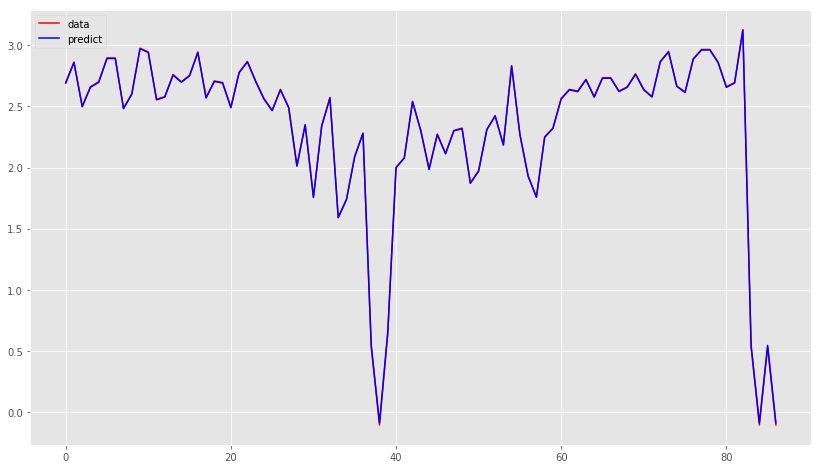

x_scale:  (2, 87, 3, 1)


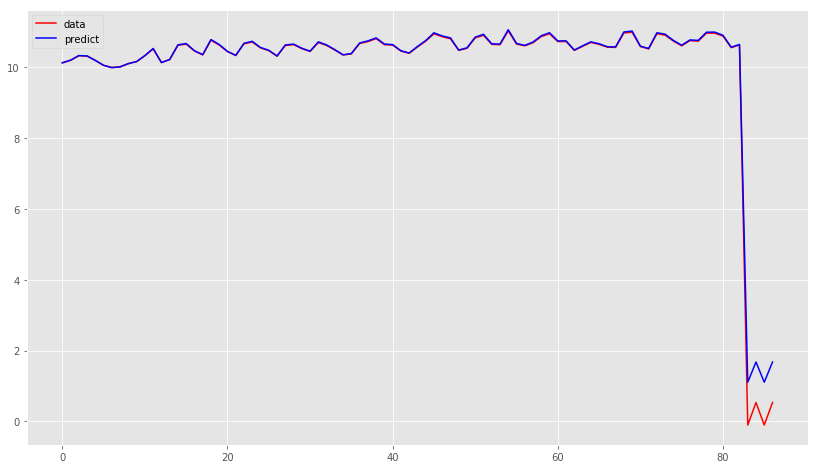

87/87 [==============================] - 0s 68us/step
model evaluate mse: [2.946311106627015, 0.018999834684119827, 2.9273113135633797, 0.01899983502667526, 2.9273110751448006]


In [29]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

# 精度の評価

In [30]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.0061691480363831675
rmse: 0.15028096341351474
0.07822505572494895


# Task Wise Early Stopping

In [31]:
del model
gc.collect()
model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 3, 120)       58560       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 3, 150)       91200       input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (D

## Task wise Early Stoppingの設定

In [32]:
from keras.callbacks import Callback
import numpy as np
import warnings

class TaskWiseEarlyStopping(Callback):


    def __init__(self,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False):
        super(TaskWiseEarlyStopping, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.stop_monitor = None

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.' % mode,
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.stop_monitor = self.monitor
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of '
                              'the best epoch')
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping %s' % (self.stopped_epoch + 1, self.monitor))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

## どのロスをチェックするか選択

In [33]:
monitor_list = ['val_' + layer.name + '_loss' for layer in model.layers if 'dense' in layer.name]

callbacks_list = [TaskWiseEarlyStopping(monitor=monitor, patience=30, verbose=1) for monitor in monitor_list]

In [34]:
log_dir = 'model_task_wise'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

callbacks_list.append(tensorboard)

## Task Wise Early Stoppingを適用

In [35]:
with timer('train model individual task_wise'):
    model.fit(x, x, validation_split=0.1,
              epochs=1000, callbacks=callbacks_list)

Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 7ms/step - loss: 0.8016 - dense_7_loss: 0.0633 - dense_8_loss: 0.7384 - dense_7_mean_squared_error: 0.0633 - dense_8_mean_squared_error: 0.7384 - val_loss: 0.6922 - val_dense_7_loss: 0.0343 - val_dense_8_loss: 0.6579 - val_dense_7_mean_squared_error: 0.0343 - val_dense_8_mean_squared_error: 0.6579
Epoch 2/1000
135/135 [==============================] - 0s 214us/step - loss: 0.6160 - dense_7_loss: 0.0441 - dense_8_loss: 0.5719 - dense_7_mean_squared_error: 0.0441 - dense_8_mean_squared_error: 0.5719 - val_loss: 0.5339 - val_dense_7_loss: 0.0247 - val_dense_8_loss: 0.5092 - val_dense_7_mean_squared_error: 0.0247 - val_dense_8_mean_squared_error: 0.5092
Epoch 3/1000
135/135 [==============================] - 0s 230us/step - loss: 0.4615 - dense_7_loss: 0.0305 - dense_8_loss: 0.4310 - dense_7_mean_squared_error: 0.0305 - dense_8_mean_squared_error: 0.4310 - val_loss: 0.4022 - val_dense_7

Epoch 24/1000
135/135 [==============================] - 0s 230us/step - loss: 0.0304 - dense_7_loss: 0.0070 - dense_8_loss: 0.0234 - dense_7_mean_squared_error: 0.0070 - dense_8_mean_squared_error: 0.0234 - val_loss: 0.0710 - val_dense_7_loss: 0.0107 - val_dense_8_loss: 0.0603 - val_dense_7_mean_squared_error: 0.0107 - val_dense_8_mean_squared_error: 0.0603
Epoch 25/1000
135/135 [==============================] - 0s 222us/step - loss: 0.0275 - dense_7_loss: 0.0064 - dense_8_loss: 0.0211 - dense_7_mean_squared_error: 0.0064 - dense_8_mean_squared_error: 0.0211 - val_loss: 0.0682 - val_dense_7_loss: 0.0101 - val_dense_8_loss: 0.0581 - val_dense_7_mean_squared_error: 0.0101 - val_dense_8_mean_squared_error: 0.0581
Epoch 26/1000
135/135 [==============================] - 0s 231us/step - loss: 0.0247 - dense_7_loss: 0.0059 - dense_8_loss: 0.0188 - dense_7_mean_squared_error: 0.0059 - dense_8_mean_squared_error: 0.0188 - val_loss: 0.0657 - val_dense_7_loss: 0.0096 - val_dense_8_loss: 0.0561

Epoch 47/1000
135/135 [==============================] - 0s 237us/step - loss: 0.0030 - dense_7_loss: 0.0012 - dense_8_loss: 0.0018 - dense_7_mean_squared_error: 0.0012 - dense_8_mean_squared_error: 0.0018 - val_loss: 0.0438 - val_dense_7_loss: 0.0041 - val_dense_8_loss: 0.0398 - val_dense_7_mean_squared_error: 0.0041 - val_dense_8_mean_squared_error: 0.0398
Epoch 48/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0029 - dense_7_loss: 0.0011 - dense_8_loss: 0.0018 - dense_7_mean_squared_error: 0.0011 - dense_8_mean_squared_error: 0.0018 - val_loss: 0.0434 - val_dense_7_loss: 0.0039 - val_dense_8_loss: 0.0396 - val_dense_7_mean_squared_error: 0.0039 - val_dense_8_mean_squared_error: 0.0396
Epoch 49/1000
135/135 [==============================] - 0s 246us/step - loss: 0.0028 - dense_7_loss: 0.0010 - dense_8_loss: 0.0018 - dense_7_mean_squared_error: 0.0010 - dense_8_mean_squared_error: 0.0018 - val_loss: 0.0429 - val_dense_7_loss: 0.0036 - val_dense_8_loss: 0.0393

135/135 [==============================] - 0s 227us/step - loss: 0.0018 - dense_7_loss: 2.3381e-04 - dense_8_loss: 0.0016 - dense_7_mean_squared_error: 2.3381e-04 - dense_8_mean_squared_error: 0.0016 - val_loss: 0.0363 - val_dense_7_loss: 7.2374e-04 - val_dense_8_loss: 0.0355 - val_dense_7_mean_squared_error: 7.2374e-04 - val_dense_8_mean_squared_error: 0.0355
Epoch 70/1000
135/135 [==============================] - 0s 234us/step - loss: 0.0018 - dense_7_loss: 2.1233e-04 - dense_8_loss: 0.0016 - dense_7_mean_squared_error: 2.1233e-04 - dense_8_mean_squared_error: 0.0016 - val_loss: 0.0361 - val_dense_7_loss: 6.5232e-04 - val_dense_8_loss: 0.0354 - val_dense_7_mean_squared_error: 6.5232e-04 - val_dense_8_mean_squared_error: 0.0354
Epoch 71/1000
135/135 [==============================] - 0s 225us/step - loss: 0.0018 - dense_7_loss: 1.9342e-04 - dense_8_loss: 0.0016 - dense_7_mean_squared_error: 1.9342e-04 - dense_8_mean_squared_error: 0.0016 - val_loss: 0.0358 - val_dense_7_loss: 5.8225e

Epoch 91/1000
135/135 [==============================] - 0s 245us/step - loss: 0.0015 - dense_7_loss: 3.0949e-05 - dense_8_loss: 0.0014 - dense_7_mean_squared_error: 3.0949e-05 - dense_8_mean_squared_error: 0.0014 - val_loss: 0.0312 - val_dense_7_loss: 6.2534e-05 - val_dense_8_loss: 0.0311 - val_dense_7_mean_squared_error: 6.2534e-05 - val_dense_8_mean_squared_error: 0.0311
Epoch 92/1000
135/135 [==============================] - 0s 249us/step - loss: 0.0014 - dense_7_loss: 2.8257e-05 - dense_8_loss: 0.0014 - dense_7_mean_squared_error: 2.8257e-05 - dense_8_mean_squared_error: 0.0014 - val_loss: 0.0310 - val_dense_7_loss: 5.8567e-05 - val_dense_8_loss: 0.0309 - val_dense_7_mean_squared_error: 5.8567e-05 - val_dense_8_mean_squared_error: 0.0309
Epoch 93/1000
135/135 [==============================] - 0s 270us/step - loss: 0.0015 - dense_7_loss: 2.6244e-05 - dense_8_loss: 0.0014 - dense_7_mean_squared_error: 2.6244e-05 - dense_8_mean_squared_error: 0.0014 - val_loss: 0.0307 - val_dense_7

Epoch 113/1000
135/135 [==============================] - 0s 241us/step - loss: 0.0012 - dense_7_loss: 7.6749e-06 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 7.6749e-06 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0270 - val_dense_7_loss: 1.2217e-05 - val_dense_8_loss: 0.0270 - val_dense_7_mean_squared_error: 1.2217e-05 - val_dense_8_mean_squared_error: 0.0270
Epoch 114/1000
135/135 [==============================] - 0s 236us/step - loss: 0.0012 - dense_7_loss: 7.3510e-06 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 7.3510e-06 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0268 - val_dense_7_loss: 1.1702e-05 - val_dense_8_loss: 0.0268 - val_dense_7_mean_squared_error: 1.1702e-05 - val_dense_8_mean_squared_error: 0.0268
Epoch 115/1000
135/135 [==============================] - 0s 251us/step - loss: 0.0012 - dense_7_loss: 7.0975e-06 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 7.0975e-06 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0266 - val_dens

Epoch 135/1000
135/135 [==============================] - 0s 242us/step - loss: 0.0011 - dense_7_loss: 4.5673e-06 - dense_8_loss: 0.0011 - dense_7_mean_squared_error: 4.5673e-06 - dense_8_mean_squared_error: 0.0011 - val_loss: 0.0233 - val_dense_7_loss: 6.6220e-06 - val_dense_8_loss: 0.0233 - val_dense_7_mean_squared_error: 6.6220e-06 - val_dense_8_mean_squared_error: 0.0233
Epoch 136/1000
135/135 [==============================] - 0s 244us/step - loss: 0.0011 - dense_7_loss: 4.5598e-06 - dense_8_loss: 0.0011 - dense_7_mean_squared_error: 4.5598e-06 - dense_8_mean_squared_error: 0.0011 - val_loss: 0.0232 - val_dense_7_loss: 6.4021e-06 - val_dense_8_loss: 0.0232 - val_dense_7_mean_squared_error: 6.4021e-06 - val_dense_8_mean_squared_error: 0.0232
Epoch 137/1000
135/135 [==============================] - 0s 251us/step - loss: 0.0011 - dense_7_loss: 4.5301e-06 - dense_8_loss: 0.0010 - dense_7_mean_squared_error: 4.5301e-06 - dense_8_mean_squared_error: 0.0010 - val_loss: 0.0231 - val_dens

135/135 [==============================] - 0s 260us/step - loss: 9.3216e-04 - dense_7_loss: 4.0364e-06 - dense_8_loss: 9.2813e-04 - dense_7_mean_squared_error: 4.0364e-06 - dense_8_mean_squared_error: 9.2813e-04 - val_loss: 0.0206 - val_dense_7_loss: 5.7744e-06 - val_dense_8_loss: 0.0206 - val_dense_7_mean_squared_error: 5.7744e-06 - val_dense_8_mean_squared_error: 0.0206
Epoch 157/1000
135/135 [==============================] - 0s 246us/step - loss: 9.2743e-04 - dense_7_loss: 4.0912e-06 - dense_8_loss: 9.2334e-04 - dense_7_mean_squared_error: 4.0912e-06 - dense_8_mean_squared_error: 9.2334e-04 - val_loss: 0.0205 - val_dense_7_loss: 5.6838e-06 - val_dense_8_loss: 0.0204 - val_dense_7_mean_squared_error: 5.6838e-06 - val_dense_8_mean_squared_error: 0.0204
Epoch 158/1000
135/135 [==============================] - 0s 249us/step - loss: 9.2972e-04 - dense_7_loss: 4.0680e-06 - dense_8_loss: 9.2565e-04 - dense_7_mean_squared_error: 4.0680e-06 - dense_8_mean_squared_error: 9.2565e-04 - val_lo

135/135 [==============================] - 0s 215us/step - loss: 8.3004e-04 - dense_7_loss: 3.7424e-06 - dense_8_loss: 8.2630e-04 - dense_7_mean_squared_error: 3.7424e-06 - dense_8_mean_squared_error: 8.2630e-04 - val_loss: 0.0186 - val_dense_7_loss: 5.1525e-06 - val_dense_8_loss: 0.0186 - val_dense_7_mean_squared_error: 5.1525e-06 - val_dense_8_mean_squared_error: 0.0186
Epoch 178/1000
135/135 [==============================] - 0s 243us/step - loss: 8.2390e-04 - dense_7_loss: 3.8025e-06 - dense_8_loss: 8.2010e-04 - dense_7_mean_squared_error: 3.8025e-06 - dense_8_mean_squared_error: 8.2010e-04 - val_loss: 0.0185 - val_dense_7_loss: 5.2638e-06 - val_dense_8_loss: 0.0185 - val_dense_7_mean_squared_error: 5.2638e-06 - val_dense_8_mean_squared_error: 0.0185
Epoch 179/1000
135/135 [==============================] - 0s 236us/step - loss: 8.2110e-04 - dense_7_loss: 3.7517e-06 - dense_8_loss: 8.1735e-04 - dense_7_mean_squared_error: 3.7517e-06 - dense_8_mean_squared_error: 8.1735e-04 - val_lo

135/135 [==============================] - 0s 292us/step - loss: 7.4235e-04 - dense_7_loss: 3.4886e-06 - dense_8_loss: 7.3886e-04 - dense_7_mean_squared_error: 3.4886e-06 - dense_8_mean_squared_error: 7.3886e-04 - val_loss: 0.0169 - val_dense_7_loss: 4.8464e-06 - val_dense_8_loss: 0.0169 - val_dense_7_mean_squared_error: 4.8464e-06 - val_dense_8_mean_squared_error: 0.0169
Epoch 199/1000
135/135 [==============================] - 0s 238us/step - loss: 7.4800e-04 - dense_7_loss: 3.4576e-06 - dense_8_loss: 7.4454e-04 - dense_7_mean_squared_error: 3.4576e-06 - dense_8_mean_squared_error: 7.4454e-04 - val_loss: 0.0169 - val_dense_7_loss: 4.7793e-06 - val_dense_8_loss: 0.0169 - val_dense_7_mean_squared_error: 4.7793e-06 - val_dense_8_mean_squared_error: 0.0169
Epoch 200/1000
135/135 [==============================] - 0s 245us/step - loss: 7.5340e-04 - dense_7_loss: 3.4427e-06 - dense_8_loss: 7.4996e-04 - dense_7_mean_squared_error: 3.4427e-06 - dense_8_mean_squared_error: 7.4996e-04 - val_lo

135/135 [==============================] - 0s 246us/step - loss: 6.5701e-04 - dense_7_loss: 3.2355e-06 - dense_8_loss: 6.5377e-04 - dense_7_mean_squared_error: 3.2355e-06 - dense_8_mean_squared_error: 6.5377e-04 - val_loss: 0.0156 - val_dense_7_loss: 4.4677e-06 - val_dense_8_loss: 0.0156 - val_dense_7_mean_squared_error: 4.4677e-06 - val_dense_8_mean_squared_error: 0.0156
Epoch 220/1000
135/135 [==============================] - 0s 249us/step - loss: 6.5370e-04 - dense_7_loss: 3.2300e-06 - dense_8_loss: 6.5047e-04 - dense_7_mean_squared_error: 3.2300e-06 - dense_8_mean_squared_error: 6.5047e-04 - val_loss: 0.0156 - val_dense_7_loss: 4.3790e-06 - val_dense_8_loss: 0.0156 - val_dense_7_mean_squared_error: 4.3790e-06 - val_dense_8_mean_squared_error: 0.0156
Epoch 221/1000
135/135 [==============================] - 0s 238us/step - loss: 6.4301e-04 - dense_7_loss: 3.2098e-06 - dense_8_loss: 6.3980e-04 - dense_7_mean_squared_error: 3.2098e-06 - dense_8_mean_squared_error: 6.3981e-04 - val_lo

In [36]:
callbacks_list.pop()

In [37]:
stop_layer = ''
stop_loss = ''
for callback in callbacks_list:
    if callback.stop_monitor is not None:
        stop_layer = callback.stop_monitor.replace('_loss', '').replace('val_', '')
        stop_loss = callback.stop_monitor

In [38]:
stop_layer, stop_loss

('dense_7', 'val_dense_7_loss')

In [39]:
stop_input_layer = ''
for layer in model.layers:
    if layer.name == stop_layer:
        layer.trainable = False
        stop_input_layer = layer.input.name.split('/')[2]
        
for layer in model.layers:
    if layer.name == stop_input_layer:
        layer.trainable = False

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 3, 120)       58560       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 3, 150)       91200       input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (D

In [41]:
monitor_list = []
for layer in model.layers:
    if 'dense' in layer.name and layer.name != stop_layer:
        monitor_list.append('val_' + layer.name + '_loss')

In [42]:
monitor_list

['val_dense_8_loss']

In [43]:
callbacks_list = []
for monitor in monitor_list:
    print(monitor)
    callbacks_list.append(TaskWiseEarlyStopping(monitor=monitor, patience=30, verbose=1))

callbacks_list.append(tensorboard)

with timer('train model individual hetero'):
    model.fit(x, x, validation_split=0.1,
              epochs=1000, callbacks=callbacks_list)

val_dense_8_loss
Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 5ms/step - loss: 0.0012 - dense_7_loss: 2.9810e-06 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0151 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0151 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0151
Epoch 2/1000
135/135 [==============================] - 0s 186us/step - loss: 8.7540e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 8.7241e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 8.7241e-04 - val_loss: 0.0144 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0144 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0144
Epoch 3/1000
135/135 [==============================] - 0s 196us/step - loss: 6.7825e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 6.7527e-04 - dense_7_mean_squared_error: 2.9

Epoch 22/1000
135/135 [==============================] - 0s 190us/step - loss: 3.2602e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.2304e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.2304e-04 - val_loss: 0.0097 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0097 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0097
Epoch 23/1000
135/135 [==============================] - 0s 180us/step - loss: 3.1572e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.1274e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.1274e-04 - val_loss: 0.0095 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0095 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0095
Epoch 24/1000
135/135 [==============================] - 0s 186us/step - loss: 2.9991e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.9693e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.9693e

135/135 [==============================] - 0s 202us/step - loss: 1.3582e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.3284e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.3284e-04 - val_loss: 0.0059 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0059 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0059
Epoch 44/1000
135/135 [==============================] - 0s 209us/step - loss: 1.3512e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.3214e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.3214e-04 - val_loss: 0.0058 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0058 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0058
Epoch 45/1000
135/135 [==============================] - 0s 201us/step - loss: 1.2810e-04 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2512e-04 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2512e-04 - val_loss

135/135 [==============================] - 0s 201us/step - loss: 5.5090e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 5.2109e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 5.2109e-05 - val_loss: 0.0037 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0037 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0037
Epoch 65/1000
135/135 [==============================] - 0s 205us/step - loss: 5.2619e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 4.9638e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 4.9638e-05 - val_loss: 0.0036 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0036 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0036
Epoch 66/1000
135/135 [==============================] - 0s 198us/step - loss: 5.2360e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 4.9379e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 4.9379e-05 - val_loss

135/135 [==============================] - 0s 209us/step - loss: 2.6744e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.3763e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.3763e-05 - val_loss: 0.0026 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0026 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0026
Epoch 86/1000
135/135 [==============================] - 0s 204us/step - loss: 2.7190e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.4209e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.4209e-05 - val_loss: 0.0025 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0025 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0025
Epoch 87/1000
135/135 [==============================] - 0s 199us/step - loss: 2.7004e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.4023e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.4023e-05 - val_loss

135/135 [==============================] - 0s 198us/step - loss: 1.3244e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.0263e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.0263e-05 - val_loss: 0.0020 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0020 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0020
Epoch 107/1000
135/135 [==============================] - 0s 212us/step - loss: 1.2779e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 9.7977e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 9.7977e-06 - val_loss: 0.0020 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0020 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0020
Epoch 108/1000
135/135 [==============================] - 0s 206us/step - loss: 1.3574e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.0593e-05 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.0593e-05 - val_lo

135/135 [==============================] - 0s 194us/step - loss: 8.9517e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 5.9706e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 5.9706e-06 - val_loss: 0.0017 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0017 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0017
Epoch 128/1000
135/135 [==============================] - 0s 197us/step - loss: 8.9324e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 5.9514e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 5.9514e-06 - val_loss: 0.0017 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0017 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0017
Epoch 129/1000
135/135 [==============================] - 0s 197us/step - loss: 8.6533e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 5.6723e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 5.6723e-06 - val_lo

135/135 [==============================] - 0s 186us/step - loss: 6.3964e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.4153e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.4153e-06 - val_loss: 0.0015 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0015 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0015
Epoch 149/1000
135/135 [==============================] - 0s 204us/step - loss: 6.8304e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.8493e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.8493e-06 - val_loss: 0.0015 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0015 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0015
Epoch 150/1000
135/135 [==============================] - 0s 186us/step - loss: 6.7151e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.7340e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.7340e-06 - val_lo

135/135 [==============================] - 0s 207us/step - loss: 5.3467e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.3656e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.3656e-06 - val_loss: 0.0014 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0014 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0014
Epoch 170/1000
135/135 [==============================] - 0s 202us/step - loss: 5.3852e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.4041e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.4041e-06 - val_loss: 0.0014 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0014 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0014
Epoch 171/1000
135/135 [==============================] - 0s 199us/step - loss: 5.2356e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.2545e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.2545e-06 - val_lo

135/135 [==============================] - 0s 198us/step - loss: 4.6493e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.6683e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.6683e-06 - val_loss: 0.0013 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 191/1000
135/135 [==============================] - 0s 205us/step - loss: 5.4983e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.5173e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.5173e-06 - val_loss: 0.0013 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 192/1000
135/135 [==============================] - 0s 215us/step - loss: 5.5964e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.6153e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.6153e-06 - val_lo

135/135 [==============================] - 0s 196us/step - loss: 4.8716e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.8905e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.8905e-06 - val_loss: 0.0013 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 212/1000
135/135 [==============================] - 0s 206us/step - loss: 4.8306e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.8495e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.8495e-06 - val_loss: 0.0013 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 213/1000
135/135 [==============================] - 0s 202us/step - loss: 4.6012e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.6202e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.6202e-06 - val_lo

135/135 [==============================] - 0s 187us/step - loss: 4.2376e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2566e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2566e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 233/1000
135/135 [==============================] - 0s 195us/step - loss: 5.8769e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.8959e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.8959e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 234/1000
135/135 [==============================] - 0s 198us/step - loss: 4.4317e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.4507e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.4507e-06 - val_lo

135/135 [==============================] - 0s 207us/step - loss: 4.2340e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2529e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2529e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 254/1000
135/135 [==============================] - 0s 200us/step - loss: 4.1694e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.1884e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.1884e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 255/1000
135/135 [==============================] - 0s 195us/step - loss: 4.0594e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.0784e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.0784e-06 - val_lo

135/135 [==============================] - 0s 212us/step - loss: 4.6029e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.6219e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.6219e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 275/1000
135/135 [==============================] - 0s 202us/step - loss: 5.9565e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.9755e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.9755e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 276/1000
135/135 [==============================] - 0s 198us/step - loss: 6.1266e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.1456e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.1456e-06 - val_lo

135/135 [==============================] - 0s 198us/step - loss: 4.6397e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.6587e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.6587e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 296/1000
135/135 [==============================] - 0s 194us/step - loss: 4.6821e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.7011e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.7011e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 297/1000
135/135 [==============================] - 0s 195us/step - loss: 4.4717e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.4907e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.4907e-06 - val_lo

135/135 [==============================] - 0s 207us/step - loss: 4.4644e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.4833e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.4833e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 317/1000
135/135 [==============================] - 0s 193us/step - loss: 5.3426e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.3615e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.3615e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 318/1000
135/135 [==============================] - 0s 201us/step - loss: 4.5698e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.5888e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.5888e-06 - val_lo

135/135 [==============================] - 0s 195us/step - loss: 4.2186e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2376e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2376e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 338/1000
135/135 [==============================] - 0s 205us/step - loss: 7.0500e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 4.0690e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 4.0690e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 339/1000
135/135 [==============================] - 0s 201us/step - loss: 4.1294e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.1484e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.1484e-06 - val_lo

135/135 [==============================] - 0s 185us/step - loss: 6.2299e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.2488e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.2488e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 359/1000
135/135 [==============================] - 0s 178us/step - loss: 5.1575e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.1765e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.1765e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 360/1000
135/135 [==============================] - 0s 191us/step - loss: 6.3557e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.3746e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.3746e-06 - val_lo

135/135 [==============================] - 0s 187us/step - loss: 4.2480e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2669e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2669e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 380/1000
135/135 [==============================] - 0s 205us/step - loss: 4.2766e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2956e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2956e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 381/1000
135/135 [==============================] - 0s 203us/step - loss: 5.9820e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.0010e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.0010e-06 - val_lo

135/135 [==============================] - 0s 211us/step - loss: 5.7552e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.7741e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.7741e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 401/1000
135/135 [==============================] - 0s 202us/step - loss: 5.2523e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.2713e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.2713e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 402/1000
135/135 [==============================] - 0s 207us/step - loss: 4.2201e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2391e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2391e-06 - val_lo

135/135 [==============================] - 0s 208us/step - loss: 9.1152e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 6.1342e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 6.1342e-06 - val_loss: 0.0012 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 422/1000
135/135 [==============================] - 0s 213us/step - loss: 1.1221e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 8.2396e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 8.2396e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 423/1000
135/135 [==============================] - 0s 197us/step - loss: 1.1748e-05 - dense_7_loss: 2.9810e-06 - dense_8_loss: 8.7665e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 8.7665e-06 - val_lo

135/135 [==============================] - 0s 198us/step - loss: 4.4444e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.4633e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.4633e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 443/1000
135/135 [==============================] - 0s 203us/step - loss: 3.9783e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 9.9727e-07 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 9.9727e-07 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 444/1000
135/135 [==============================] - 0s 205us/step - loss: 5.3586e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.3775e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.3775e-06 - val_lo

135/135 [==============================] - 0s 189us/step - loss: 7.2183e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 4.2373e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 4.2373e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 464/1000
135/135 [==============================] - 0s 184us/step - loss: 5.1903e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 2.2093e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 2.2093e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 465/1000
135/135 [==============================] - 0s 211us/step - loss: 7.8019e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 4.8209e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 4.8209e-06 - val_lo

135/135 [==============================] - 0s 192us/step - loss: 4.2779e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2969e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2969e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 485/1000
135/135 [==============================] - 0s 207us/step - loss: 4.2438e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 1.2627e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 1.2627e-06 - val_loss: 0.0011 - val_dense_7_loss: 4.3387e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 4.3387e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 486/1000
135/135 [==============================] - 0s 237us/step - loss: 6.0874e-06 - dense_7_loss: 2.9810e-06 - dense_8_loss: 3.1064e-06 - dense_7_mean_squared_error: 2.9810e-06 - dense_8_mean_squared_error: 3.1064e-06 - val_lo

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.4091382027s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2502467930316925
Inverse
after max 2.859119415283203
x_scale:  (2, 87, 3, 1)


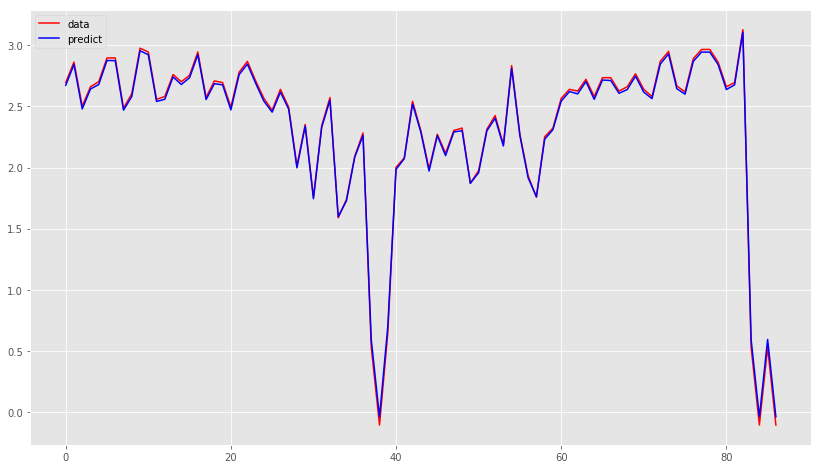

x_scale:  (2, 87, 3, 1)


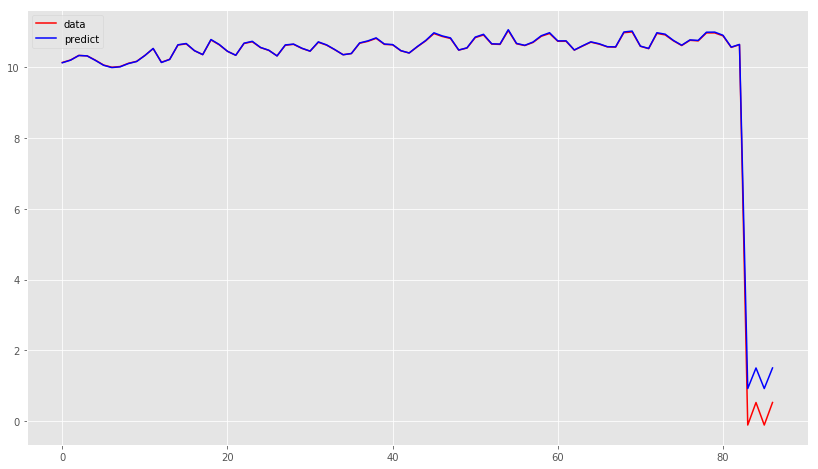

87/87 [==============================] - 0s 63us/step
model evaluate mse: [2.386791697863875, 0.1590223327792924, 2.2277694214349504, 0.15902233706123528, 2.2277694214349504]


In [44]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

## Task wise Early Stopping適用後の精度を計測

In [45]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.017635052206957685
rmse: 0.1481886628944318
0.08291185755069475
